# Point Colaboratory to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

datapath = '/content/gdrive/My Drive/TESI/' 

Mounted at /content/gdrive


# Import

In [ ]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=96cf4c2601eb7181ab2c485d9a751e554424d351ce8c4cd71f30e65ef8760297
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import tqdm.notebook as tq
import time
from operator import itemgetter
import random
import datetime 
from pandas.api.types import is_numeric_dtype # used for one-hot encoding
import math
import tqdm.notebook as tq
import itertools

# Text mining
from stop_words import get_stop_words
from string import punctuation 
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
from scipy import sparse
from scipy.sparse import hstack, vstack

# Sklearn utilities
# from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from collections import Counter
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler

# Sklearn models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


import warnings
warnings.filterwarnings("ignore")

# Neural Netowrk and Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


# Dataset

In [ ]:
data = pd.read_csv(datapath + 'dataset/data8.csv')
# data[['jobid','jobtaskid', 'resid', 'custid', 'sede']] = data[['jobid','jobtaskid', 'resid', 'custid', 'sede']].astype(str)
# data[['flg_trasferta','pay', 'flg_prepagato', 'flg_straordinario']] = data[['flg_trasferta','pay', 'flg_prepagato', 'flg_straordinario']].astype(int)
# data = data.drop(['workdesc'], inplace=False, axis=1)
# data = data8[['cleaned_workdesc', 'tipo_update']]
data = data[~ data.cleaned_workdesc.isna()]
data

qty  day  ...                                   cleaned_workdesc  tipo_update
0      5.5  284  ...                                      sophos aulss7            1
1      6.0  283  ...                                      sophos aulss7            1
2      1.5  282  ...  test attiv journeys ato uk ato us analis metri...            0
3      0.5  281  ...      call team client fix problemat tracker domain            0
4      0.5  279  ...  analis problemat configur pardot tracker domai...            0
...    ...  ...  ...                                                ...          ...
22580  1.5   77  ...                               document fluss kettl            1
22581  4.0   72  ...                               document fluss kettl            1
22582  8.0   69  ...                               document fluss kettl            1
22583  8.0   71  ...    upgrad server qlikview install component python            1
22584  1.0   68  ...                          sistem colleg server qlik            0

[21802 rows x 1214 columns]

## Split

In [ ]:
def split_data(X, y):
    # Divide the dataset into training, validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, 
                                                                random_state=22, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=22, stratify=y_train_val)

    print("Training Set shape: {}".format(X_train.shape))
    print("Validation Set shape: {}".format(X_val.shape))
    print("Training + Validation Set shape: {}".format(X_train_val.shape))
    print("Test Set shape: {}".format(X_test.shape))

    return X_train, y_train, X_val, X_test, y_val, y_test, X_train_val, y_train_val

In [ ]:
X_train, y_train, X_val, X_test, y_val, y_test, X_train_val, y_train_val = split_data(data.iloc[:,:-1], data.tipo_update)

Training Set shape: (13080, 1213)
Validation Set shape: (4361, 1213)
Training + Validation Set shape: (17441, 1213)
Test Set shape: (4361, 1213)


In [ ]:
X_train

qty  day  ...  sede_9.0                                   cleaned_workdesc
18259  4.0  106  ...         0         svilupp programm didatt fattur prepar cors
21     8.0  274  ...         0                       install datacatalog amundsen
883    8.0  265  ...         0  ticket sr incident chang ribalt prod coll user...
9442   7.0  201  ...         0           redazion doc nuov serviz assessment gdpr
8582   0.5  202  ...         0            sdcs richiest trasfer domin richiest n°
...    ...  ...  ...       ...                                                ...
13825  0.5  152  ...         0                  gestion ticket duplic info risolt
7027   2.0  216  ...         0                          fix ui modell storn aplus
2311   8.0  246  ...         0                                            ordinar
5180   6.0  226  ...         0                             affianc tommas paolett
1242   6.0  273  ...         0                                  risolv error chat

[13080 rows x 1213 columns]

In [ ]:
classes, class_count = np.unique(y_train, return_counts=True)
classesv, class_countv = np.unique(y_val, return_counts=True)
classest, class_countt = np.unique(y_test, return_counts=True)
y_labels = ['approvato', 'cambio_commessa']
pd.DataFrame((classes, class_count, class_countv, class_countt), columns=y_labels, index=['Label', 'Trainining', 'Validation', 'Test'])

approvato  cambio_commessa
Label               0                1
Trainining      11872             1208
Validation       3958              403
Test             3958              403

## BOW

In [ ]:
def vectorizer(X_train, X_val, X_test, max_features=1000, n_min=1, n_max=1, vect_type='cv'):
    if vect_type == 'cv':
        vect = CountVectorizer(
            max_features = max_features,
            ngram_range = (n_min, n_max),     # (1,1) means only unigrams, (1,2) means unigrams and bigrams, (2,2) only bigrams
            )
        
    if vect_type == 'tfidf':
         vect = TfidfVectorizer(
            max_features = max_features,
            ngram_range = (n_min, n_max),     # (1,1) means only unigrams, (1,2) means unigrams and bigrams, (2,2) only bigrams
            )

    vect_train = vect.fit_transform(X_train['cleaned_workdesc'])
    vect_train = pd.DataFrame(vect_train.toarray(), columns=vect.get_feature_names())
    X_train_v = pd.concat([X_train.reset_index().drop(['index'], inplace=False, axis=1), vect_train], axis=1)
    X_train_v.drop(['cleaned_workdesc'], inplace=True, axis=1)

    vect_val = vect.transform(X_val['cleaned_workdesc'])
    vect_val = pd.DataFrame(vect_val.toarray(), columns=vect.get_feature_names())
    X_val_v = pd.concat([X_val.reset_index().drop(['index'], inplace=False, axis=1), vect_val], axis=1)
    X_val_v.drop(['cleaned_workdesc'], inplace=True, axis=1)
    
    vect_test = vect.transform(X_test['cleaned_workdesc'])
    vect_test = pd.DataFrame(vect_test.toarray(), columns=vect.get_feature_names())
    X_test_v = pd.concat([X_test.reset_index().drop(['index'], inplace=False, axis=1), vect_test], axis=1)
    X_test_v.drop(['cleaned_workdesc'], inplace=True, axis=1)
    
    return X_train_v, X_val_v, X_test_v, vect

In [ ]:
X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features=1000, n_min=1, n_max=2, vect_type='cv')

In [ ]:
X_train

qty  day  ...  sede_9.0                                   cleaned_workdesc
18259  4.0  106  ...         0         svilupp programm didatt fattur prepar cors
21     8.0  274  ...         0                       install datacatalog amundsen
883    8.0  265  ...         0  ticket sr incident chang ribalt prod coll user...
9442   7.0  201  ...         0           redazion doc nuov serviz assessment gdpr
8582   0.5  202  ...         0            sdcs richiest trasfer domin richiest n°
...    ...  ...  ...       ...                                                ...
13825  0.5  152  ...         0                  gestion ticket duplic info risolt
7027   2.0  216  ...         0                          fix ui modell storn aplus
2311   8.0  246  ...         0                                            ordinar
5180   6.0  226  ...         0                             affianc tommas paolett
1242   6.0  273  ...         0                                  risolv error chat

[13080 rows x 1213 columns]

In [ ]:
X_train_v

qty  day  delay  flg_trasferta  ...  workshop  workspac  xg  zer
0      4.0  106      4              0  ...         0         0   0    0
1      8.0  274      8              0  ...         0         0   0    0
2      8.0  265      1              0  ...         0         0   0    0
3      7.0  201      2              0  ...         0         0   0    0
4      0.5  202      0              0  ...         0         0   0    0
...    ...  ...    ...            ...  ...       ...       ...  ..  ...
13075  0.5  152      0              0  ...         0         0   0    0
13076  2.0  216      0              0  ...         0         0   0    0
13077  8.0  246      1              0  ...         0         0   0    0
13078  6.0  226      0              0  ...         0         0   0    0
13079  6.0  273      0              0  ...         0         0   0    0

[13080 rows x 2212 columns]

## Under/Oversampling

In [ ]:
def resampling(X_train_v, y_train, approach='none'):
    # summarize class distribution
    # print(Counter(y_train))
    
    if approach == 'over':
        # define oversampling strategy
        resample = RandomOverSampler(sampling_strategy='minority', random_state=1)
    
    if approach == 'under':
        # define undersample strategy
        resample = RandomUnderSampler(sampling_strategy='majority', random_state=1)

    if approach == 'mid':
        resample = RandomOverSampler(sampling_strategy=0.4212, random_state=1)
        # resample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
        X_train_v_r, y_train_r = resample.fit_resample(X_train_v, y_train)
        resample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
        X_train_v_r, y_train_r = resample.fit_resample(X_train_v_r, y_train_r)
        return X_train_v_r, y_train_r

    if approach == 'none':
        return X_train_v, y_train

    # fit and apply the transform
    X_train_v_r, y_train_r = resample.fit_resample(X_train_v, y_train)
    # summarize class distribution
    # print(Counter(y_train_r)) 

    return X_train_v_r, y_train_r

In [ ]:
X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach='mid')

In [ ]:
X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach='over')

In [ ]:
X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach='under')

In [ ]:
X_train_v_r.shape

(2416, 2212)

# Model training (with text)

The procedure will be the following for each model: train the models using some hyper-parameters combinations and evaluating them in the validation set. Seelct the configuration leading to the higher validation accuracy, and re-train the model with this combination in the merged training-validation set. Finally, evaluate it just once in the test set.

### Auxiliary functions

Let's write some auxiliary functions

In [ ]:
def metrics(true_positive, true_negative, false_positive, false_negative):
  
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
    precision = true_positive / (true_positive + false_positive)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    weighted_accuracy = (sensitivity + specificity) / 2
    mcc_numerator = (true_positive * true_negative) - (false_positive * false_negative)
    mcc_denominator_squared = (true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative)
    mcc = mcc_numerator / math.sqrt(mcc_denominator_squared)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    return {
            "Accuracy": accuracy,
            "Weighted accuracy": weighted_accuracy,
            "Precision": precision,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "MCC": mcc,
            "F-score": f1_score
            }


In [ ]:
def metrics_results(true, pred):

    true_positive = np.sum(np.logical_and(true == 1, pred == 1))
     
    # remove from actual positive the TP to get FN 
    false_negative = np.sum(true) - true_positive

    # remove from predicted positive the TP to get FP
    false_positive = np.sum(pred) - true_positive

    true_negative = np.sum(np.logical_and(true == 0, pred == 0))
    
    conf_matrix = pd.DataFrame(np.array([[true_positive, false_positive], [false_negative, true_negative]]), 
                               index=['Positive pred', 'Negative pred'], 
                               columns=['Actual positive', 'Actual negative'])

    return conf_matrix, metrics(true_positive, true_negative, false_positive, false_negative)  

In [ ]:
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

In [ ]:
X_train, y_train, X_val, X_test, y_val, y_test, X_train_val, y_train_val = split_data(data.iloc[:,:-1], data.tipo_update)

Training Set shape: (13080, 1213)
Validation Set shape: (4361, 1213)
Training + Validation Set shape: (17441, 1213)
Test Set shape: (4361, 1213)


In [ ]:
# X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features=10, n_min=1, n_max=1, vect_type='cv')

In [ ]:
# X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach='over')

In [ ]:
# X_train_v_r

<23744x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 114448 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_v_r.shape

(2416, 2212)

## Random Forest

In [ ]:
max_features_v = [250, 500, 1000, 1900, 2703, 3725, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
vect_type_v = ['cv', 'tfidf']
approach_v = ['none', 'over', 'under', 'mid']
n_estimator_v = [1, 50, 100, 200, 500]
max_depth_v = [10, 50, 100, 200]

results = []

# RANDOM SEARCH
random.seed(22)
pbar = tq.tqdm(total = 30, desc = 'Random search progress')
random_coarse_grid = list(itertools.product(max_features_v, n_max_v, vect_type_v, approach_v, n_estimator_v, max_depth_v))
for (max_features, n_max, vect_type, approach, n_estimator, max_depth) in random.sample(random_coarse_grid, 30):
    # sampling combinations from itertools.product, we are sure no combination is repeated
    print(f'max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type},' 
          f' approach = {approach}, n_estimator = {n_estimator}, max_depth = {max_depth}')

    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

    model_rf = RandomForestClassifier(n_estimators = n_estimator, max_depth = max_depth, n_jobs=-1, random_state = 1)
    model_rf.fit(X_train_v_r, y_train_r)
    y_train_pred = model_rf.predict(X_train_v_r)
    y_valid_pred = model_rf.predict(X_val_v)

    acc = accuracy(y_train_r, y_train_pred)
    bacc = balanced_accuracy_score(y_train_r, y_train_pred)
    acc_v = accuracy(y_val, y_valid_pred)
    bacc_v = balanced_accuracy_score(y_val, y_valid_pred)

    print(f'Training acc = {acc:.3f}, Training b_acc = {bacc:.3f}, Validation acc = {acc_v:.3f}, Validation b_acc = {bacc_v:.3f}')
    print()

    results.append((np.round(acc_v, 3), np.round(bacc_v, 3), f'max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type},' 
          f' approach = {approach}, n_estimator = {n_estimator}, max_depth = {max_depth}'))
    
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.3f}, Val_bal_acc = {r[1]:.3f} -> {r[2]}')
print()

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.3f}, Val_bal_acc = {r[1]:.3f} -> {r[2]}')

max_features = 500, n_max = 1, vect_type = tfidf, approach = none, n_estimator = 200, max_depth = 100
Training acc = 0.998, Training b_acc = 0.992, Validation acc = 0.938, Validation b_acc = 0.709

max_features = 1000, n_max = 1, vect_type = cv, approach = over, n_estimator = 200, max_depth = 50
Training acc = 0.998, Training b_acc = 0.998, Validation acc = 0.936, Validation b_acc = 0.801

max_features = 250, n_max = 1, vect_type = tfidf, approach = none, n_estimator = 500, max_depth = 10
Training acc = 0.913, Training b_acc = 0.528, Validation acc = 0.911, Validation b_acc = 0.520

max_features = 3725, n_max = 1, vect_type = tfidf, approach = over, n_estimator = 100, max_depth = 200
Training acc = 1.000, Training b_acc = 1.000, Validation acc = 0.943, Validation b_acc = 0.763

max_features = 1900, n_max = 3, vect_type = cv, approach = mid, n_estimator = 100, max_depth = 200
Training acc = 1.000, Training b_acc = 1.000, Validation acc = 0.932, Validation b_acc = 0.820

max_features = 5

#### Best model - accuracy

In [ ]:
# Val_acc = 0.942, Val_bal_acc = 0.775 -> max_features = 500, n_max = 2, vect_type = tfidf, approach = over, n_estimator = 200, max_depth = 100


# X_train, y_train, X_val, X_test, y_val, y_test, X_train_val, y_train_val = split_data(data.cleaned_workdesc, data.tipo_update)

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, 500, 1, 2, 'tfidf')
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, 'over')


model_rf = RandomForestClassifier(n_estimators = 200, max_depth = 100, n_jobs=-1, random_state = 1)
start_time = time.time()
model_rf.fit(X_train_val_v_r, y_train_val_r)
run_time_rf_fit = (time.time() - start_time)

start_time = time.time()
y_train_val_pred_rf = model_rf.predict(X_train_val_v_r)
y_test_pred_rf = model_rf.predict(X_test_v)
run_time_rf_predict = (time.time() - start_time)

In [ ]:
train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
test_acc_rf = accuracy(y_test_pred_rf, y_test)
test_bacc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy on training + validation set: {train_acc_rf}')
print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
print(f'Test accuracy: {test_acc_rf}')
print(f'Test balanced accuracy: {test_bacc_rf}')

Accuracy on training + validation set: 0.9999052432090967
Balanced accuracy on training + validation set: 0.9999052432090967
Test accuracy: 0.9484063288236643
Test balanced accuracy: 0.783248300705798


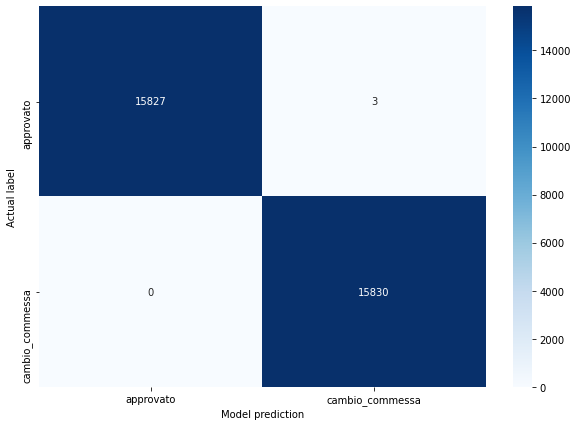

In [ ]:
# Training set
conf_mat = confusion_matrix(y_train_val_r, y_train_val_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual label')
plt.xlabel('Model prediction')
plt.show()

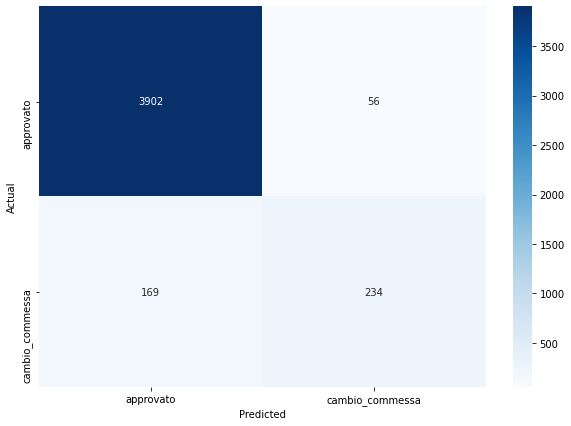

In [ ]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix_rf, metric_results_rf = metrics_results(y_test, y_test_pred_rf)
print('CLASSIFICATION METRICS')
for k in metric_results_rf:
    print(f'{k}: {metric_results_rf[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix_rf

CLASSIFICATION METRICS
Accuracy: 0.948
Weighted accuracy: 0.783
Precision: 0.807
Sensitivity: 0.581
Specificity: 0.986
MCC: 0.658
F-score: 0.675

CONFUSION MATRIX


Actual positive  Actual negative
Positive pred              234               56
Negative pred              169             3902

#### Best model - balanced accuracy

In [ ]:
# Val_acc = 0.932, Val_bal_acc = 0.826 -> max_features = 3725, n_max = 3, vect_type = tfidf, approach = mid, n_estimator = 200, max_depth = 200

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, 3725, 1, 3, 'tfidf')
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, 'mid')


model_rf = RandomForestClassifier(n_estimators = 200, max_depth = 200, n_jobs=-1, random_state = 1)
start_time = time.time()
model_rf.fit(X_train_val_v_r, y_train_val_r)
run_time_rf_fit = (time.time() - start_time)

start_time = time.time()
y_train_val_pred_rf = model_rf.predict(X_train_val_v_r)
y_test_pred_rf = model_rf.predict(X_test_v)
run_time_rf_predict = (time.time() - start_time)

In [ ]:
train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
test_acc_rf = accuracy(y_test_pred_rf, y_test)
test_bacc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy on training + validation set: {train_acc_rf}')
print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
print(f'Test accuracy: {test_acc_rf}')
print(f'Test balanced accuracy: {test_bacc_rf}')

Accuracy on training + validation set: 0.9999250037498125
Balanced accuracy on training + validation set: 0.9999250037498125
Test accuracy: 0.9332721852786058
Test balanced accuracy: 0.8284004378480246


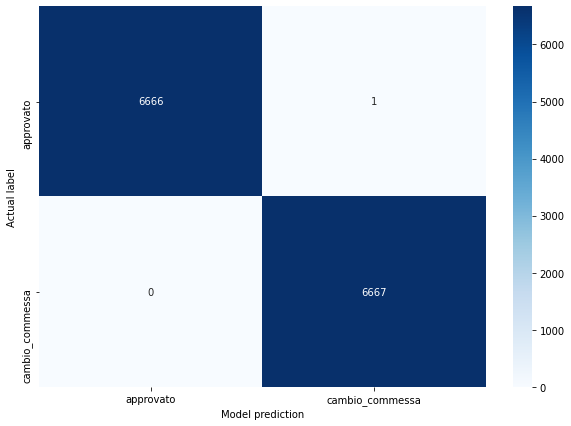

In [ ]:
# Training set
conf_mat = confusion_matrix(y_train_val_r, y_train_val_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual label')
plt.xlabel('Model prediction')
plt.show()

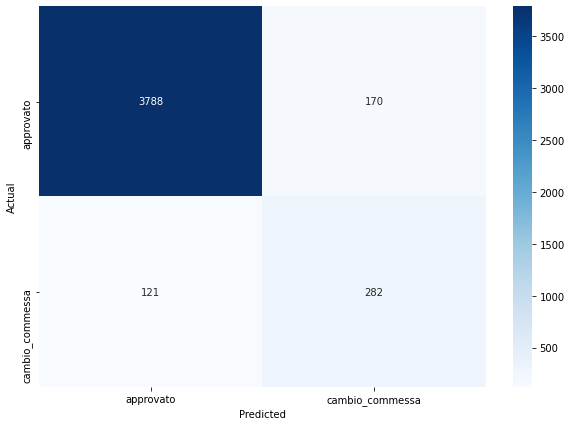

In [ ]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix_rf, metric_results_rf = metrics_results(y_test, y_test_pred_rf)
print('CLASSIFICATION METRICS')
for k in metric_results_rf:
    print(f'{k}: {metric_results_rf[k]:.3}')
    
# print('\nCONFUSION MATRIX')    
# conf_matrix_rf

CLASSIFICATION METRICS
Accuracy: 0.933
Weighted accuracy: 0.828
Precision: 0.624
Sensitivity: 0.7
Specificity: 0.957
MCC: 0.624
F-score: 0.66


## Logistic Regression

In [ ]:
max_features_v = [250, 500, 1000, 1900, 2703, 3725, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
vect_type_v = ['cv', 'tfidf']
approach_v = ['none', 'over', 'under', 'mid']
max_iter_v = [4, 32, 128, 512, 2048, 8192]
reg_term_v = [0.001, 0.01, 0.1, 1, 10, 100]

results = []

# RANDOM SEARCH
random.seed(22)
pbar = tq.tqdm(total = 50, desc = 'Random search progress')
random_coarse_grid = list(itertools.product(max_features_v, n_max_v, vect_type_v, approach_v, max_iter_v, reg_term_v))
for (max_features, n_max, vect_type, approach, max_iter, reg_term) in random.sample(random_coarse_grid, 50):
    # sampling combinations from itertools.product, we are sure no combination is repeated
    print(f'max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type},' 
          f' approach = {approach}, reg_term = {reg_term}, max_iter = {max_iter}')

    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)


    model_logreg = LogisticRegression(max_iter = max_iter, C = reg_term, random_state=22, solver='lbfgs', multi_class='auto')
    model_logreg.fit(X_train_v_r, y_train_r)
    y_train_pred = model_logreg.predict(X_train_v_r)
    y_valid_pred = model_logreg.predict(X_val_v)


    acc = accuracy(y_train_r, y_train_pred)
    bacc = balanced_accuracy_score(y_train_r, y_train_pred)
    acc_v = accuracy(y_val, y_valid_pred)
    bacc_v = balanced_accuracy_score(y_val, y_valid_pred)

    print(f'Training acc = {acc:.3f}, Training b_acc = {bacc:.3f}, Validation acc = {acc_v:.3f}, Validation b_acc = {bacc_v:.3f}')
    print()

    results.append((np.round(acc_v, 3), np.round(bacc_v, 3), f'max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type},' 
          f' approach = {approach}, reg_term = {reg_term}, max_iter = {max_iter}'))
    
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.3f}, Val_bal_acc = {r[1]:.3f} -> {r[2]}')
print()

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.3f}, Val_bal_acc = {r[1]:.3f} -> {r[2]}')

max_features = 500, n_max = 1, vect_type = tfidf, approach = mid, reg_term = 1, max_iter = 8192
Training acc = 0.901, Training b_acc = 0.901, Validation acc = 0.843, Validation b_acc = 0.820

max_features = 1000, n_max = 1, vect_type = tfidf, approach = mid, reg_term = 0.01, max_iter = 32
Training acc = 0.652, Training b_acc = 0.652, Validation acc = 0.648, Validation b_acc = 0.616

max_features = 250, n_max = 1, vect_type = tfidf, approach = over, reg_term = 0.01, max_iter = 128
Training acc = 0.778, Training b_acc = 0.778, Validation acc = 0.791, Validation b_acc = 0.741

max_features = 3725, n_max = 3, vect_type = cv, approach = mid, reg_term = 0.001, max_iter = 512
Training acc = 0.681, Training b_acc = 0.681, Validation acc = 0.639, Validation b_acc = 0.645

max_features = 2703, n_max = 1, vect_type = tfidf, approach = over, reg_term = 0.1, max_iter = 2048
Training acc = 0.884, Training b_acc = 0.884, Validation acc = 0.849, Validation b_acc = 0.832

max_features = 500, n_max = 3,

#### Best model - accuracy

In [ ]:
# Val_acc = 0.930, Val_bal_acc = 0.747 -> max_features = 3725, n_max = 3, vect_type = cv, approach = none, reg_term = 10, max_iter = 2048

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, 3725, 1, 2, 'cv')
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, 'none')


model_rf = LogisticRegression(max_iter = 2048, C = 10, random_state=22, solver='lbfgs', multi_class='auto')
start_time = time.time()
model_rf.fit(X_train_val_v_r, y_train_val_r)
run_time_rf_fit = (time.time() - start_time)

start_time = time.time()
y_train_val_pred_rf = model_rf.predict(X_train_val_v_r)
y_test_pred_rf = model_rf.predict(X_test_v)
run_time_rf_predict = (time.time() - start_time)

In [ ]:
train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val)
train_bacc_rf = balanced_accuracy_score(y_train_val, y_train_val_pred_rf)
test_acc_rf = accuracy(y_test_pred_rf, y_test)
test_bacc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy on training + validation set: {train_acc_rf}')
print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
print(f'Test accuracy: {test_acc_rf}')
print(f'Test balanced accuracy: {test_bacc_rf}')

Accuracy on training + validation set: 0.9758041396708904
Balanced accuracy on training + validation set: 0.8996913199015141
Test accuracy: 0.9229534510433387
Test balanced accuracy: 0.72130822770605


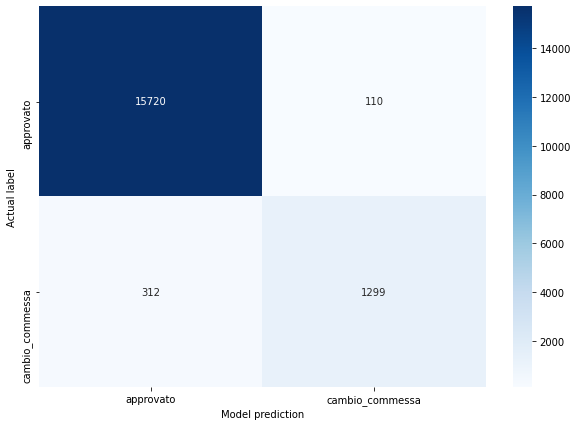

In [ ]:
# Training set
conf_mat = confusion_matrix(y_train_val, y_train_val_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual label')
plt.xlabel('Model prediction')
plt.show()

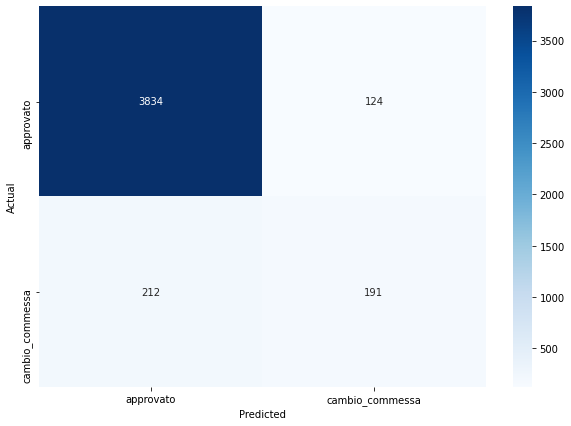

In [ ]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix_rf, metric_results_rf = metrics_results(y_test, y_test_pred_rf)
print('CLASSIFICATION METRICS')
for k in metric_results_rf:
    print(f'{k}: {metric_results_rf[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.923
Weighted accuracy: 0.721
Precision: 0.606
Sensitivity: 0.474
Specificity: 0.969
MCC: 0.495
F-score: 0.532


#### Best model - balanced accuracy

In [ ]:
# Val_acc = 0.876, Val_bal_acc = 0.831 -> max_features = 4935, n_max = 2, vect_type = cv, approach = mid, reg_term = 1, max_iter = 8192

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, 4935, 1, 2, 'cv')
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, 'mid')


model_rf = LogisticRegression(max_iter = 8192, C = 1, random_state=22, solver='lbfgs', multi_class='auto')
start_time = time.time()
model_rf.fit(X_train_val_v_r, y_train_val_r)
run_time_rf_fit = (time.time() - start_time)

start_time = time.time()
y_train_val_pred_rf = model_rf.predict(X_train_val_v_r)
y_test_pred_rf = model_rf.predict(X_test_v)
run_time_rf_predict = (time.time() - start_time)

In [ ]:
train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
test_acc_rf = accuracy(y_test_pred_rf, y_test)
test_bacc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy on training + validation set: {train_acc_rf}')
print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
print(f'Test accuracy: {test_acc_rf}')
print(f'Test balanced accuracy: {test_bacc_rf}')

Accuracy on training + validation set: 0.9556022198890055
Balanced accuracy on training + validation set: 0.9556022198890055
Test accuracy: 0.8734235267140564
Test balanced accuracy: 0.8132591340589841


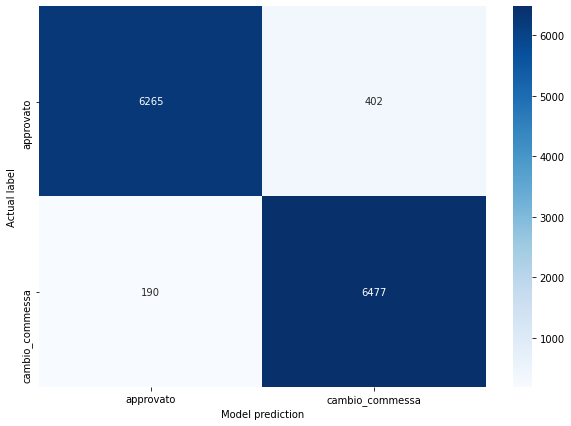

In [ ]:
# Training set
conf_mat = confusion_matrix(y_train_val_r, y_train_val_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual label')
plt.xlabel('Model prediction')
plt.show()

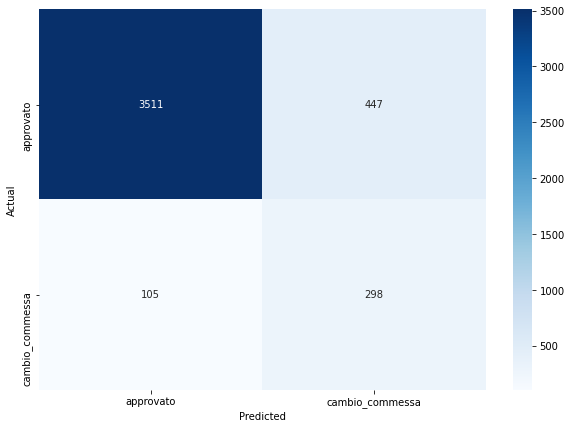

In [ ]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix_rf, metric_results_rf = metrics_results(y_test, y_test_pred_rf)
print('CLASSIFICATION METRICS')
for k in metric_results_rf:
    print(f'{k}: {metric_results_rf[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.873
Weighted accuracy: 0.813
Precision: 0.4
Sensitivity: 0.739
Specificity: 0.887
MCC: 0.482
F-score: 0.519


## KNN

In [ ]:
max_features_v = [250, 500, 1000, 2703, 3725, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
vect_type_v = ['cv', 'tfidf']
approach_v = ['none', 'over', 'under', 'mid']
n_neighbors_v = [1, 2, 3, 5, 10, 20, 30, 50]

results = []

# RANDOM SEARCH
random.seed(22)
pbar = tq.tqdm(total = 20, desc = 'Random search progress')
random_coarse_grid = list(itertools.product(max_features_v, n_max_v, vect_type_v, approach_v, n_neighbors_v))
for (max_features, n_max, vect_type, approach, k) in random.sample(random_coarse_grid, 20):
    # sampling combinations from itertools.product, we are sure no combination is repeated
    print(f'max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type},' 
          f' approach = {approach}, k = {k}')

    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)


    model_knn = KNeighborsClassifier(n_neighbors = k, n_jobs=-1)
    model_knn.fit(X_train_v_r, y_train_r)
    y_train_pred = model_knn.predict(X_train_v_r)
    y_valid_pred = model_knn.predict(X_val_v)

    acc = accuracy(y_train_r, y_train_pred)
    bacc = balanced_accuracy_score(y_train_r, y_train_pred)
    acc_v = accuracy(y_val, y_valid_pred)
    bacc_v = balanced_accuracy_score(y_val, y_valid_pred)

    print(f'Training acc = {acc:.3f}, Training b_acc = {bacc:.3f}, Validation acc = {acc_v:.3f}, Validation b_acc = {bacc_v:.3f}')
    print()

    results.append((np.round(acc_v, 3), np.round(bacc_v, 3), f'max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type},' 
          f' approach = {approach}, k = {k}'))
    
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.3f}, Val_bal_acc = {r[1]:.3f} -> {r[2]}')
print()

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.3f}, Val_bal_acc = {r[1]:.3f} -> {r[2]}')

max_features = 500, n_max = 2, vect_type = cv, approach = mid, k = 50
Training acc = 0.684, Training b_acc = 0.684, Validation acc = 0.628, Validation b_acc = 0.638

max_features = 1000, n_max = 2, vect_type = tfidf, approach = under, k = 1
Training acc = 1.000, Training b_acc = 1.000, Validation acc = 0.617, Validation b_acc = 0.667

max_features = 250, n_max = 1, vect_type = tfidf, approach = under, k = 1
Training acc = 1.000, Training b_acc = 1.000, Validation acc = 0.619, Validation b_acc = 0.668

max_features = 3725, n_max = 3, vect_type = cv, approach = under, k = 5
Training acc = 0.788, Training b_acc = 0.788, Validation acc = 0.632, Validation b_acc = 0.641

max_features = 500, n_max = 3, vect_type = tfidf, approach = mid, k = 2
Training acc = 0.997, Training b_acc = 0.997, Validation acc = 0.833, Validation b_acc = 0.687

max_features = 500, n_max = 1, vect_type = tfidf, approach = under, k = 30
Training acc = 0.639, Training b_acc = 0.639, Validation acc = 0.588, Validation b

#### Best model - accuracy

In [ ]:
# Val_acc = 0.909, Val_bal_acc = 0.558 -> max_features = 2703, n_max = 3, vect_type = cv, approach = none, k = 5

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, 2703, 1, 3, 'cv')
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, 'none')

model_rf = KNeighborsClassifier(n_neighbors = 5, n_jobs=-1)
start_time = time.time()
model_rf.fit(X_train_val_v_r, y_train_val_r)
run_time_rf_fit = (time.time() - start_time)

start_time = time.time()
y_train_val_pred_rf = model_rf.predict(X_train_val_v_r)
y_test_pred_rf = model_rf.predict(X_test_v)
run_time_rf_predict = (time.time() - start_time)

In [ ]:
train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
test_acc_rf = accuracy(y_test_pred_rf, y_test)
test_bacc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy on training + validation set: {train_acc_rf}')
print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
print(f'Test accuracy: {test_acc_rf}')
print(f'Test balanced accuracy: {test_bacc_rf}')

Accuracy on training + validation set: 0.9308525887277106
Balanced accuracy on training + validation set: 0.6516249230946591
Test accuracy: 0.9105709699610182
Test balanced accuracy: 0.5651612401681678


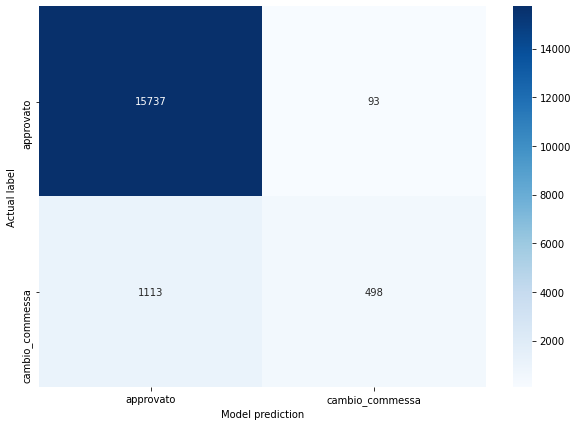

In [ ]:
# Training set
conf_mat = confusion_matrix(y_train_val_r, y_train_val_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual label')
plt.xlabel('Model prediction')
plt.show()

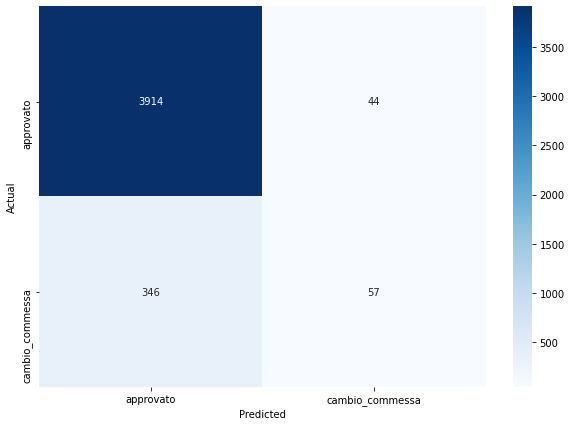

In [ ]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix_rf, metric_results_rf = metrics_results(y_test, y_test_pred_rf)
print('CLASSIFICATION METRICS')
for k in metric_results_rf:
    print(f'{k}: {metric_results_rf[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.911
Weighted accuracy: 0.565
Precision: 0.564
Sensitivity: 0.141
Specificity: 0.989
MCC: 0.251
F-score: 0.226


#### Best model - balanced accuracy

In [ ]:
# Val_acc = 0.843, Val_bal_acc = 0.715 -> max_features = 4935, n_max = 3, vect_type = tfidf, approach = over, k = 3

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, 4935, 1, 3, 'tfidf')
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, 'over')


model_rf = KNeighborsClassifier(n_neighbors = 3, n_jobs=-1)
start_time = time.time()
model_rf.fit(X_train_val_v_r, y_train_val_r)
run_time_rf_fit = (time.time() - start_time)

start_time = time.time()
y_train_val_pred_rf = model_rf.predict(X_train_val_v_r)
y_test_pred_rf = model_rf.predict(X_test_v)
run_time_rf_predict = (time.time() - start_time)

In [ ]:
train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
test_acc_rf = accuracy(y_test_pred_rf, y_test)
test_bacc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy on training + validation set: {train_acc_rf}')
print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
print(f'Test accuracy: {test_acc_rf}')
print(f'Test balanced accuracy: {test_bacc_rf}')

Accuracy on training + validation set: 0.9709096651926722
Balanced accuracy on training + validation set: 0.9709096651926721
Test accuracy: 0.8546204998853474
Test balanced accuracy: 0.7215514766086089


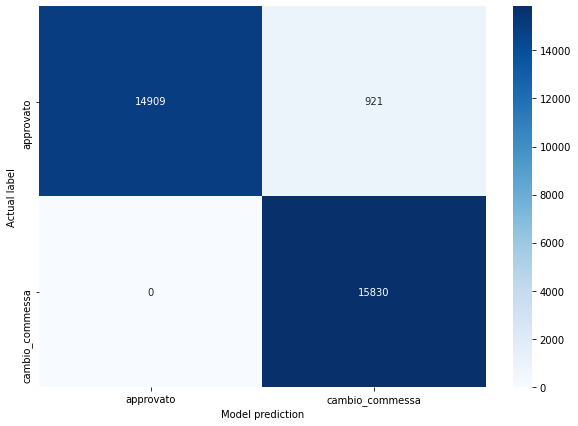

In [ ]:
# Training set
conf_mat = confusion_matrix(y_train_val_r, y_train_val_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual label')
plt.xlabel('Model prediction')
plt.show()

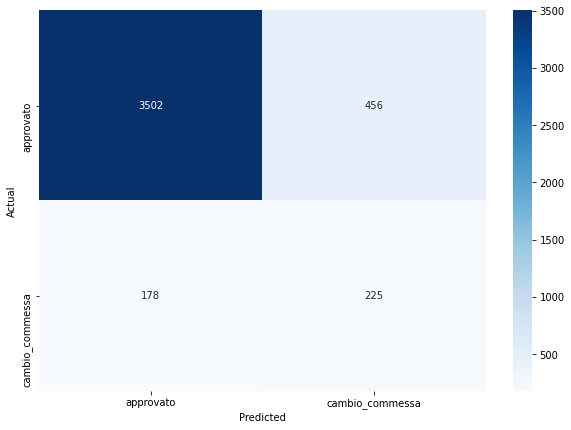

In [ ]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix_rf, metric_results_rf = metrics_results(y_test, y_test_pred_rf)
print('CLASSIFICATION METRICS')
for k in metric_results_rf:
    print(f'{k}: {metric_results_rf[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.855
Weighted accuracy: 0.722
Precision: 0.33
Sensitivity: 0.558
Specificity: 0.885
MCC: 0.354
F-score: 0.415


## SVM

In [ ]:
max_features_v = [250, 500, 1000, 1900, 2703, 3725, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
vect_type_v = ['cv', 'tfidf']
approach_v = ['none', 'over', 'under', 'mid']
C_v = [0.01, 0.1, 1, 10, 50, 100]
kernel_v = ['linear', 'poly', 'sigmoid', 'rbf']

results = []

# RANDOM SEARCH
random.seed(22)
pbar = tq.tqdm(total = 20, desc = 'Random search progress')
random_coarse_grid = list(itertools.product(max_features_v, n_max_v, vect_type_v, approach_v, C_v, kernel_v))
for (max_features, n_max, vect_type, approach, C, kernel) in random.sample(random_coarse_grid, 20):
    # sampling combinations from itertools.product, we are sure no combination is repeated
    print(f'max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type},' 
          f' approach = {approach}, C = {C}, kernel = {kernel}')

    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)


    model_svm = SVC(kernel=kernel, C = C, gamma='scale')
    model_svm.fit(X_train_v_r, y_train_r)
    y_train_pred = model_svm.predict(X_train_v_r)
    y_valid_pred = model_svm.predict(X_val_v)

    acc = accuracy(y_train_r, y_train_pred)
    bacc = balanced_accuracy_score(y_train_r, y_train_pred)
    acc_v = accuracy(y_val, y_valid_pred)
    bacc_v = balanced_accuracy_score(y_val, y_valid_pred)

    print(f'Training acc = {acc:.3f}, Training b_acc = {bacc:.3f}, Validation acc = {acc_v:.3f}, Validation b_acc = {bacc_v:.3f}')
    print()

    results.append((np.round(acc_v, 3), np.round(bacc_v, 3), f'max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type},' 
          f' approach = {approach}, C = {C}, kernel = {kernel}'))
    
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.3f}, Val_bal_acc = {r[1]:.3f} -> {r[2]}')
print()

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.3f}, Val_bal_acc = {r[1]:.3f} -> {r[2]}')

max_features = 4935, n_max = 3, vect_type = cv, approach = mid, C = 10, kernel = linear
Training acc = 0.987, Training b_acc = 0.986, Validation acc = 0.861, Validation b_acc = 0.771

max_features = 4935, n_max = 2, vect_type = cv, approach = under, C = 100, kernel = linear
Training acc = 0.993, Training b_acc = 0.993, Validation acc = 0.742, Validation b_acc = 0.751

max_features = 250, n_max = 3, vect_type = tfidf, approach = mid, C = 100, kernel = sigmoid
Training acc = 0.454, Training b_acc = 0.454, Validation acc = 0.441, Validation b_acc = 0.432

max_features = 500, n_max = 3, vect_type = cv, approach = over, C = 1, kernel = poly
Training acc = 0.590, Training b_acc = 0.590, Validation acc = 0.771, Validation b_acc = 0.584

max_features = 250, n_max = 1, vect_type = tfidf, approach = none, C = 0.01, kernel = linear
Training acc = 0.908, Training b_acc = 0.500, Validation acc = 0.908, Validation b_acc = 0.500

max_features = 2703, n_max = 2, vect_type = cv, approach = none, C = 10

#### Best model - accuracy

In [ ]:
# Val_acc = 0.908, Val_bal_acc = 0.500 -> max_features = 250, n_max = 1, vect_type = tfidf, approach = none, C = 0.01, kernel = linear

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, 250, 1, 1, 'tfidf')
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, 'none')


model_rf = SVC(kernel='linear', C = 0.01, gamma='scale')
start_time = time.time()
model_rf.fit(X_train_val_v_r, y_train_val_r)
run_time_rf_fit = (time.time() - start_time)

start_time = time.time()
y_train_val_pred_rf = model_rf.predict(X_train_val_v_r)
y_test_pred_rf = model_rf.predict(X_test_v)
run_time_rf_predict = (time.time() - start_time)

In [ ]:
train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
test_acc_rf = accuracy(y_test_pred_rf, y_test)
test_bacc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy on training + validation set: {train_acc_rf}')
print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
print(f'Test accuracy: {test_acc_rf}')
print(f'Test balanced accuracy: {test_bacc_rf}')

Accuracy on training + validation set: 0.9082048047703687
Balanced accuracy on training + validation set: 0.5031036623215395
Test accuracy: 0.9080486127035083
Test balanced accuracy: 0.5024813895781638


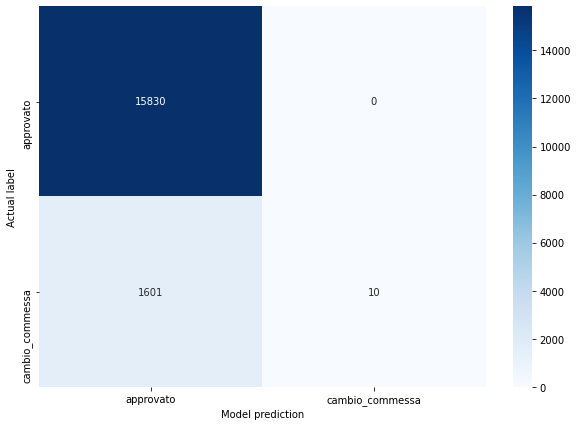

In [ ]:
# Training set
conf_mat = confusion_matrix(y_train_val_r, y_train_val_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual label')
plt.xlabel('Model prediction')
plt.show()

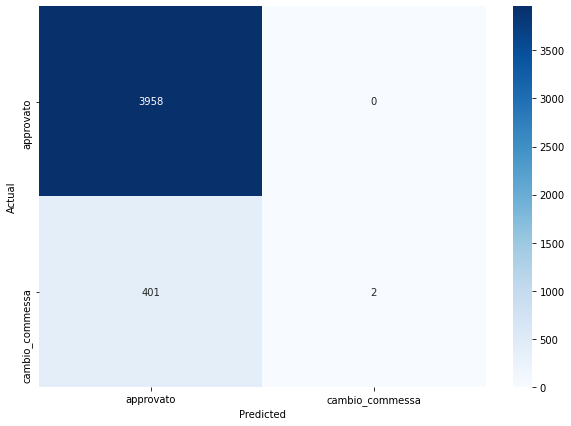

In [ ]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix_rf, metric_results_rf = metrics_results(y_test, y_test_pred_rf)
print('CLASSIFICATION METRICS')
for k in metric_results_rf:
    print(f'{k}: {metric_results_rf[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.908
Weighted accuracy: 0.502
Precision: 1.0
Sensitivity: 0.00496
Specificity: 1.0
MCC: 0.0671
F-score: 0.00988


#### Best model - balanced accuracy

In [ ]:
# max_features = 2703, n_max = 2, vect_type = tfidf, approach = mid, C = 0.1, kernel = linear
# Training acc = 0.877, Training b_acc = 0.877, Validation acc = 0.828, Validation b_acc = 0.814

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, 2703, 1, 2, 'tfidf')
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, 'mid')


model_rf = SVC(kernel='linear', C = 0.1, gamma='scale')
start_time = time.time()
model_rf.fit(X_train_val_v_r, y_train_val_r)
run_time_rf_fit = (time.time() - start_time)

start_time = time.time()
y_train_val_pred_rf = model_rf.predict(X_train_val_v_r)
y_test_pred_rf = model_rf.predict(X_test_v)
run_time_rf_predict = (time.time() - start_time)

In [ ]:
train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
test_acc_rf = accuracy(y_test_pred_rf, y_test)
test_bacc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy on training + validation set: {train_acc_rf}')
print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
print(f'Test accuracy: {test_acc_rf}')
print(f'Test balanced accuracy: {test_bacc_rf}')

Accuracy on training + validation set: 0.8838308084595771
Balanced accuracy on training + validation set: 0.8838308084595771
Test accuracy: 0.8426966292134831
Test balanced accuracy: 0.8397917588776446


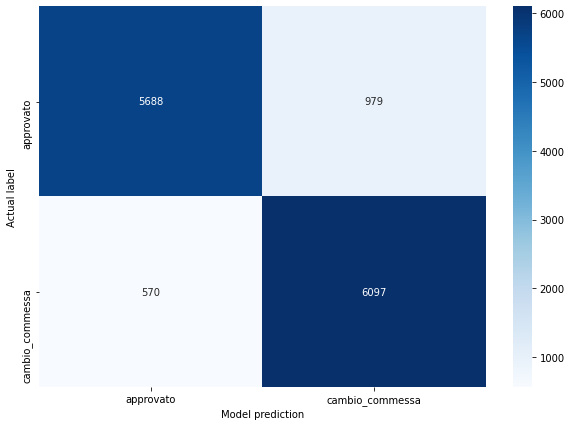

In [ ]:
# Training set
conf_mat = confusion_matrix(y_train_val_r, y_train_val_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual label')
plt.xlabel('Model prediction')
plt.show()

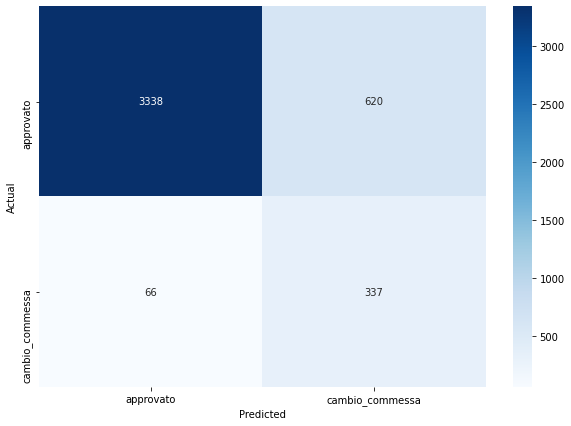

In [ ]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix_rf, metric_results_rf = metrics_results(y_test, y_test_pred_rf)
print('CLASSIFICATION METRICS')
for k in metric_results_rf:
    print(f'{k}: {metric_results_rf[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.843
Weighted accuracy: 0.84
Precision: 0.352
Sensitivity: 0.836
Specificity: 0.843
MCC: 0.476
F-score: 0.496


## Gradient Boosting

In [ ]:
max_features_v = [250, 500, 1000, 1900, 2703, 3725, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
vect_type_v = ['cv', 'tfidf']
approach_v = ['none', 'over', 'under', 'mid']
n_estimator_v = [1, 10, 50, 100]
max_depth_v = [10, 50, 100]

results = []

# RANDOM SEARCH
random.seed(22)
pbar = tq.tqdm(total = 20, desc = 'Random search progress')
random_coarse_grid = list(itertools.product(max_features_v, n_max_v, vect_type_v, approach_v, n_estimator_v, max_depth_v))
for (max_features, n_max, vect_type, approach, n_estimator, max_depth) in random.sample(random_coarse_grid, 20):
    # sampling combinations from itertools.product, we are sure no combination is repeated
    print(f'max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type},' 
          f' approach = {approach}, n_estimator = {n_estimator}, max_depth = {max_depth}')

    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

    model_gb = GradientBoostingClassifier(n_estimators = n_estimator, max_depth = max_depth, random_state = 22)
    model_gb.fit(X_train_v_r, y_train_r)
    y_train_pred = model_gb.predict(X_train_v_r)
    y_valid_pred = model_gb.predict(X_val_v)

    acc = accuracy(y_train_r, y_train_pred)
    bacc = balanced_accuracy_score(y_train_r, y_train_pred)
    acc_v = accuracy(y_val, y_valid_pred)
    bacc_v = balanced_accuracy_score(y_val, y_valid_pred)

    print(f'Training acc = {acc:.3f}, Training b_acc = {bacc:.3f}, Validation acc = {acc_v:.3f}, Validation b_acc = {bacc_v:.3f}')
    print()

    results.append((np.round(acc_v, 3), np.round(bacc_v, 3), f'max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type},' 
          f' approach = {approach}, n_estimator = {n_estimator}, max_depth = {max_depth}'))
    
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.3f}, Val_bal_acc = {r[1]:.3f} -> {r[2]}')
print()

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.3f}, Val_bal_acc = {r[1]:.3f} -> {r[2]}')

max_features = 4935, n_max = 3, vect_type = cv, approach = mid, n_estimator = 50, max_depth = 10
Training acc = 0.951, Training b_acc = 0.951, Validation acc = 0.899, Validation b_acc = 0.835

max_features = 4935, n_max = 2, vect_type = cv, approach = under, n_estimator = 100, max_depth = 50
Training acc = 1.000, Training b_acc = 1.000, Validation acc = 0.841, Validation b_acc = 0.819

max_features = 250, n_max = 3, vect_type = tfidf, approach = mid, n_estimator = 100, max_depth = 100
Training acc = 1.000, Training b_acc = 1.000, Validation acc = 0.889, Validation b_acc = 0.787

max_features = 500, n_max = 3, vect_type = cv, approach = over, n_estimator = 10, max_depth = 50
Training acc = 0.994, Training b_acc = 0.994, Validation acc = 0.918, Validation b_acc = 0.811

max_features = 250, n_max = 1, vect_type = tfidf, approach = none, n_estimator = 1, max_depth = 10
Training acc = 0.908, Training b_acc = 0.500, Validation acc = 0.908, Validation b_acc = 0.500

max_features = 2703, n_max

#### Best model - accuracy

In [ ]:
# Val_acc = 0.942, Val_bal_acc = 0.777 -> max_features = 2703, n_max = 2, vect_type = cv, approach = none, n_estimator = 50, max_depth = 50

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, 2703, 1, 2, 'cv')
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, 'none')


model_rf = GradientBoostingClassifier(n_estimators = 50, max_depth = 50, random_state = 22)
start_time = time.time()
model_rf.fit(X_train_val_v_r, y_train_val_r)
run_time_rf_fit = (time.time() - start_time)

start_time = time.time()
y_train_val_pred_rf = model_rf.predict(X_train_val_v_r)
y_test_pred_rf = model_rf.predict(X_test_v)
run_time_rf_predict = (time.time() - start_time)

In [ ]:
train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
test_acc_rf = accuracy(y_test_pred_rf, y_test)
test_bacc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy on training + validation set: {train_acc_rf}')
print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
print(f'Test accuracy: {test_acc_rf}')
print(f'Test balanced accuracy: {test_bacc_rf}')

Accuracy on training + validation set: 0.9998279915142481
Balanced accuracy on training + validation set: 0.9990689013035381
Test accuracy: 0.9458839715661546
Test balanced accuracy: 0.7885449201729826


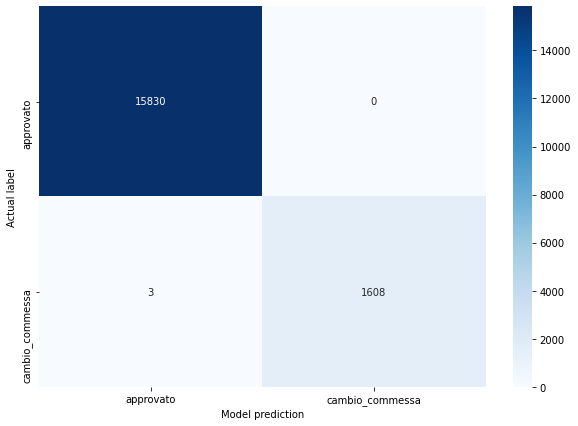

In [ ]:
# Training set
conf_mat = confusion_matrix(y_train_val_r, y_train_val_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual label')
plt.xlabel('Model prediction')
plt.show()

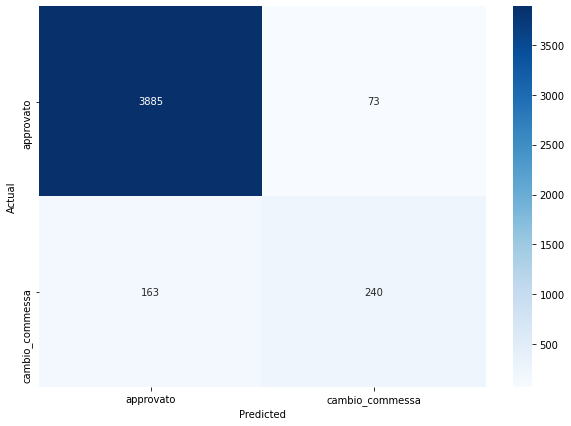

In [ ]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix_rf, metric_results_rf = metrics_results(y_test, y_test_pred_rf)
print('CLASSIFICATION METRICS')
for k in metric_results_rf:
    print(f'{k}: {metric_results_rf[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.946
Weighted accuracy: 0.789
Precision: 0.767
Sensitivity: 0.596
Specificity: 0.982
MCC: 0.648
F-score: 0.67


#### Best model - balanced accuracy

In [ ]:
# Val_acc = 0.904, Val_bal_acc = 0.840 -> max_features = 4935, n_max = 3, vect_type = cv, approach = mid, n_estimator = 100, max_depth = 10

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, 4935, 1, 3, 'cv')
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, 'mid')


model_rf = GradientBoostingClassifier(n_estimators = 100, max_depth = 10, random_state = 22)
start_time = time.time()
model_rf.fit(X_train_val_v_r, y_train_val_r)
run_time_rf_fit = (time.time() - start_time)

start_time = time.time()
y_train_val_pred_rf = model_rf.predict(X_train_val_v_r)
y_test_pred_rf = model_rf.predict(X_test_v)
run_time_rf_predict = (time.time() - start_time)

In [ ]:
train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
test_acc_rf = accuracy(y_test_pred_rf, y_test)
test_bacc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
print(f'Accuracy on training + validation set: {train_acc_rf}')
print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
print(f'Test accuracy: {test_acc_rf}')
print(f'Test balanced accuracy: {test_bacc_rf}')

Accuracy on training + validation set: 0.9637018149092546
Balanced accuracy on training + validation set: 0.9637018149092546
Test accuracy: 0.905984865856455
Test balanced accuracy: 0.8612854325253876


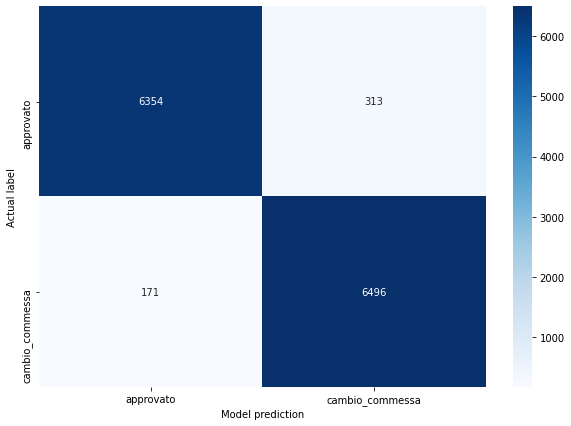

In [ ]:
# Training set
conf_mat = confusion_matrix(y_train_val_r, y_train_val_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual label')
plt.xlabel('Model prediction')
plt.show()

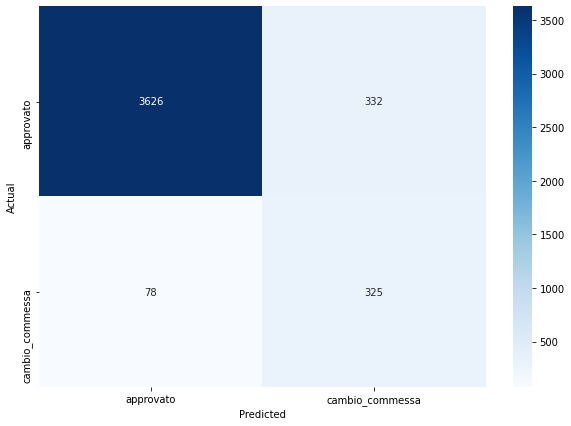

In [ ]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix_rf, metric_results_rf = metrics_results(y_test, y_test_pred_rf)
print('CLASSIFICATION METRICS')
for k in metric_results_rf:
    print(f'{k}: {metric_results_rf[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.906
Weighted accuracy: 0.861
Precision: 0.495
Sensitivity: 0.806
Specificity: 0.916
MCC: 0.585
F-score: 0.613


## FFNN

#### speed up startup 

In [ ]:
data8 = pd.read_csv(datapath + 'dataset/data8.csv')
data = data8[['cleaned_workdesc', 'tipo_update']]
data = data[~ data.cleaned_workdesc.isna()]
data

def split_data(X, y):
    # Divide the dataset into training, validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, 
                                                                random_state=22, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=22, stratify=y_train_val)

    print("Training Set shape: {}".format(X_train.shape))
    print("Validation Set shape: {}".format(X_val.shape))
    print("Training + Validation Set shape: {}".format(X_train_val.shape))
    print("Test Set shape: {}".format(X_test.shape))

    return X_train, y_train, X_val, X_test, y_val, y_test, X_train_val, y_train_val

def vectorizer(X_train, X_val, X_test, max_features=1000, n_min=1, n_max=1, vect_type='cv'):
    if vect_type == 'cv':
        vect = CountVectorizer(
            max_features = max_features,
            ngram_range = (n_min, n_max),     # (1,1) means only unigrams, (1,2) means unigrams and bigrams, (2,2) only bigrams
            )
        
    if vect_type == 'tfidf':
         vect = TfidfVectorizer(
            max_features = max_features,
            ngram_range = (n_min, n_max),     # (1,1) means only unigrams, (1,2) means unigrams and bigrams, (2,2) only bigrams
            )

    X_train_v = vect.fit_transform(X_train)
    X_val_v = vect.transform(X_val)
    X_test_v = vect.transform(X_test)
    return X_train_v, X_val_v, X_test_v, vect

def resampling(X_train_v, y_train, approach='none'):
    # summarize class distribution
    # print(Counter(y_train))
    
    if approach == 'over':
        # define oversampling strategy
        resample = RandomOverSampler(sampling_strategy='minority', random_state=1)
    
    if approach == 'under':
        # define undersample strategy
        resample = RandomUnderSampler(sampling_strategy='majority', random_state=1)

    if approach == 'mid':
        resample = RandomOverSampler(sampling_strategy=0.4212, random_state=1)
        # resample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
        X_train_v_r, y_train_r = resample.fit_resample(X_train_v, y_train)
        resample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
        X_train_v_r, y_train_r = resample.fit_resample(X_train_v_r, y_train_r)
        return X_train_v_r, y_train_r

    if approach == 'none':
        return X_train_v, y_train

    # fit and apply the transform
    X_train_v_r, y_train_r = resample.fit_resample(X_train_v, y_train)
    # summarize class distribution
    # print(Counter(y_train_r)) 

    return X_train_v_r, y_train_r

X_train, y_train, X_val, X_test, y_val, y_test, X_train_val, y_train_val = split_data(data.cleaned_workdesc, data.tipo_update)

In [ ]:
class MyDataset(Dataset):

  def __init__(self, features, labels, transform=None):
    """
    Args:
        dataframe (pandas DataFrame): dataframe object.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform

    self.data = np.array(features.todense())
    self.label = np.array(labels)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample_data = self.data[idx]
    sample_label = self.label[idx]
    sample = (sample_data, sample_label)
    if self.transform:
        sample = self.transform(sample)
    return sample
    
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):

        x, y = sample
        return (torch.Tensor([x]).float()[0],
                torch.Tensor([y]).long()[0])
        
composed_transform = transforms.Compose([ToTensor()])

class FCNet(nn.Module):
    
    def __init__(self, Ni, Nh, No, hidden_layers, activation, reg):
                  
        # pdrop1=0, pdrop2=0, pdrop3=0, pdrop4=0, pdrop5=0
        # pdropi - dropout probability after layer i
        
        """
        Ni - Input size
        Nh - Neurons in each hidden layer
        No - Output size
        hidden_layers - number of hidden layers (1<=HL<=5)
        activation - activation function
        reg - regularization approach
        """
        super().__init__()
        
        self.HL = hidden_layers
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh) # fully connected 1
        if self.HL >= 2: self.fc2 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 2
        if self.HL >= 3: self.fc3 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 3
        if self.HL >= 4: self.fc4 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 4
        if self.HL >= 5: self.fc5 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 5
        if self.HL >= 6: self.fc6 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 6
        if self.HL >= 7: self.fc7 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 7
        if self.HL == 8: self.fc8 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 8
        self.out = nn.Linear(in_features=Nh, out_features=No) # output
        
        self.reg = reg

        if self.reg == 'Dropout':
            self.drop1 = nn.Dropout(0.4)
            if self.HL >= 2: self.drop2 = nn.Dropout(0.3)
            if self.HL >= 3: self.drop3 = nn.Dropout(0.3)
            if self.HL >= 4: self.drop4 = nn.Dropout(0.2)
            if self.HL >= 5: self.drop5 = nn.Dropout(0.2)
            if self.HL >= 6: self.drop6 = nn.Dropout(0.2)
            if self.HL >= 7: self.drop7 = nn.Dropout(0.2)
            if self.HL == 8: self.drop8 = nn.Dropout(0.2)
        
        elif self.reg == 'Batch norm':
            self.batch1 = nn.BatchNorm1d(Nh)
            if self.HL >= 2: self.batch2 = nn.BatchNorm1d(Nh)
            if self.HL >= 3: self.batch3 = nn.BatchNorm1d(Nh)
            if self.HL >= 4: self.batch4 = nn.BatchNorm1d(Nh)
            if self.HL >= 5: self.batch5 = nn.BatchNorm1d(Nh)
            if self.HL >= 6: self.batch6 = nn.BatchNorm1d(Nh)
            if self.HL >= 7: self.batch7 = nn.BatchNorm1d(Nh)
            if self.HL == 8: self.batch8 = nn.BatchNorm1d(Nh)

        self.act = activation # activation

    def forward(self, x, additional_out=False):

        x = torch.flatten(x, 1)

        if self.reg == 'Dropout':
            x = self.act(self.drop1(self.fc1(x)))
            if self.HL >= 2: x = self.act(self.drop2(self.fc2(x)))
            if self.HL >= 3: x = self.act(self.drop3(self.fc3(x)))
            if self.HL >= 4: x = self.act(self.drop4(self.fc4(x)))
            if self.HL >= 5: x = self.act(self.drop5(self.fc5(x)))
            if self.HL >= 6: x = self.act(self.drop6(self.fc6(x)))
            if self.HL >= 7: x = self.act(self.drop7(self.fc7(x)))
            if self.HL == 8: x = self.act(self.drop8(self.fc8(x)))

        elif self.reg == 'Batch norm':
            x = self.act(self.batch1(self.fc1(x)))
            if self.HL >= 2: x = self.act(self.batch2(self.fc2(x)))
            if self.HL >= 3: x = self.act(self.batch3(self.fc3(x)))
            if self.HL >= 4: x = self.act(self.batch4(self.fc4(x)))
            if self.HL >= 5: x = self.act(self.batch5(self.fc5(x)))
            if self.HL >= 6: x = self.act(self.batch6(self.fc6(x)))
            if self.HL >= 7: x = self.act(self.batch7(self.fc7(x)))
            if self.HL == 8: x = self.act(self.batch8(self.fc8(x)))

        else: 
            x = self.act(self.fc1(x))
            if self.HL >= 2: x = self.act(self.fc2(x))
            if self.HL >= 3: x = self.act(self.fc3(x))
            if self.HL >= 4: x = self.act(self.fc4(x))
            if self.HL >= 5: x = self.act(self.fc5(x))
            if self.HL >= 6: x = self.act(self.fc6(x))
            if self.HL >= 7: x = self.act(self.fc7(x))
            if self.HL == 8: x = self.act(self.fc8(x))

        x = self.out(x)
        return x

# sample = next(iter(dataloader))
# sample = sample[0]
# print(sample.shape)

# torch.manual_seed(0)
# net = FCNet(4935, 32, 2, 3, nn.Sigmoid(), False)
# out = net(sample)
# print(out.shape)

def training_loop(net, train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch, patience = 5):
    # ----------- TRAINING LOOP -----------
    train_loss_log, val_loss_log = [], []
    train_accuracy_log, val_accuracy_log = [], []
    best_loss = 1e100

    for epoch_num in tq.tqdm(range(num_epochs), desc = f'Training'):
        #   for epoch_num in range(num_epochs):

        # ----------- TRAIN -----------
        train_loss= []
        all_outputs, all_labels = [], []
        net.train() # Training mode (e.g. enable dropout, and all other stochastic behaviours)
        for sample_batched in train_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_function(out, label_batch)

            # Backpropagation
            net.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss and output for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            all_outputs.append(out)
            all_labels.append(label_batch)

        train_accuracy = accuracy(all_outputs, all_labels)
        # print(train_accuracy)
        train_accuracy_log.append(train_accuracy)

        # Save average train loss
        train_loss = np.mean(train_loss)
        # print(f"AVERAGE TRAIN LOSS: {train_loss}")
        train_loss_log.append(train_loss)
        

        # ----------- VALIDATION -----------
        val_loss, all_outputs_v, all_labels_v = validation(val_dataloader, net)
        # print(val_loss)
        val_loss_log.append(val_loss)

        val_accuracy = accuracy(all_outputs_v, all_labels_v)
        bacc = balanced_accuracy_net(all_outputs_v, all_labels_v)
        # print(val_accuracy)
        val_accuracy_log.append(val_accuracy)
            

        # ----------- EARLY STOPPING -----------
        # print(best_loss, val_loss, no_improve_epoch)
        if val_loss < best_loss:
            best_loss = val_loss # Update the best value so far
            corresponding_train_loss = train_loss
            corresponding_val_acc = val_accuracy
            corresponding_bacc = bacc
            corresponding_train_acc = train_accuracy
            
            # Save the network state
            best_net = net.state_dict()
            # Save the state dict to a file
            torch.save(best_net, 'best_net.torch')
            
            no_improve_epoch = 0 # Reset number of consecutive epochs without improvement
        else:
            no_improve_epoch += 1
            if no_improve_epoch == patience:
                break
    
    # Load the state dict previously saved
    best_net = torch.load('best_net.torch')
    # Update the network parameters
    net.load_state_dict(best_net)
    
    return train_loss_log, val_loss_log, corresponding_train_loss, best_loss, train_accuracy_log, val_accuracy_log, corresponding_train_acc, corresponding_val_acc, corresponding_bacc, net
    
def validation(val_dataloader, net):
    val_loss = []
    all_outputs_v, all_labels_v = [], []
    net.eval() # Evaluation mode (e.g. disable dropout, and all stochastic behaviours)
    with torch.no_grad(): # Disable gradient tracking during validation
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_function(out, label_batch)

            # Save val loss and the output for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
            all_outputs_v.append(out)
            all_labels_v.append(label_batch)

    # Save the validation loss of the epoch ()<average over batches
    val_loss = np.mean(val_loss)
    return val_loss, all_outputs_v, all_labels_v

def accuracy(all_outputs, all_labels):
    # Concatenate all the outputs and labels in a single tensor
    all_outputs = torch.cat(all_outputs)
    all_labels  = torch.cat(all_labels)
    # Compute accuracy
    tot_correct_out = (all_outputs.argmax(dim=-1) == all_labels).sum()
    val_accuracy = 100 * tot_correct_out / len(all_labels)
    val_accuracy = val_accuracy.detach().cpu().numpy()
    return val_accuracy

def balanced_accuracy_net(all_outputs, all_labels):
    # Concatenate all the outputs and labels in a single tensor
    all_outputs = torch.cat(all_outputs).argmax(dim=-1).cpu().numpy()
    all_labels  = torch.cat(all_labels).cpu().numpy()
    # Compute balanced accuracy
    bacc = balanced_accuracy_score(all_labels, all_outputs)
    # tot_correct_out = (all_outputs.argmax(dim=-1) == all_labels).sum()
    # val_accuracy = 100 * tot_correct_out / len(all_labels)
    bacc = bacc #.detach().cpu().numpy()
    return bacc

def plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log):
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    ax[0].plot(train_loss_log, label='Train loss')
    ax[0].plot(val_loss_log, label='Validation loss') # semilogy
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Learning curves - Loss')
    ax[0].grid()
    ax[0].legend()

    # plt.figure(figsize=(8,5))
    ax[1].plot(train_accuracy_log, label='Training accuracy')
    ax[1].plot(val_accuracy_log, label='Validation accuracy') # semilogy
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Learning curves - Accuracy')
    ax[1].grid()
    ax[1].legend()

    plt.show()

In [ ]:
# X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
# X_train_v_r, y_train_r = resampling(X_train_v, y_train, 'none')

In [ ]:
X_train_v_r

<13080x4935 sparse matrix of type '<class 'numpy.float64'>'
	with 72904 stored elements in Compressed Sparse Row format>

In [ ]:
y_train_r

18259    0
21       0
883      0
9442     0
8582     0
        ..
13825    0
7027     0
2311     0
5180     0
1242     0
Name: tipo_update, Length: 13080, dtype: int64

In [ ]:
m = np.array(X_train_v_r.todense())
m.shape

(13080, 4935)

In [ ]:
m[0].shape

(4935,)

In [ ]:
np.sum(m[0])

2.345588306206451

In [ ]:
v = np.array(y_train_r)
# v = v.reshape(-1,1)
# v.shape

In [ ]:
v[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
np.hstack((m,v)).shape

(13080, 4936)

In [ ]:
np.array([[m], [v.T]]).shape

(2, 1)

In [ ]:
class MyDataset(Dataset):

  def __init__(self, features, labels, transform=None):
    """
    Args:
        dataframe (pandas DataFrame): dataframe object.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform

    self.data = np.array(features.todense())
    self.label = np.array(labels)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample_data = self.data[idx]
    sample_label = self.label[idx]
    sample = (sample_data, sample_label)
    if self.transform:
        sample = self.transform(sample)
    return sample

In [ ]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):

        x, y = sample
        return (torch.Tensor([x]).float()[0],
                torch.Tensor([y]).long()[0])
        
composed_transform = transforms.Compose([ToTensor()])

In [ ]:
# dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)

In [ ]:
# dataloader = DataLoader(dataset, batch_size=250, shuffle=False, num_workers=0)

In [ ]:
batch = next(iter(dataloader))
features, label = batch[0], batch[1]

print(f"Data shape: {features.shape})")
print(f"Label shape: {label.shape})")

print('First sample in batch number 1:')
print('Features =', features[0])
print('Label =', label[0])

### Network architecture

In [ ]:
class FCNet(nn.Module):
    
    def __init__(self, Ni, Nh, No, hidden_layers, activation, reg):
                  
        # pdrop1=0, pdrop2=0, pdrop3=0, pdrop4=0, pdrop5=0
        # pdropi - dropout probability after layer i
        
        """
        Ni - Input size
        Nh - Neurons in each hidden layer
        No - Output size
        hidden_layers - number of hidden layers (1<=HL<=5)
        activation - activation function
        reg - regularization approach
        """
        super().__init__()
        
        self.HL = hidden_layers
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh) # fully connected 1
        if self.HL >= 2: self.fc2 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 2
        if self.HL >= 3: self.fc3 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 3
        if self.HL >= 4: self.fc4 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 4
        if self.HL >= 5: self.fc5 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 5
        if self.HL >= 6: self.fc6 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 6
        if self.HL >= 7: self.fc7 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 7
        if self.HL == 8: self.fc8 = nn.Linear(in_features=Nh, out_features=Nh) # fully connected 8
        self.out = nn.Linear(in_features=Nh, out_features=No) # output
        
        self.reg = reg

        if self.reg == 'Dropout':
            self.drop1 = nn.Dropout(0.4)
            if self.HL >= 2: self.drop2 = nn.Dropout(0.3)
            if self.HL >= 3: self.drop3 = nn.Dropout(0.3)
            if self.HL >= 4: self.drop4 = nn.Dropout(0.2)
            if self.HL >= 5: self.drop5 = nn.Dropout(0.2)
            if self.HL >= 6: self.drop6 = nn.Dropout(0.2)
            if self.HL >= 7: self.drop7 = nn.Dropout(0.2)
            if self.HL == 8: self.drop8 = nn.Dropout(0.2)
        
        elif self.reg == 'Batch norm':
            self.batch1 = nn.BatchNorm1d(Nh)
            if self.HL >= 2: self.batch2 = nn.BatchNorm1d(Nh)
            if self.HL >= 3: self.batch3 = nn.BatchNorm1d(Nh)
            if self.HL >= 4: self.batch4 = nn.BatchNorm1d(Nh)
            if self.HL >= 5: self.batch5 = nn.BatchNorm1d(Nh)
            if self.HL >= 6: self.batch6 = nn.BatchNorm1d(Nh)
            if self.HL >= 7: self.batch7 = nn.BatchNorm1d(Nh)
            if self.HL == 8: self.batch8 = nn.BatchNorm1d(Nh)

        self.act = activation # activation

    def forward(self, x, additional_out=False):

        x = torch.flatten(x, 1)

        if self.reg == 'Dropout':
            x = self.act(self.drop1(self.fc1(x)))
            if self.HL >= 2: x = self.act(self.drop2(self.fc2(x)))
            if self.HL >= 3: x = self.act(self.drop3(self.fc3(x)))
            if self.HL >= 4: x = self.act(self.drop4(self.fc4(x)))
            if self.HL >= 5: x = self.act(self.drop5(self.fc5(x)))
            if self.HL >= 6: x = self.act(self.drop6(self.fc6(x)))
            if self.HL >= 7: x = self.act(self.drop7(self.fc7(x)))
            if self.HL == 8: x = self.act(self.drop8(self.fc8(x)))

        elif self.reg == 'Batch norm':
            x = self.act(self.batch1(self.fc1(x)))
            if self.HL >= 2: x = self.act(self.batch2(self.fc2(x)))
            if self.HL >= 3: x = self.act(self.batch3(self.fc3(x)))
            if self.HL >= 4: x = self.act(self.batch4(self.fc4(x)))
            if self.HL >= 5: x = self.act(self.batch5(self.fc5(x)))
            if self.HL >= 6: x = self.act(self.batch6(self.fc6(x)))
            if self.HL >= 7: x = self.act(self.batch7(self.fc7(x)))
            if self.HL == 8: x = self.act(self.batch8(self.fc8(x)))

        else: 
            x = self.act(self.fc1(x))
            if self.HL >= 2: x = self.act(self.fc2(x))
            if self.HL >= 3: x = self.act(self.fc3(x))
            if self.HL >= 4: x = self.act(self.fc4(x))
            if self.HL >= 5: x = self.act(self.fc5(x))
            if self.HL >= 6: x = self.act(self.fc6(x))
            if self.HL >= 7: x = self.act(self.fc7(x))
            if self.HL == 8: x = self.act(self.fc8(x))

        x = self.out(x)
        return x

# sample = next(iter(dataloader))
# sample = sample[0]
# print(sample.shape)

# torch.manual_seed(0)
# net = FCNet(4935, 32, 2, 3, nn.Sigmoid(), False)
# out = net(sample)
# print(out.shape)

In [ ]:
class FCNetmod(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, Nh3, Nh4, Nh5, Nh6, No, hidden_layers, activation, reg):
                  
        """
        Ni - Input size
        Nh - Neurons in each hidden layer
        No - Output size
        hidden_layers - number of hidden layers (1<=HL<=5)
        activation - activation function
        reg - regularization approach
        """
        super().__init__()
        
        self.HL = hidden_layers
        self.reg = reg
        self.act = activation # activation

        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1) # fully connected 1
        self.batch1 = nn.BatchNorm1d(Nh1)
        self.Nh=Nh1
        if self.HL >= 2: 
            self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2) # fully connected 2
            self.batch2 = nn.BatchNorm1d(Nh2)
            self.Nh=Nh2
        if self.HL >= 3: 
            self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3) # fully connected 3
            self.batch3 = nn.BatchNorm1d(Nh3)
            self.Nh=Nh3
        if self.HL >= 4: 
            self.fc4 = nn.Linear(in_features=Nh3, out_features=Nh4) # fully connected 4
            self.batch4 = nn.BatchNorm1d(Nh4)
            self.Nh=Nh4
        if self.HL >= 5: 
            self.fc5 = nn.Linear(in_features=Nh4, out_features=Nh5) # fully connected 5
            self.batch5 = nn.BatchNorm1d(Nh5)
            self.Nh=Nh5
        if self.HL == 6: 
            self.fc6 = nn.Linear(in_features=Nh5, out_features=Nh6) # fully connected 6
            self.batch6 = nn.BatchNorm1d(Nh6)
            self.Nh=Nh6
        self.out = nn.Linear(in_features=self.Nh, out_features=No) # output
        

    def forward(self, x, additional_out=False):

        x = torch.flatten(x, 1)
        x = self.act(self.batch1(self.fc1(x)))
        if self.HL >= 2: x = self.act(self.batch2(self.fc2(x)))
        if self.HL >= 3: x = self.act(self.batch3(self.fc3(x)))
        if self.HL >= 4: x = self.act(self.batch4(self.fc4(x)))
        if self.HL >= 5: x = self.act(self.batch5(self.fc5(x)))
        if self.HL == 6: x = self.act(self.batch6(self.fc6(x)))

        x = self.out(x)
        return x

# sample = next(iter(dataloader))
# sample = sample[0]
# print(sample.shape)

# torch.manual_seed(0)
# net = FCNet(4935, 32, 2, 3, nn.Sigmoid(), False)
# out = net(sample)
# print(out.shape)

### Training Loop

In [ ]:
def training_loop(net, train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch, patience = 5):
    # ----------- TRAINING LOOP -----------
    train_loss_log, val_loss_log = [], []
    train_accuracy_log, val_accuracy_log = [], []
    best_loss = 1e100

    for epoch_num in tq.tqdm(range(num_epochs), desc = f'Training'):
        #   for epoch_num in range(num_epochs):

        # ----------- TRAIN -----------
        train_loss= []
        all_outputs, all_labels = [], []
        net.train() # Training mode (e.g. enable dropout, and all other stochastic behaviours)
        for sample_batched in train_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_function(out, label_batch)

            # Backpropagation
            net.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss and output for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            all_outputs.append(out)
            all_labels.append(label_batch)

        train_accuracy = accuracy(all_outputs, all_labels)
        # print(train_accuracy)
        train_accuracy_log.append(train_accuracy)

        # Save average train loss
        train_loss = np.mean(train_loss)
        # print(f"AVERAGE TRAIN LOSS: {train_loss}")
        train_loss_log.append(train_loss)
        

        # ----------- VALIDATION -----------
        val_loss, all_outputs_v, all_labels_v = validation(val_dataloader, net)
        # print(val_loss)
        val_loss_log.append(val_loss)

        val_accuracy = accuracy(all_outputs_v, all_labels_v)
        bacc = balanced_accuracy_net(all_outputs_v, all_labels_v)
        # print(val_accuracy)
        val_accuracy_log.append(val_accuracy)
            

        # ----------- EARLY STOPPING -----------
        # print(best_loss, val_loss, no_improve_epoch)
        if val_loss < best_loss:
            best_loss = val_loss # Update the best value so far
            corresponding_train_loss = train_loss
            corresponding_val_acc = val_accuracy
            corresponding_bacc = bacc
            corresponding_train_acc = train_accuracy
            
            # Save the network state
            best_net = net.state_dict()
            # Save the state dict to a file
            torch.save(best_net, 'best_net.torch')
            
            no_improve_epoch = 0 # Reset number of consecutive epochs without improvement
        else:
            no_improve_epoch += 1
            if no_improve_epoch == patience:
                break
    
    # Load the state dict previously saved
    best_net = torch.load('best_net.torch')
    # Update the network parameters
    net.load_state_dict(best_net)
    
    return train_loss_log, val_loss_log, corresponding_train_loss, best_loss, train_accuracy_log, val_accuracy_log, corresponding_train_acc, corresponding_val_acc, corresponding_bacc, net

In [ ]:
def validation(val_dataloader, net):
    val_loss = []
    all_outputs_v, all_labels_v = [], []
    net.eval() # Evaluation mode (e.g. disable dropout, and all stochastic behaviours)
    with torch.no_grad(): # Disable gradient tracking during validation
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_function(out, label_batch)

            # Save val loss and the output for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
            all_outputs_v.append(out)
            all_labels_v.append(label_batch)

    # Save the validation loss of the epoch ()<average over batches
    val_loss = np.mean(val_loss)
    return val_loss, all_outputs_v, all_labels_v

In [ ]:
def accuracy(all_outputs, all_labels):
    # Concatenate all the outputs and labels in a single tensor
    all_outputs = torch.cat(all_outputs)
    all_labels  = torch.cat(all_labels)
    # Compute accuracy
    tot_correct_out = (all_outputs.argmax(dim=-1) == all_labels).sum()
    val_accuracy = 100 * tot_correct_out / len(all_labels)
    val_accuracy = val_accuracy.detach().cpu().numpy()
    return val_accuracy

In [ ]:
def balanced_accuracy_net(all_outputs, all_labels):
    # Concatenate all the outputs and labels in a single tensor
    all_outputs = torch.cat(all_outputs).argmax(dim=-1).cpu().numpy()
    all_labels  = torch.cat(all_labels).cpu().numpy()
    # Compute balanced accuracy
    bacc = balanced_accuracy_score(all_labels, all_outputs)
    # tot_correct_out = (all_outputs.argmax(dim=-1) == all_labels).sum()
    # val_accuracy = 100 * tot_correct_out / len(all_labels)
    bacc = bacc #.detach().cpu().numpy()
    return bacc

### Learning curves

In [ ]:
def plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log):
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    ax[0].plot(train_loss_log, label='Train loss')
    ax[0].plot(val_loss_log, label='Validation loss') # semilogy
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Learning curves - Loss')
    ax[0].grid()
    ax[0].legend()

    # plt.figure(figsize=(8,5))
    ax[1].plot(train_accuracy_log, label='Training accuracy')
    ax[1].plot(val_accuracy_log, label='Validation accuracy') # semilogy
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Learning curves - Accuracy')
    ax[1].grid()
    ax[1].legend()

    plt.show()

### Main

FCNN with HL = 2, Nh = 1024, act = LeakyReLU, opt = Adam, lr = 0.0001, reg = Batch norm, max_features = 2703, n_max = 3, vect_type = cv, approach = none


Best val_loss: 0.24283 - train_loss: 0.17647 - val_acc: 91.42% - train_acc: 93.18% - balanced_accuracy: 0.57% - execution_time: 81s


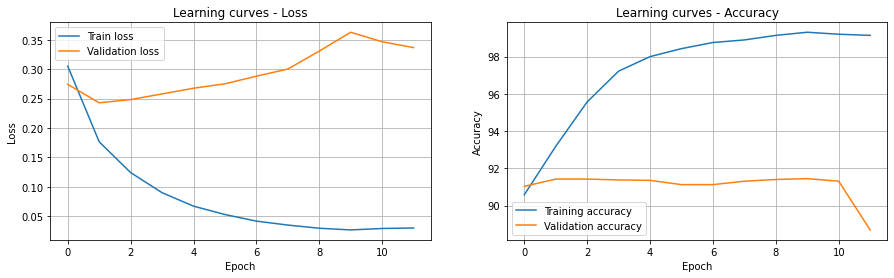

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 8, Nh = 256, act = Sigmoid, opt = RMSprop, lr = 0.0001, reg = Batch norm, max_features = 1000, n_max = 1, vect_type = tfidf, approach = none


Best val_loss: 0.28538 - train_loss: 0.21183 - val_acc: 89.06% - train_acc: 92.13% - balanced_accuracy: 0.60% - execution_time: 30s


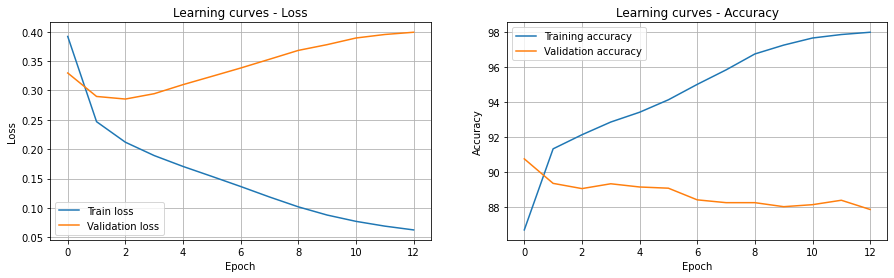

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 1024, act = ELU, opt = SGD, lr = 1, reg = Batch norm, max_features = 1900, n_max = 2, vect_type = cv, approach = under


Best val_loss: 3.56631 - train_loss: 0.62126 - val_acc: 11.42% - train_acc: 83.07% - balanced_accuracy: 0.51% - execution_time: 70s


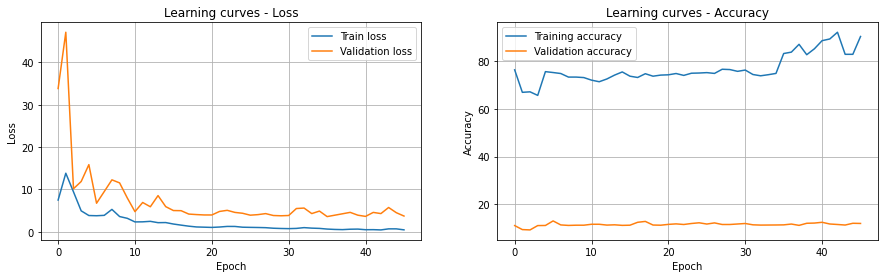

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 128, act = ELU, opt = RMSprop, lr = 0.1, reg = Batch norm, max_features = 2703, n_max = 1, vect_type = cv, approach = under


Best val_loss: 2.53553 - train_loss: 0.31739 - val_acc: 11.63% - train_acc: 97.35% - balanced_accuracy: 0.50% - execution_time: 53s


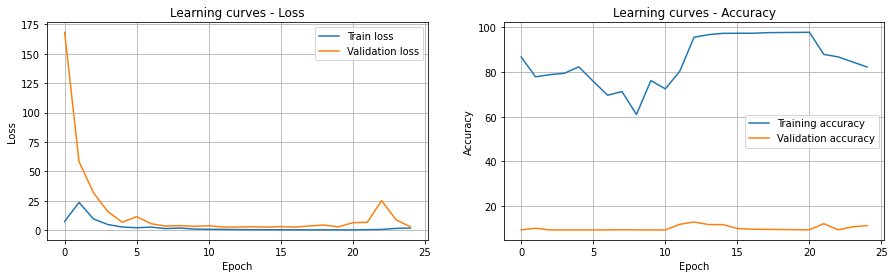

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 512, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = False, max_features = 250, n_max = 2, vect_type = tfidf, approach = over


Best val_loss: 15.36370 - train_loss: 0.48789 - val_acc: 9.24% - train_acc: 93.35% - balanced_accuracy: 0.50% - execution_time: 22s


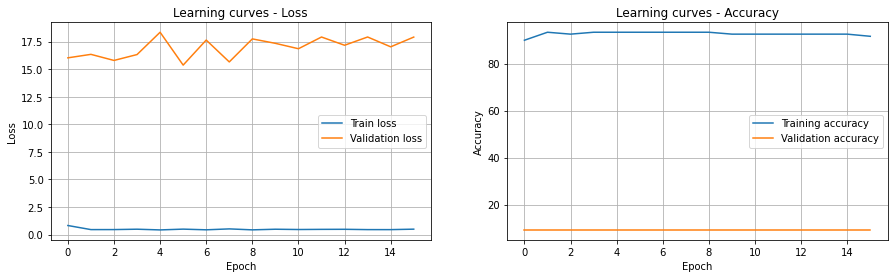

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 7, Nh = 256, act = LeakyReLU, opt = RMSprop, lr = 0.1, reg = Batch norm, max_features = 1900, n_max = 1, vect_type = cv, approach = under


Best val_loss: 1.26889 - train_loss: 0.77540 - val_acc: 9.88% - train_acc: 56.13% - balanced_accuracy: 0.50% - execution_time: 57s


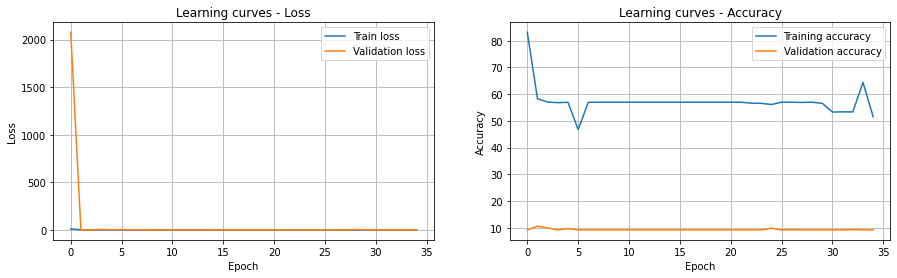

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 1024, act = ELU, opt = SGD, lr = 0.1, reg = False, max_features = 2703, n_max = 2, vect_type = tfidf, approach = none



Best val_loss: 0.30066 - train_loss: 0.29770 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 286s


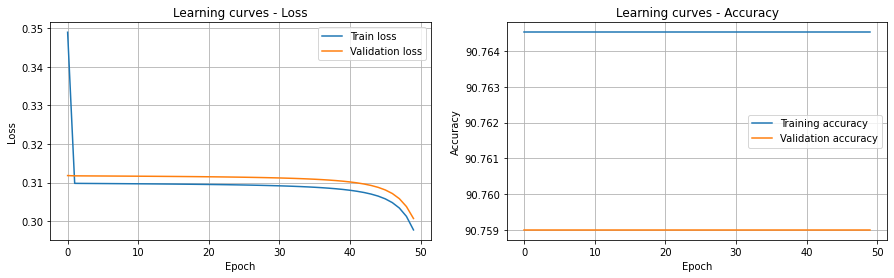

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 7, Nh = 64, act = ELU, opt = Adam, lr = 1, reg = Batch norm, max_features = 1000, n_max = 3, vect_type = cv, approach = none


Best val_loss: 0.35679 - train_loss: 1.80812 - val_acc: 90.69% - train_acc: 84.20% - balanced_accuracy: 0.51% - execution_time: 34s


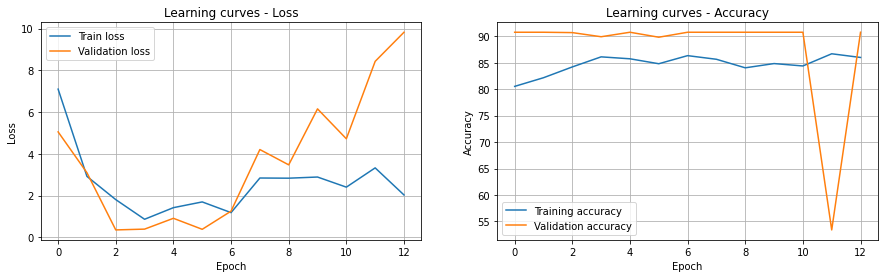

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 2048, act = LeakyReLU, opt = RMSprop, lr = 0.1, reg = L2 (wd=0.001), max_features = 250, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 8.22016 - train_loss: 0.80203 - val_acc: 9.24% - train_acc: 95.00% - balanced_accuracy: 0.50% - execution_time: 17s


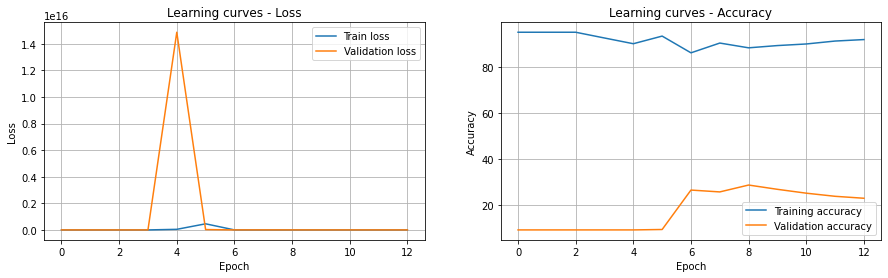

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 1024, act = Sigmoid, opt = SGD, lr = 0.001, reg = L2 (wd=0.01), max_features = 4935, n_max = 2, vect_type = tfidf, approach = none


Best val_loss: 0.31171 - train_loss: 0.30972 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 148s


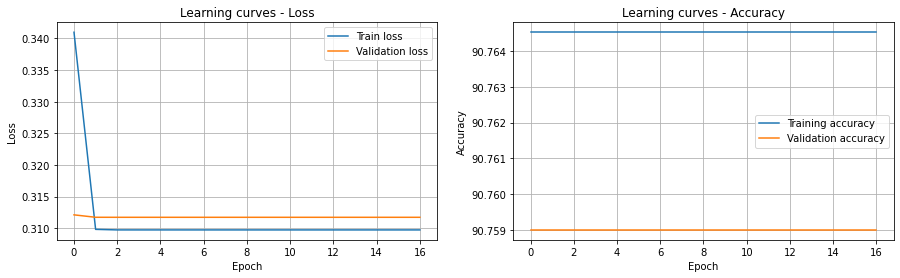

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 128, act = Sigmoid, opt = SGD, lr = 0.001, reg = False, max_features = 1000, n_max = 1, vect_type = tfidf, approach = mid


Best val_loss: 0.81029 - train_loss: 0.68950 - val_acc: 9.24% - train_acc: 55.00% - balanced_accuracy: 0.50% - execution_time: 20s


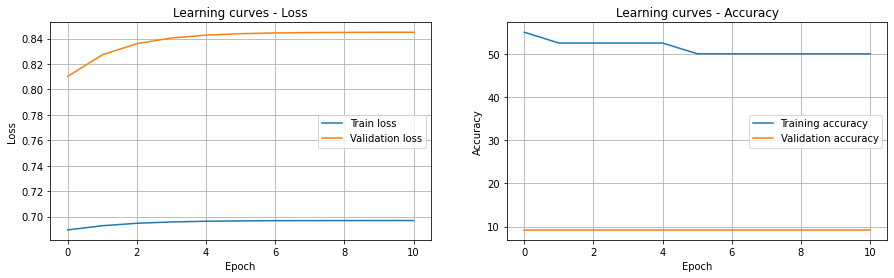

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 7, Nh = 128, act = ELU, opt = SGD, lr = 1, reg = False, max_features = 2703, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 2.92009 - train_loss: 0.45772 - val_acc: 9.24% - train_acc: 87.91% - balanced_accuracy: 0.50% - execution_time: 20s


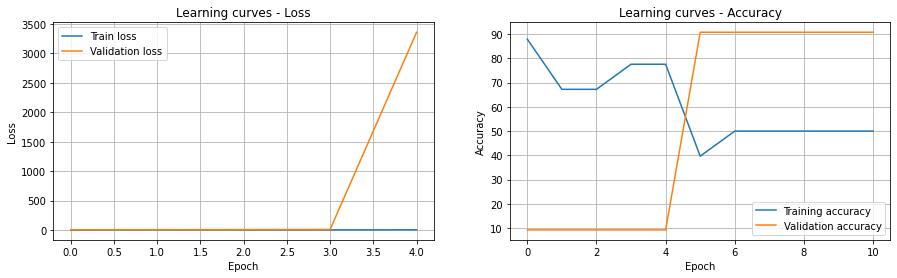

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 256, act = Sigmoid, opt = RMSprop, lr = 0.0001, reg = False, max_features = 2703, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 0.67160 - train_loss: 0.72967 - val_acc: 90.85% - train_acc: 47.50% - balanced_accuracy: 0.51% - execution_time: 48s


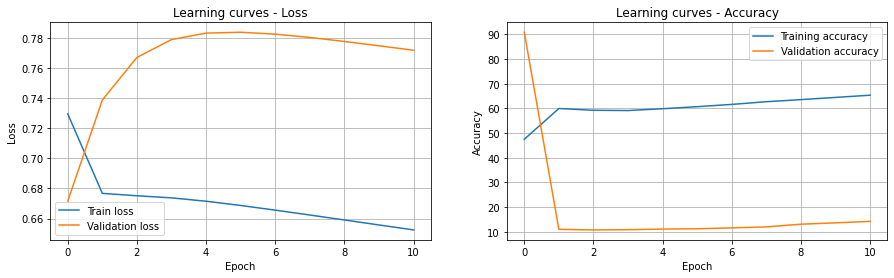

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 64, act = Sigmoid, opt = SGD, lr = 0.01, reg = Dropout, max_features = 2703, n_max = 1, vect_type = cv, approach = over



Best val_loss: 2.16090 - train_loss: 0.53479 - val_acc: 9.24% - train_acc: 75.47% - balanced_accuracy: 0.50% - execution_time: 430s


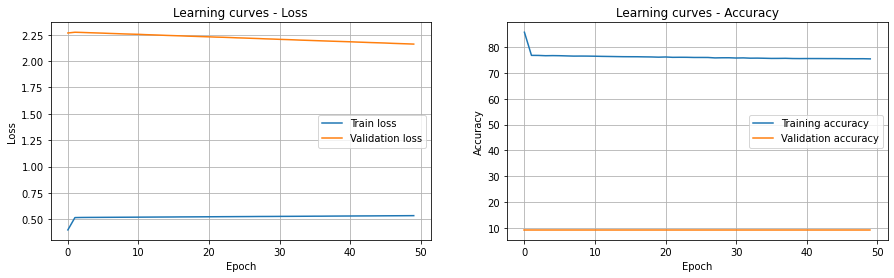

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 512, act = LeakyReLU, opt = SGD, lr = 0.01, reg = Batch norm, max_features = 2703, n_max = 1, vect_type = cv, approach = over


Best val_loss: 2.20120 - train_loss: 0.12811 - val_acc: 18.12% - train_acc: 97.44% - balanced_accuracy: 0.53% - execution_time: 151s


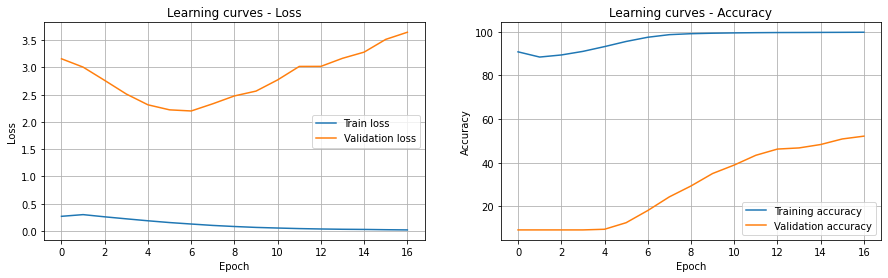

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 8, Nh = 2048, act = Sigmoid, opt = RMSprop, lr = 0.001, reg = False, max_features = 4935, n_max = 3, vect_type = tfidf, approach = mid



Best val_loss: 4.82767 - train_loss: 0.27830 - val_acc: 9.24% - train_acc: 95.00% - balanced_accuracy: 0.50% - execution_time: 436s


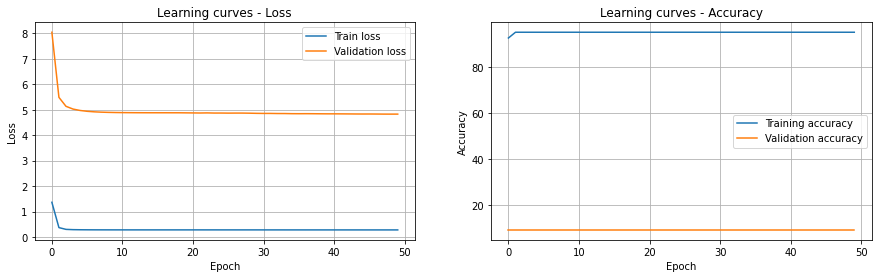

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = Dropout, max_features = 1000, n_max = 1, vect_type = cv, approach = under


Best val_loss: 1.27581 - train_loss: 0.40623 - val_acc: 43.84% - train_acc: 80.17% - balanced_accuracy: 0.67% - execution_time: 22s


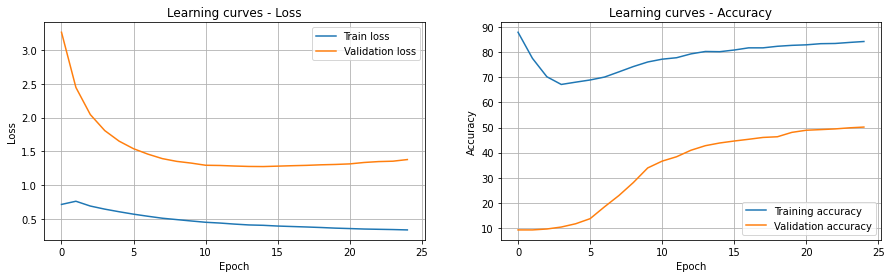

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 1024, act = LeakyReLU, opt = SGD, lr = 0.1, reg = Batch norm, max_features = 4935, n_max = 1, vect_type = cv, approach = under


Best val_loss: 2.31211 - train_loss: 1.71513 - val_acc: 9.24% - train_acc: 77.57% - balanced_accuracy: 0.50% - execution_time: 47s


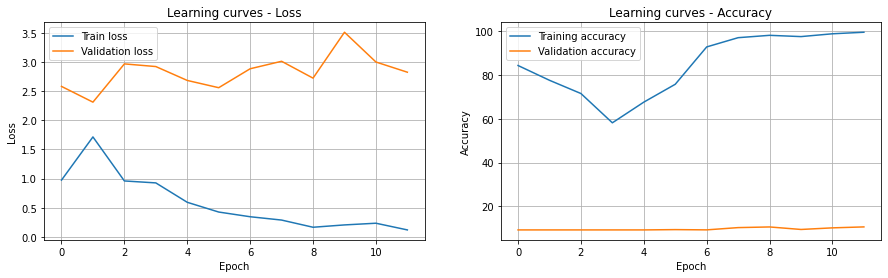

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 256, act = ELU, opt = Adam, lr = 1, reg = L2 (wd=0.001), max_features = 4935, n_max = 1, vect_type = tfidf, approach = under



Best val_loss: 276.53131 - train_loss: 53.15153 - val_acc: 9.22% - train_acc: 50.04% - balanced_accuracy: 0.50% - execution_time: 167s


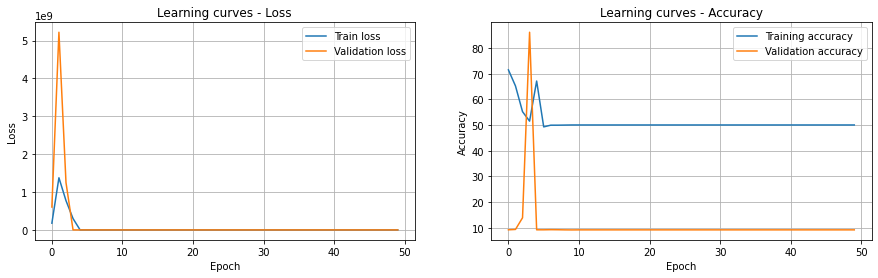

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 2048, act = ELU, opt = Adam, lr = 0.0001, reg = Batch norm, max_features = 2703, n_max = 1, vect_type = tfidf, approach = none


Best val_loss: 0.28346 - train_loss: 0.20157 - val_acc: 89.89% - train_acc: 92.67% - balanced_accuracy: 0.60% - execution_time: 68s


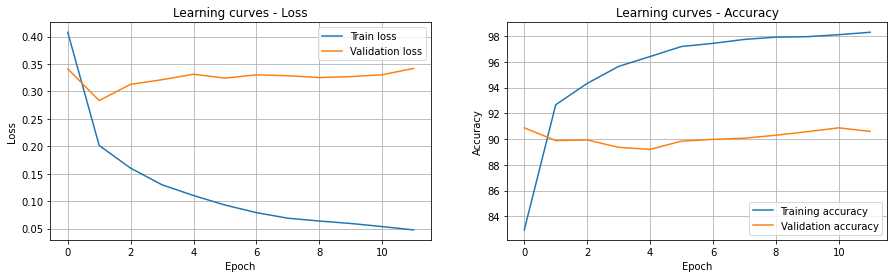

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 8, Nh = 512, act = ELU, opt = SGD, lr = 0.1, reg = False, max_features = 2703, n_max = 1, vect_type = cv, approach = under


Best val_loss: 0.85491 - train_loss: 0.69902 - val_acc: 9.24% - train_acc: 56.87% - balanced_accuracy: 0.50% - execution_time: 24s


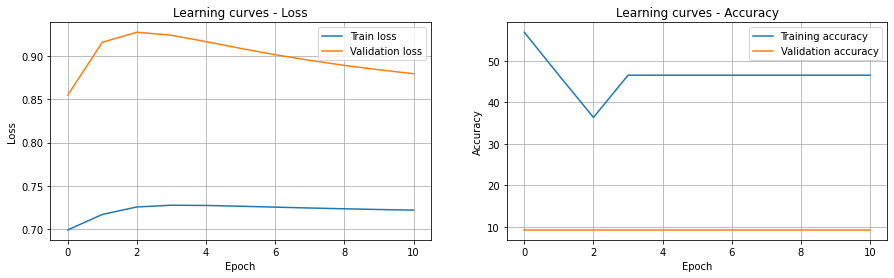

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 128, act = ELU, opt = SGD, lr = 0.01, reg = Dropout, max_features = 250, n_max = 3, vect_type = tfidf, approach = mid


Best val_loss: 0.67723 - train_loss: 0.69355 - val_acc: 90.67% - train_acc: 50.10% - balanced_accuracy: 0.50% - execution_time: 9s


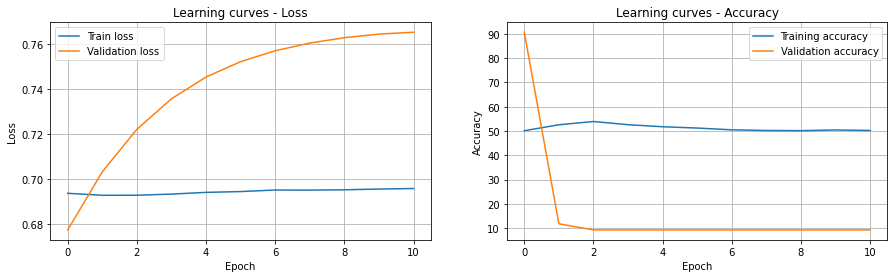

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 64, act = LeakyReLU, opt = SGD, lr = 0.0001, reg = Dropout, max_features = 4935, n_max = 3, vect_type = cv, approach = none



Best val_loss: 0.57261 - train_loss: 0.57328 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 485s


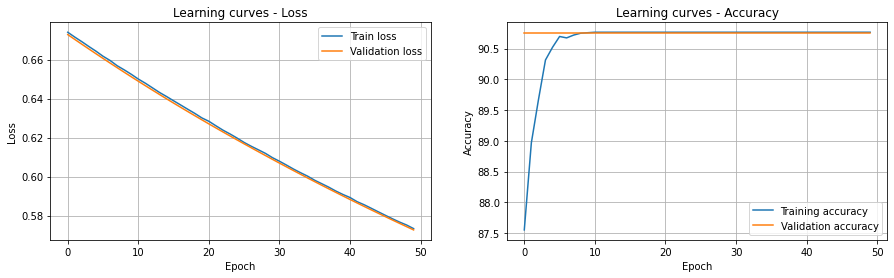

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 256, act = LeakyReLU, opt = Adam, lr = 0.1, reg = L2 (wd=0.0001), max_features = 1000, n_max = 3, vect_type = tfidf, approach = mid


Best val_loss: 1.54643 - train_loss: 1.09011 - val_acc: 9.24% - train_acc: 35.76% - balanced_accuracy: 0.50% - execution_time: 33s


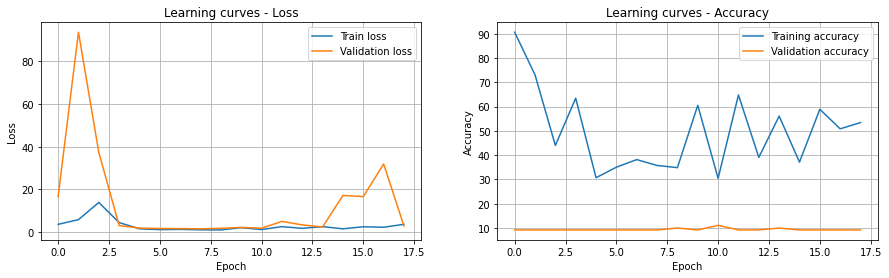

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = ELU, opt = Adam, lr = 0.001, reg = False, max_features = 1900, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 0.58116 - train_loss: 0.42080 - val_acc: 71.66% - train_acc: 80.12% - balanced_accuracy: 0.73% - execution_time: 59s


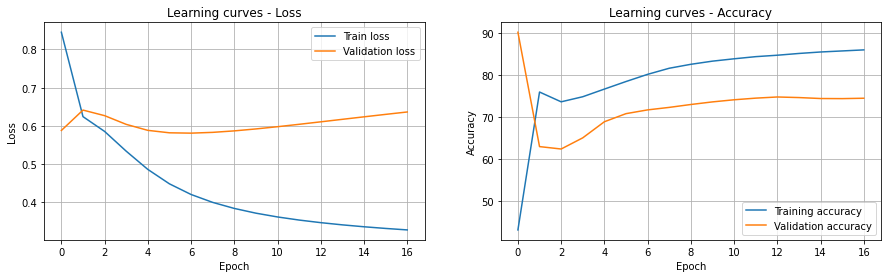

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = ELU, opt = SGD, lr = 0.001, reg = L2 (wd=0.0001), max_features = 2703, n_max = 3, vect_type = tfidf, approach = mid


Best val_loss: 0.64509 - train_loss: 0.69533 - val_acc: 90.76% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 44s


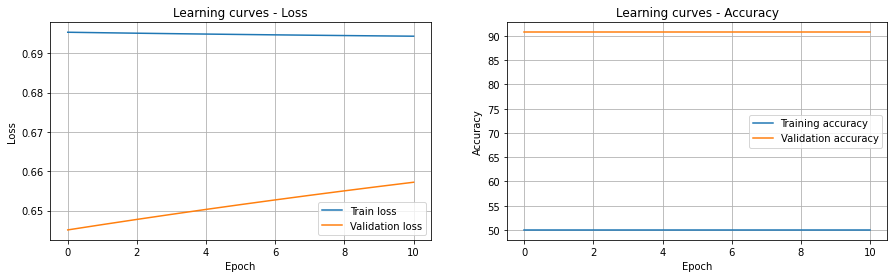

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 8, Nh = 64, act = Sigmoid, opt = Adam, lr = 0.01, reg = Dropout, max_features = 1900, n_max = 2, vect_type = cv, approach = over



Best val_loss: 0.87301 - train_loss: 0.90180 - val_acc: 9.24% - train_acc: 56.94% - balanced_accuracy: 0.50% - execution_time: 330s


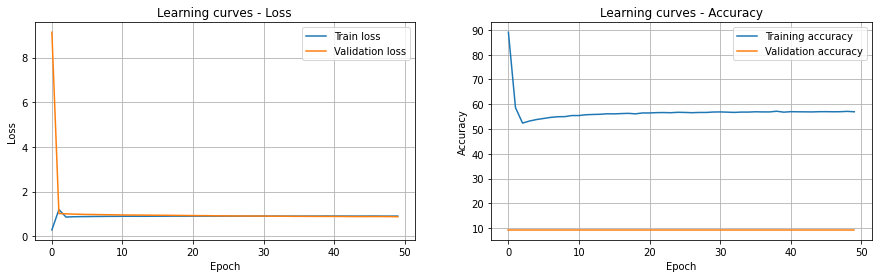

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = ELU, opt = Adam, lr = 0.01, reg = False, max_features = 1900, n_max = 2, vect_type = cv, approach = none


Best val_loss: 0.26204 - train_loss: 0.31976 - val_acc: 91.24% - train_acc: 89.59% - balanced_accuracy: 0.56% - execution_time: 44s


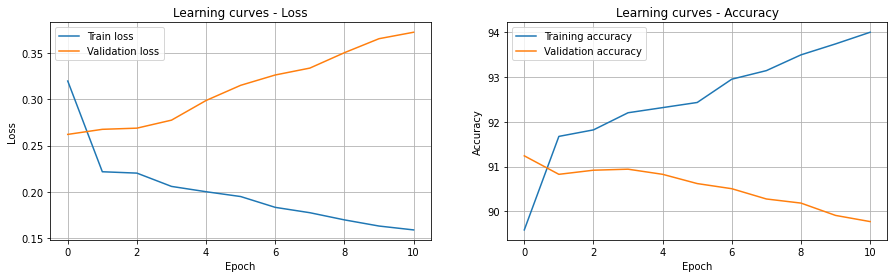

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 2048, act = LeakyReLU, opt = SGD, lr = 0.01, reg = Dropout, max_features = 250, n_max = 2, vect_type = tfidf, approach = none



Best val_loss: 0.31168 - train_loss: 0.30952 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 81s


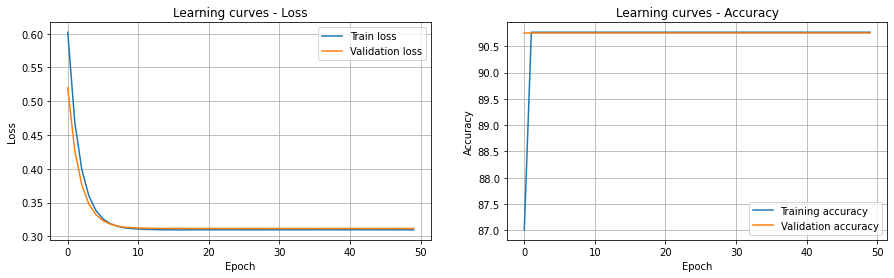

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 1024, act = ELU, opt = RMSprop, lr = 0.01, reg = False, max_features = 1000, n_max = 3, vect_type = tfidf, approach = mid


Best val_loss: 16.12836 - train_loss: 0.66913 - val_acc: 15.00% - train_acc: 94.85% - balanced_accuracy: 0.53% - execution_time: 41s


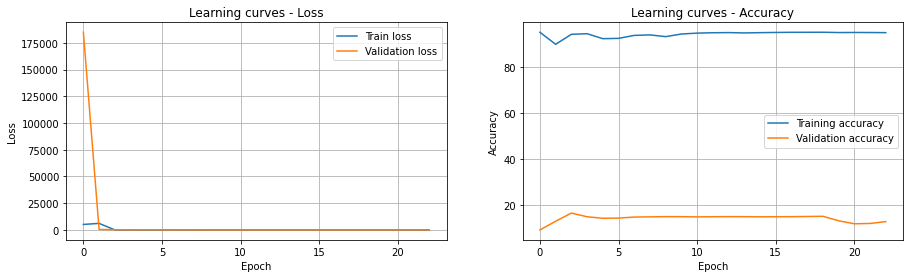

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 256, act = ELU, opt = RMSprop, lr = 1, reg = Dropout, max_features = 250, n_max = 2, vect_type = cv, approach = under



Best val_loss: 125455136.00000 - train_loss: 73483173888.00000 - val_acc: 90.74% - train_acc: 50.75% - balanced_accuracy: 0.50% - execution_time: 20s


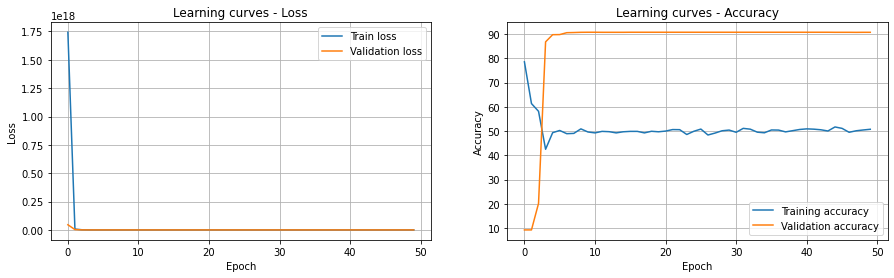

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 256, act = Sigmoid, opt = SGD, lr = 0.1, reg = Batch norm, max_features = 250, n_max = 2, vect_type = cv, approach = mid



Best val_loss: 5.71917 - train_loss: 0.29923 - val_acc: 9.24% - train_acc: 95.00% - balanced_accuracy: 0.50% - execution_time: 38s


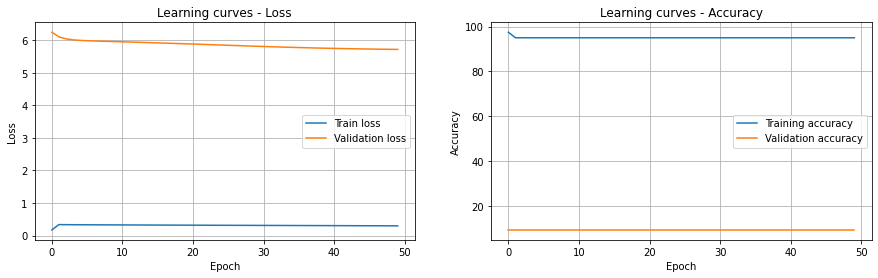

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 7, Nh = 1024, act = ELU, opt = SGD, lr = 0.0001, reg = False, max_features = 4935, n_max = 3, vect_type = tfidf, approach = none



Best val_loss: 0.53710 - train_loss: 0.53782 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 443s


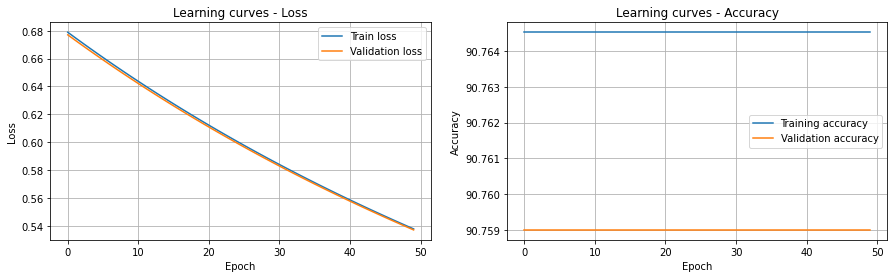

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 2048, act = Sigmoid, opt = RMSprop, lr = 0.0001, reg = L2 (wd=0.001), max_features = 1000, n_max = 3, vect_type = tfidf, approach = none


Best val_loss: 0.35240 - train_loss: 0.34247 - val_acc: 90.76% - train_acc: 89.22% - balanced_accuracy: 0.50% - execution_time: 30s


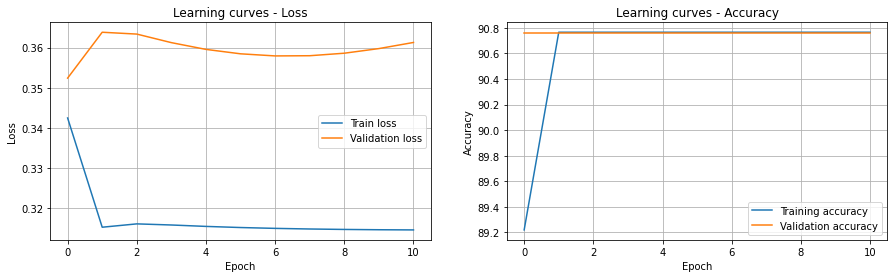

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 1024, act = Sigmoid, opt = Adam, lr = 1, reg = Batch norm, max_features = 1900, n_max = 3, vect_type = cv, approach = mid


Best val_loss: 8.59943 - train_loss: 4.44149 - val_acc: 9.24% - train_acc: 40.11% - balanced_accuracy: 0.50% - execution_time: 126s


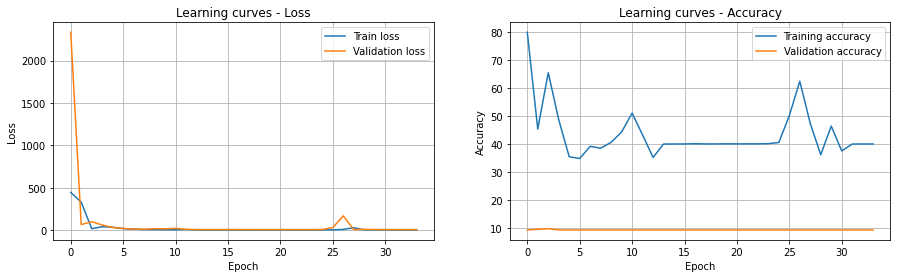

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 7, Nh = 256, act = LeakyReLU, opt = RMSprop, lr = 0.01, reg = L2 (wd=1e-05), max_features = 2703, n_max = 3, vect_type = tfidf, approach = under


Best val_loss: 2.15581 - train_loss: 0.70274 - val_acc: 13.19% - train_acc: 61.71% - balanced_accuracy: 0.52% - execution_time: 92s


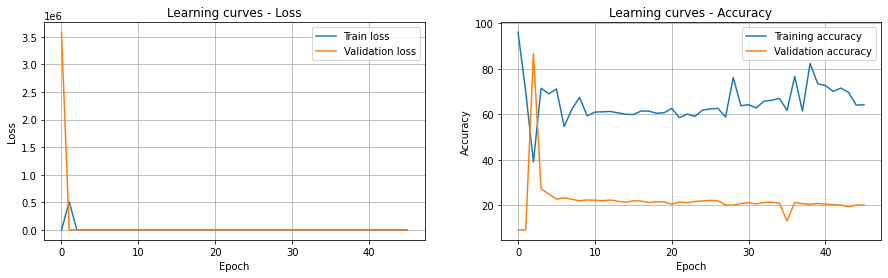

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 8, Nh = 64, act = ELU, opt = SGD, lr = 0.01, reg = Dropout, max_features = 2703, n_max = 2, vect_type = cv, approach = under


Best val_loss: 0.69939 - train_loss: 0.69738 - val_acc: 9.24% - train_acc: 44.16% - balanced_accuracy: 0.50% - execution_time: 25s


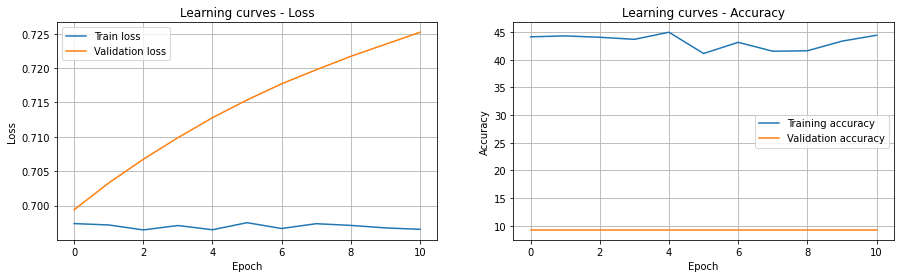

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 64, act = Sigmoid, opt = Adam, lr = 0.0001, reg = Batch norm, max_features = 2703, n_max = 3, vect_type = tfidf, approach = under


Best val_loss: 0.71720 - train_loss: 0.65708 - val_acc: 39.99% - train_acc: 70.36% - balanced_accuracy: 0.61% - execution_time: 45s


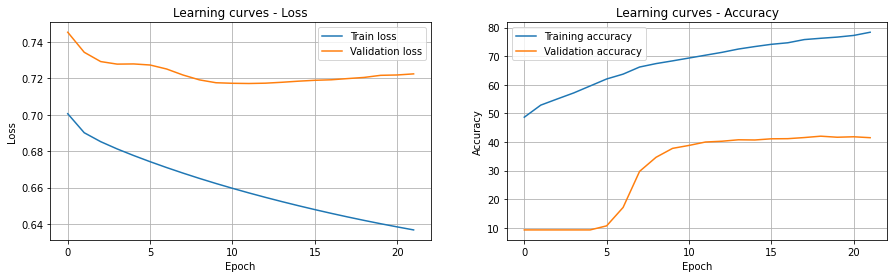

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 256, act = ELU, opt = RMSprop, lr = 0.001, reg = Dropout, max_features = 1000, n_max = 1, vect_type = cv, approach = over


Best val_loss: 3.99156 - train_loss: 0.23230 - val_acc: 38.04% - train_acc: 91.66% - balanced_accuracy: 0.62% - execution_time: 81s


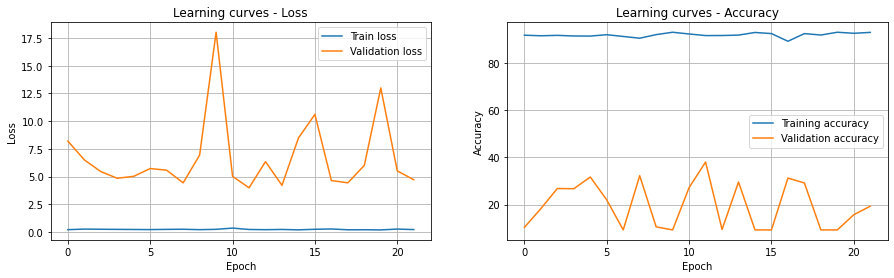

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 2048, act = ELU, opt = SGD, lr = 0.1, reg = L2 (wd=0.0001), max_features = 2703, n_max = 3, vect_type = cv, approach = none


Best val_loss: 0.25901 - train_loss: 0.21876 - val_acc: 90.69% - train_acc: 91.92% - balanced_accuracy: 0.59% - execution_time: 159s


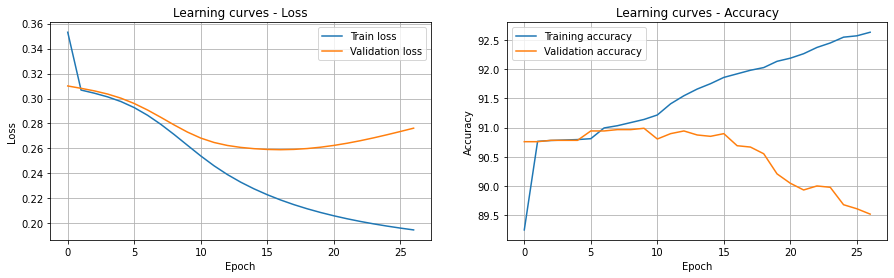

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 1024, act = ELU, opt = SGD, lr = 0.0001, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = tfidf, approach = none



Best val_loss: 0.29566 - train_loss: 0.27880 - val_acc: 90.83% - train_acc: 91.07% - balanced_accuracy: 0.51% - execution_time: 433s


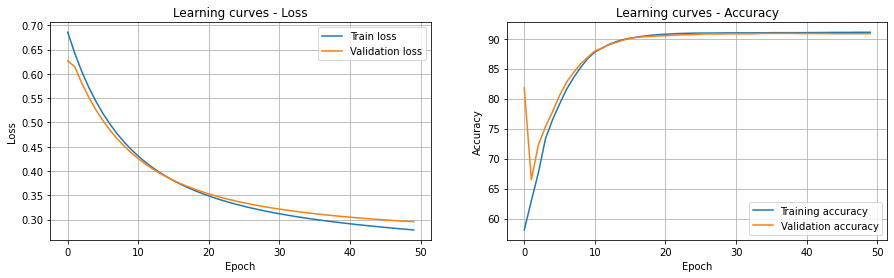

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 2048, act = ELU, opt = Adam, lr = 0.1, reg = Dropout, max_features = 2703, n_max = 1, vect_type = cv, approach = over



Best val_loss: 141.39282 - train_loss: 3334418.50000 - val_acc: 9.24% - train_acc: 49.10% - balanced_accuracy: 0.50% - execution_time: 578s


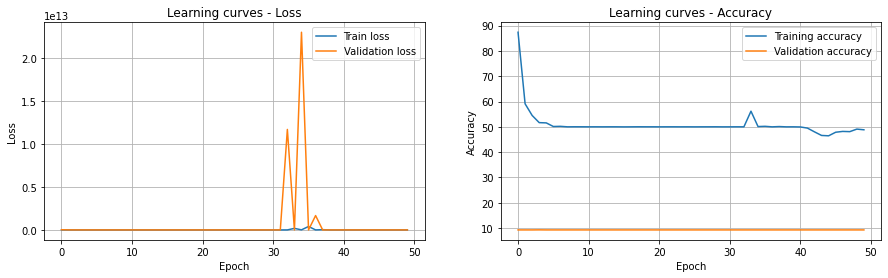

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 1024, act = LeakyReLU, opt = RMSprop, lr = 0.01, reg = L2 (wd=0.001), max_features = 1000, n_max = 1, vect_type = cv, approach = none


Best val_loss: 0.28477 - train_loss: 0.27744 - val_acc: 90.87% - train_acc: 90.58% - balanced_accuracy: 0.52% - execution_time: 43s


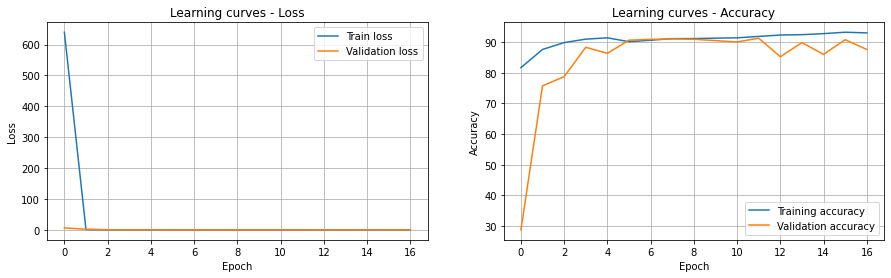

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = ELU, opt = Adam, lr = 1, reg = False, max_features = 1000, n_max = 1, vect_type = tfidf, approach = none


Best val_loss: 3.20040 - train_loss: 2.71256 - val_acc: 89.80% - train_acc: 85.69% - balanced_accuracy: 0.53% - execution_time: 27s


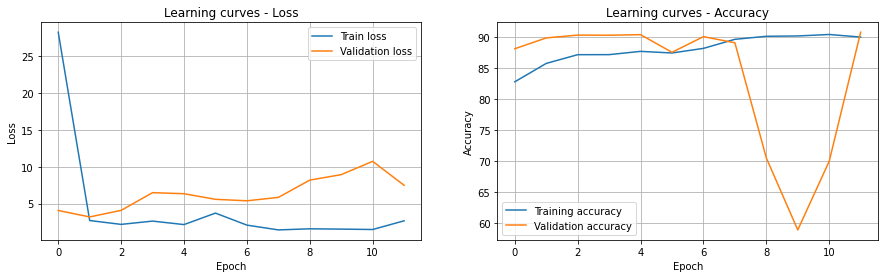

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 256, act = Sigmoid, opt = SGD, lr = 0.0001, reg = Batch norm, max_features = 250, n_max = 2, vect_type = cv, approach = under


Best val_loss: 0.68576 - train_loss: 0.69968 - val_acc: 90.76% - train_acc: 48.34% - balanced_accuracy: 0.50% - execution_time: 5s


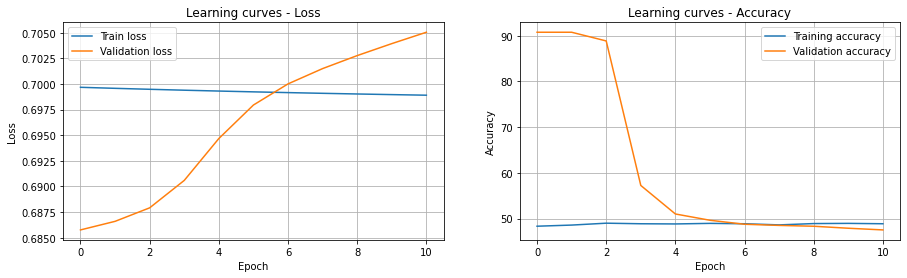

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 8, Nh = 128, act = Sigmoid, opt = RMSprop, lr = 0.0001, reg = L2 (wd=0.0001), max_features = 4935, n_max = 3, vect_type = tfidf, approach = over



Best val_loss: 1.04596 - train_loss: 0.68021 - val_acc: 9.24% - train_acc: 57.52% - balanced_accuracy: 0.50% - execution_time: 208s


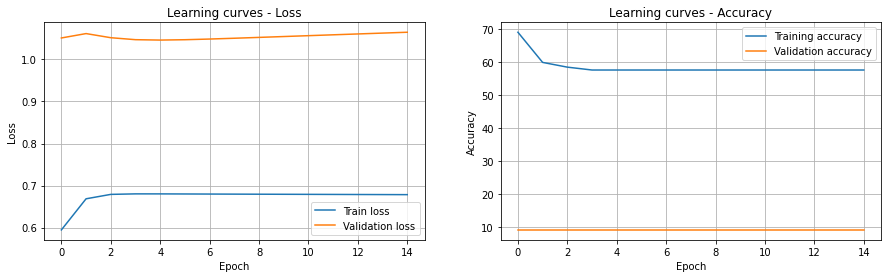

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 128, act = ELU, opt = Adam, lr = 0.0001, reg = Batch norm, max_features = 1900, n_max = 2, vect_type = tfidf, approach = mid


Best val_loss: 0.62958 - train_loss: 0.63436 - val_acc: 76.59% - train_acc: 63.72% - balanced_accuracy: 0.55% - execution_time: 43s


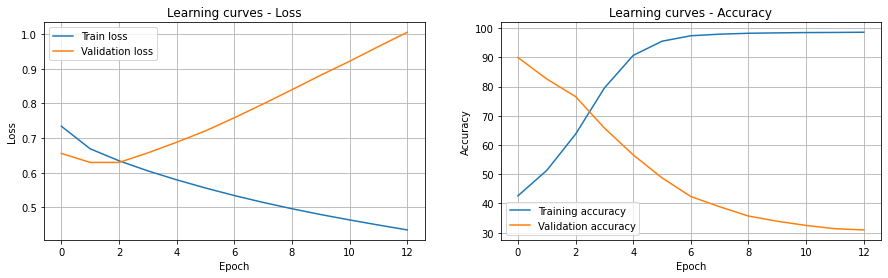

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 256, act = LeakyReLU, opt = Adam, lr = 0.0001, reg = L2 (wd=0.1), max_features = 2703, n_max = 3, vect_type = tfidf, approach = under


Best val_loss: 0.69063 - train_loss: 0.69367 - val_acc: 90.76% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 23s


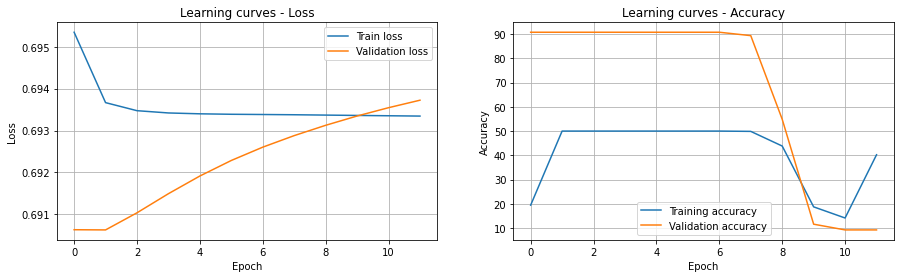

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 2048, act = Sigmoid, opt = Adam, lr = 1, reg = L2 (wd=1e-05), max_features = 250, n_max = 3, vect_type = tfidf, approach = under


Best val_loss: 426.86975 - train_loss: 884.48047 - val_acc: 9.24% - train_acc: 25.83% - balanced_accuracy: 0.50% - execution_time: 11s


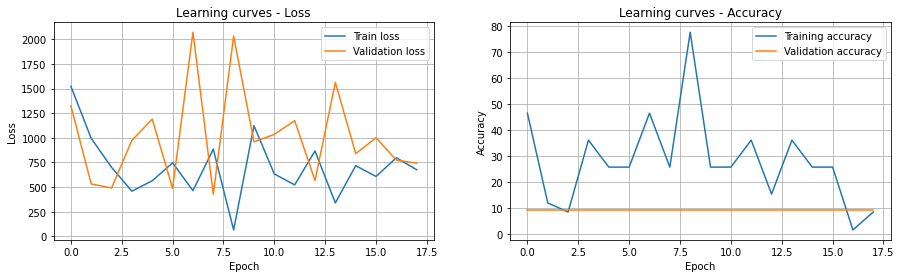

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 512, act = LeakyReLU, opt = Adam, lr = 0.01, reg = Batch norm, max_features = 4935, n_max = 1, vect_type = cv, approach = under


Best val_loss: 0.45948 - train_loss: 3.22437 - val_acc: 89.02% - train_acc: 47.43% - balanced_accuracy: 0.50% - execution_time: 42s


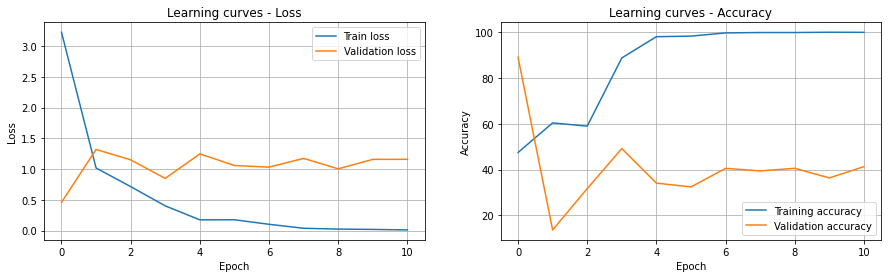

--------------------------------------------------------------------------------------------------------------------
RESULTS SORTED BY ACCURACY
Val_acc = 91.42 - Balanced_val_acc = 0.57 -> HL = 2, Nh = 1024, act = LeakyReLU, opt = Adam   , lr = 0.0001, reg = Batch norm, max_features = 2703, n_max = 3, vect_type = cv, approach = none
Val_acc = 91.24 - Balanced_val_acc = 0.56 -> HL = 1, Nh =   64, act = ELU      , opt = Adam   , lr =   0.01, reg = False, max_features = 1900, n_max = 2, vect_type = cv, approach = none
Val_acc = 90.87 - Balanced_val_acc = 0.52 -> HL = 4, Nh = 1024, act = LeakyReLU, opt = RMSprop, lr =   0.01, reg = L2 (wd=0.001), max_features = 1000, n_max = 1, vect_type = cv, approach = none
Val_acc = 90.85 - Balanced_val_acc = 0.51 -> HL = 1, Nh =  256, act = Sigmoid  , opt = RMSprop, lr = 0.0001, reg = False, max_features = 2703, n_max = 1, vect_type = cv, approach = mid
Val_acc = 90.83 - Balanced_val_acc = 0.51 -> HL = 3, Nh = 1024, act = ELU      , opt = SGD    , lr =

In [ ]:
## 50 combiantions with balanced accuracy

# Define possible values for each hyper-parameter
HL_v = [1,2,3,4,5,6,7,8]
Nh_v = [64, 128, 256, 512, 1024, 2048]
act_v = ['Sigmoid', 'LeakyReLU', 'ELU']
act_dict = {'Sigmoid':nn.Sigmoid(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU()}
opt_v = ['Adam', 'RMSprop', 'SGD']
lr_v = [1, 0.1, 0.01, 0.001, 0.0001]
reg_v = ['False', 'Dropout', 'Batch norm', 'L2']
wd_v = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# train_batch_size_v = [100, 250, 500, 1000]

max_features_v = [250, 1000, 1900, 2703, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
vect_type_v = ['cv', 'tfidf']
approach_v = ['none', 'over', 'under', 'mid']

# max_features = 250
# n_min = 1 # , 2, 3]
# n_max = 1
# vect_type = 'cv'#, 'tfidf']
# approach = 'none'

results = []

# RANDOM SEARCH
random.seed(1)
pbar = tq.tqdm(total = 50, desc = 'Random search progress')
random_coarse_grid = list(itertools.product(HL_v, Nh_v, act_v, opt_v, lr_v, reg_v, wd_v, max_features_v, n_max_v, vect_type_v, approach_v))
for (HL, Nh, act, opt, lr, reg, wd, max_features, n_max, vect_type, approach) in random.sample(random_coarse_grid, 50):
    # sampling combinations from itertools.product, we are sure no combination is repeated
    print(f'FCNN with HL = {HL}, Nh = {Nh}, act = {act}, opt = {opt}, lr = {lr},'
          f' reg = {reg if reg != "L2" else reg + " (wd=" + str(wd) + ")"}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}')
    
    start_time = time.time()
    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    activation = act_dict[act]
    net = FCNet(max_features, Nh, 2, HL, activation, reg)
    net.to(device)

    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Define the optimizer
    if reg == 'L2':
        opt_dict = {'Adam': optim.Adam(net.parameters(), lr =lr, weight_decay = wd),
                    'RMSprop': optim.RMSprop(net.parameters(), lr = lr, weight_decay = wd),
                    'SGD': optim.SGD(net.parameters(), lr = lr, weight_decay = wd)}
        optimizer = opt_dict[opt]
    else:
        opt_dict = {'Adam': optim.Adam(net.parameters(), lr = lr), 
                    'RMSprop': optim.RMSprop(net.parameters(), lr = lr),
                    'SGD': optim.SGD(net.parameters(), lr = lr)}
        optimizer = opt_dict[opt]

    # Dataloader definition
    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

    train_dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)
    val_dataset = MyDataset(X_val_v, y_val, transform=composed_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=False, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=250, shuffle=False, num_workers=0)

    # TRAINING LOOP
    num_epochs = 50
    patience = 10
    train_loss_log, val_loss_log, best_t_loss, best_v_loss, train_accuracy_log, val_accuracy_log, best_t_acc, best_v_acc, bacc, net = training_loop(net, 
                            train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch=0, patience=patience)
    
    results.append((np.round(best_v_acc, 2), np.round(bacc, 2), f'HL = {HL}, Nh = {Nh:4}, act = {act:9}, opt = {opt:7}, lr = {lr:6},'
                                             f' reg = {reg if reg != "L2" else reg + " (wd=" + str(wd) + ")"}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}'))
    run_time = time.time() - start_time
    print(f'Best val_loss: {best_v_loss:.5f} - train_loss: {best_t_loss:.5f} - val_acc: {best_v_acc:.2f}% - train_acc: {best_t_acc:.2f}% - balanced_accuracy: {bacc:.2f}% - execution_time: {run_time:.0f}s') 
    
    plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log)
    print('--------------------------------------------------------------------------------------------------------------------')
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')
print()
print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

FCNN with HL = 2, Nh = 256, act = GELU, opt = RMSprop, lr = 0.0001, reg = False, max_features = 4935, n_max = 1, vect_type = tfidf, approach = mid


Best val_loss: 0.50141 - train_loss: 0.30770 - val_acc: 76.24% - train_acc: 88.34% - balanced_accuracy: 0.73% - execution_time: 188s


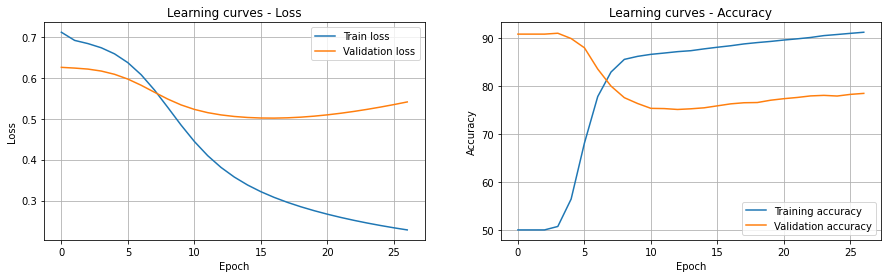

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 1024, act = Sigmoid, opt = RMSprop, lr = 0.001, reg = Dropout, max_features = 1000, n_max = 1, vect_type = tfidf, approach = under



Best val_loss: 1.63623 - train_loss: 0.46400 - val_acc: 17.77% - train_acc: 75.58% - balanced_accuracy: 0.54% - execution_time: 41s


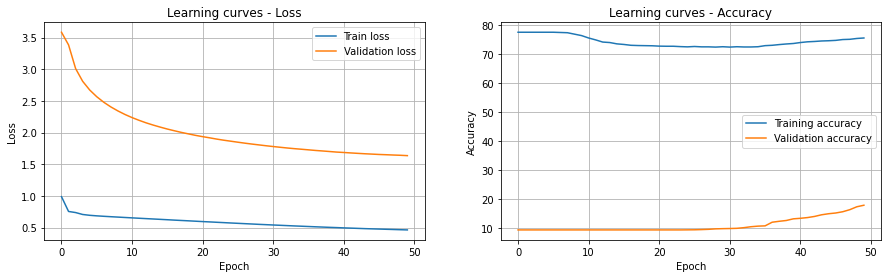

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 1024, act = ELU, opt = RMSprop, lr = 1e-05, reg = False, max_features = 2703, n_max = 3, vect_type = tfidf, approach = none


Best val_loss: 0.25391 - train_loss: 0.20976 - val_acc: 91.19% - train_acc: 91.62% - balanced_accuracy: 0.54% - execution_time: 145s


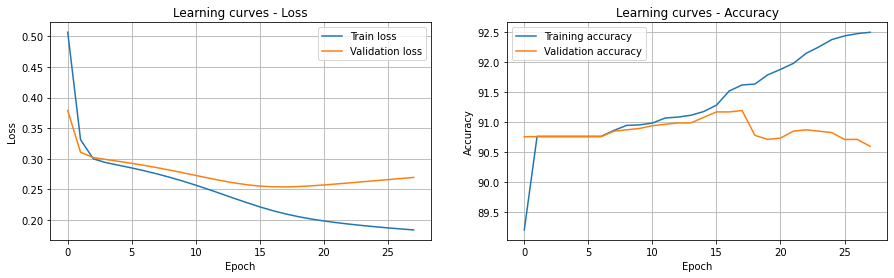

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 128, act = GELU, opt = Adam, lr = 0.0001, reg = Dropout, max_features = 1900, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.66491 - train_loss: 0.69496 - val_acc: 90.76% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 16s


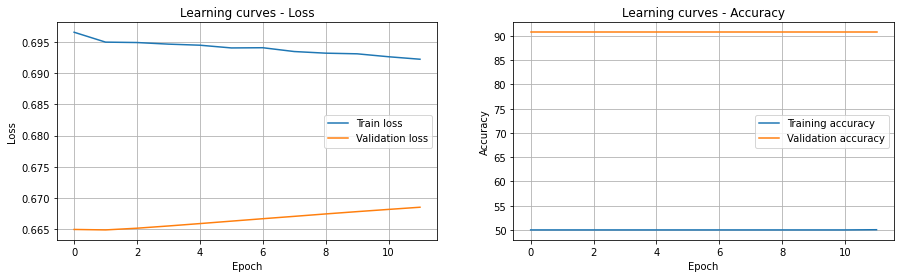

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 256, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = False, max_features = 1900, n_max = 1, vect_type = tfidf, approach = none



Best val_loss: 0.43012 - train_loss: 0.32727 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 174s


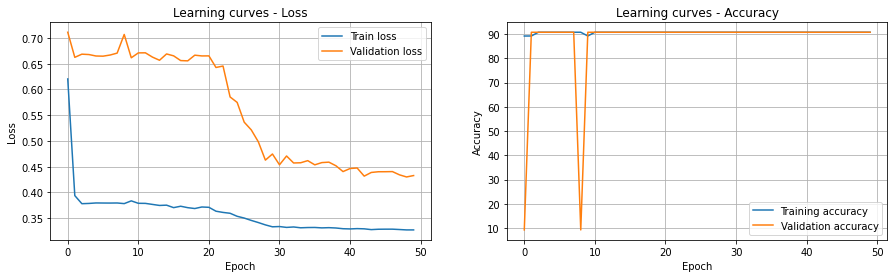

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 2048, act = Sigmoid, opt = RMSprop, lr = 0.0001, reg = False, max_features = 1000, n_max = 3, vect_type = cv, approach = under



Best val_loss: 0.97638 - train_loss: 0.73298 - val_acc: 9.24% - train_acc: 46.52% - balanced_accuracy: 0.50% - execution_time: 81s


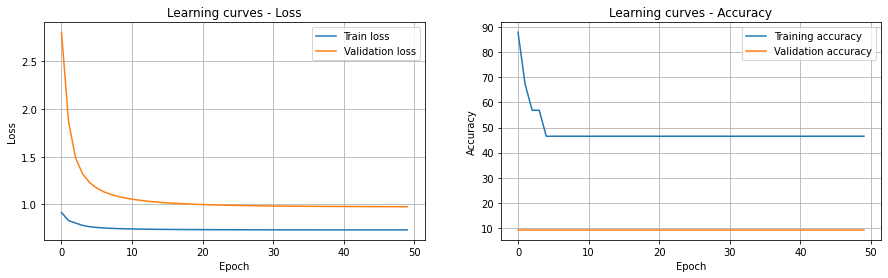

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 64, act = ELU, opt = SGD, lr = 0.0001, reg = Dropout, max_features = 2703, n_max = 1, vect_type = tfidf, approach = mid


Best val_loss: 0.65821 - train_loss: 0.69454 - val_acc: 90.76% - train_acc: 50.11% - balanced_accuracy: 0.50% - execution_time: 44s


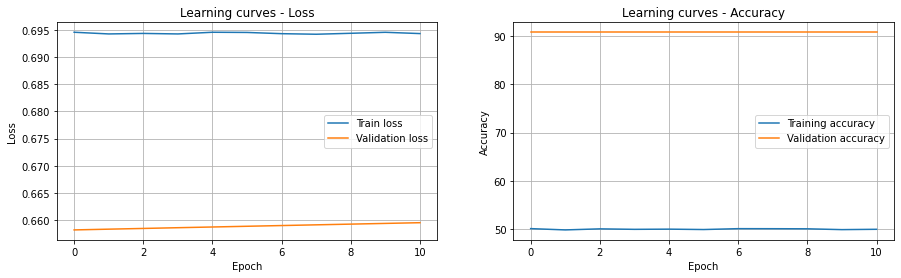

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 64, act = ELU, opt = SGD, lr = 0.0001, reg = Batch norm, max_features = 2703, n_max = 1, vect_type = tfidf, approach = none


Best val_loss: 0.60165 - train_loss: 0.69457 - val_acc: 80.81% - train_acc: 56.22% - balanced_accuracy: 0.52% - execution_time: 55s


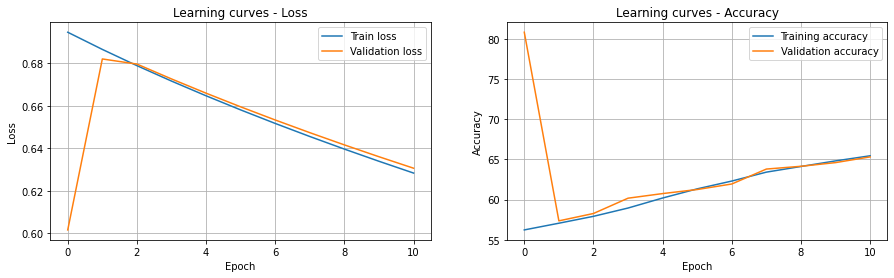

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 128, act = ELU, opt = SGD, lr = 1e-06, reg = False, max_features = 2703, n_max = 3, vect_type = cv, approach = under


Best val_loss: 0.70508 - train_loss: 0.69297 - val_acc: 9.45% - train_acc: 49.96% - balanced_accuracy: 0.50% - execution_time: 24s


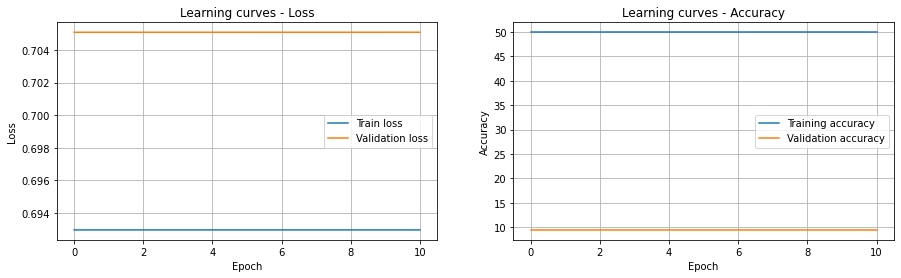

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 64, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = Dropout, max_features = 4935, n_max = 3, vect_type = cv, approach = none


Best val_loss: 0.28523 - train_loss: 0.23686 - val_acc: 90.74% - train_acc: 91.28% - balanced_accuracy: 0.61% - execution_time: 127s


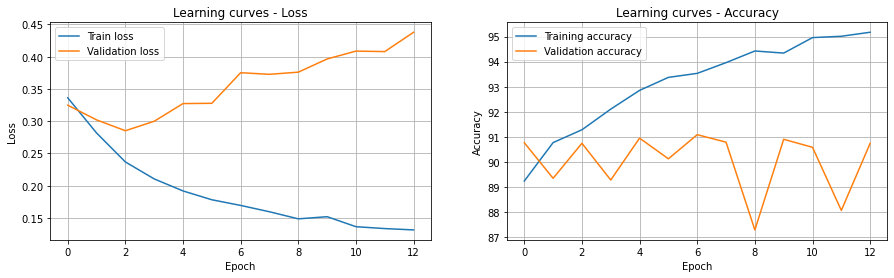

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 128, act = ELU, opt = SGD, lr = 1e-05, reg = False, max_features = 4935, n_max = 3, vect_type = cv, approach = none



Best val_loss: 0.64767 - train_loss: 0.64774 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 488s


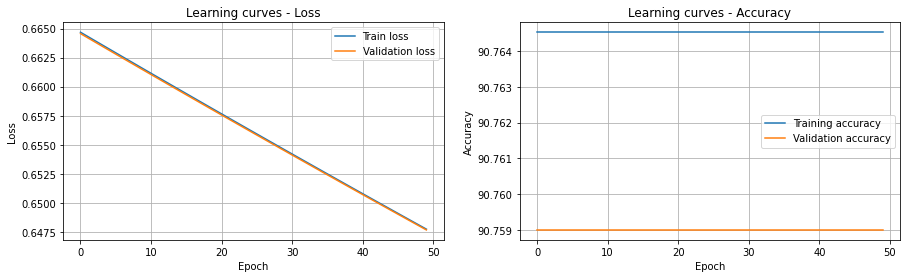

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = Softplus, opt = Adam, lr = 0.0001, reg = Dropout, max_features = 4935, n_max = 2, vect_type = cv, approach = none



Best val_loss: 0.25203 - train_loss: 0.20539 - val_acc: 91.08% - train_acc: 91.89% - balanced_accuracy: 0.53% - execution_time: 486s


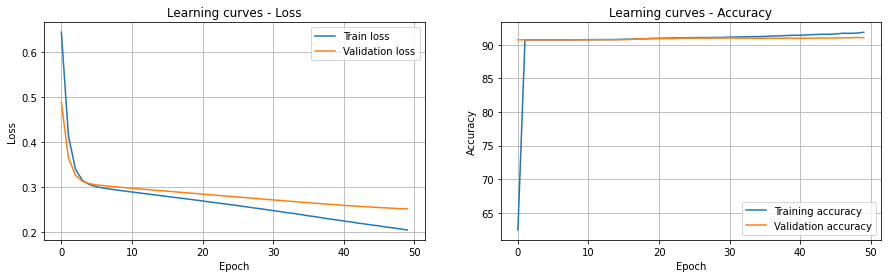

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 128, act = LeakyReLU, opt = Adam, lr = 0.0001, reg = Dropout, max_features = 1000, n_max = 1, vect_type = cv, approach = none


Best val_loss: 0.27035 - train_loss: 0.23854 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 50s


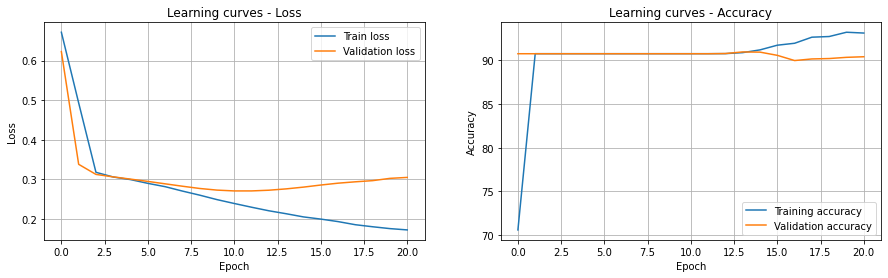

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 1024, act = Sigmoid, opt = Adam, lr = 0.01, reg = Batch norm, max_features = 2703, n_max = 2, vect_type = tfidf, approach = none


Best val_loss: 0.27795 - train_loss: 0.25053 - val_acc: 90.83% - train_acc: 90.32% - balanced_accuracy: 0.53% - execution_time: 65s


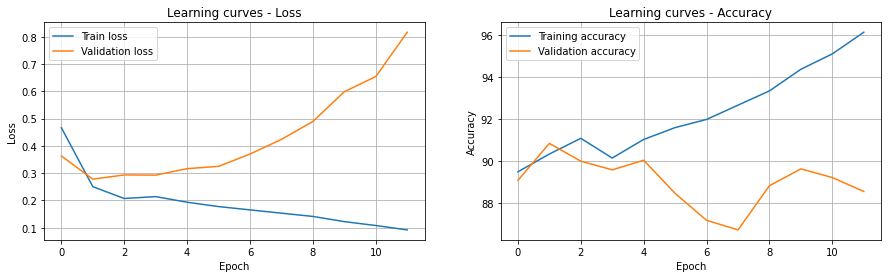

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = Sigmoid, opt = SGD, lr = 0.01, reg = False, max_features = 2703, n_max = 3, vect_type = cv, approach = none



Best val_loss: 0.31094 - train_loss: 0.30871 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 274s


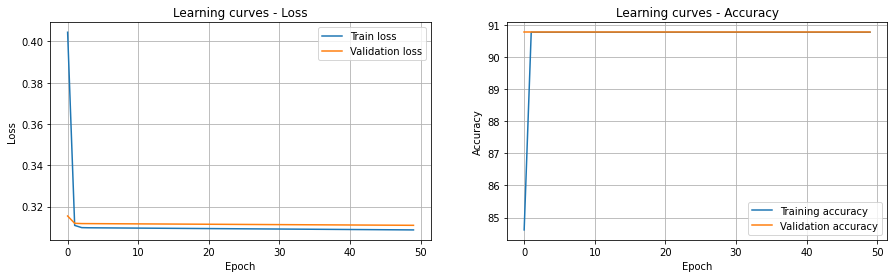

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 1024, act = Softplus, opt = Adam, lr = 0.0001, reg = False, max_features = 1900, n_max = 3, vect_type = cv, approach = none


Best val_loss: 0.26098 - train_loss: 0.22559 - val_acc: 90.85% - train_acc: 91.63% - balanced_accuracy: 0.57% - execution_time: 92s


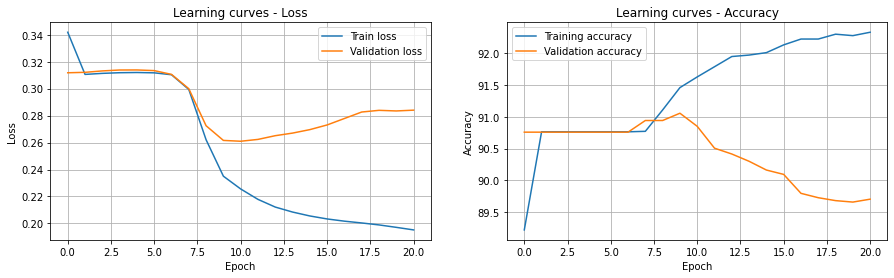

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 2048, act = LeakyReLU, opt = Adam, lr = 0.0001, reg = Batch norm, max_features = 2703, n_max = 3, vect_type = tfidf, approach = none


Best val_loss: 0.26607 - train_loss: 0.11095 - val_acc: 90.80% - train_acc: 96.45% - balanced_accuracy: 0.61% - execution_time: 69s


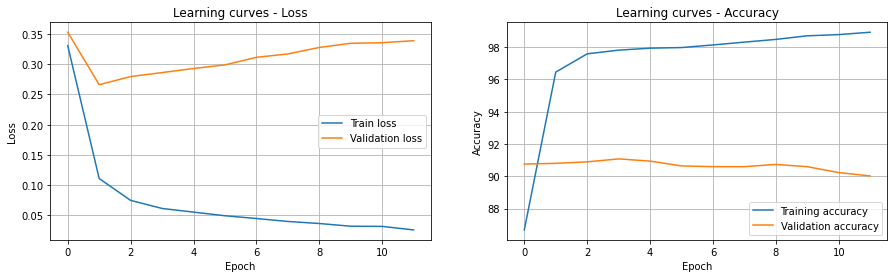

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 256, act = Softplus, opt = Adam, lr = 0.01, reg = Dropout, max_features = 2703, n_max = 2, vect_type = cv, approach = none


Best val_loss: 0.31330 - train_loss: 0.28888 - val_acc: 88.65% - train_acc: 90.74% - balanced_accuracy: 0.63% - execution_time: 84s


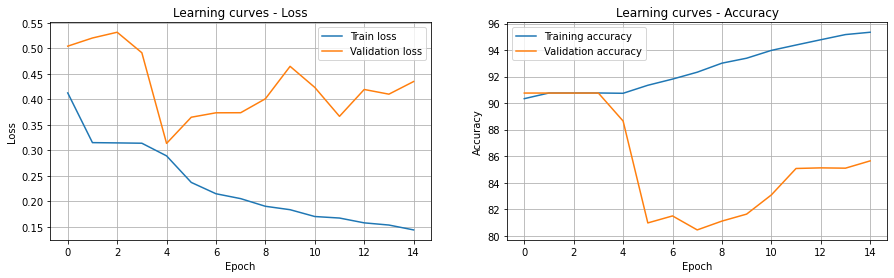

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 64, act = GELU, opt = Adam, lr = 0.001, reg = False, max_features = 4935, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 0.57970 - train_loss: 0.76316 - val_acc: 90.76% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 83s


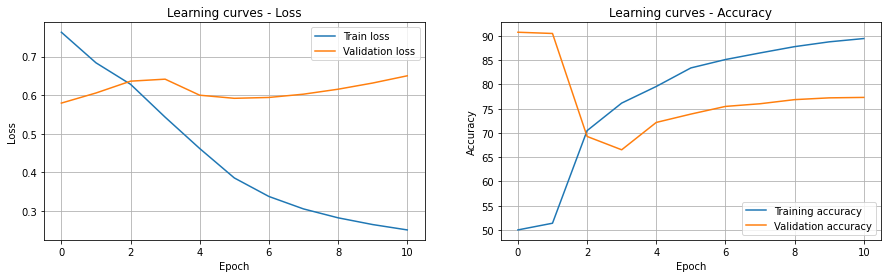

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 256, act = ELU, opt = SGD, lr = 0.01, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = tfidf, approach = mid


Best val_loss: 0.60539 - train_loss: 0.65570 - val_acc: 90.76% - train_acc: 63.22% - balanced_accuracy: 0.50% - execution_time: 79s


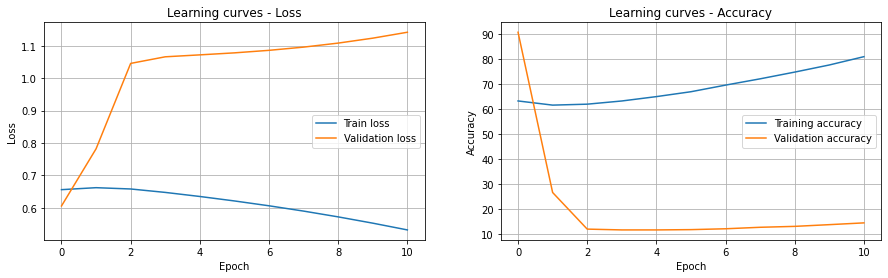

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = Softplus, opt = SGD, lr = 1e-05, reg = Dropout, max_features = 1900, n_max = 3, vect_type = tfidf, approach = mid



Best val_loss: 0.71567 - train_loss: 0.69351 - val_acc: 9.24% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 159s


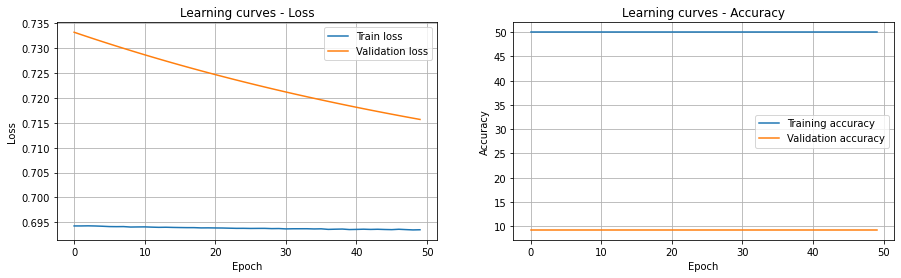

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = ELU, opt = Adam, lr = 1e-05, reg = Dropout, max_features = 1000, n_max = 2, vect_type = cv, approach = none



Best val_loss: 0.37927 - train_loss: 0.37322 - val_acc: 90.92% - train_acc: 90.98% - balanced_accuracy: 0.51% - execution_time: 122s


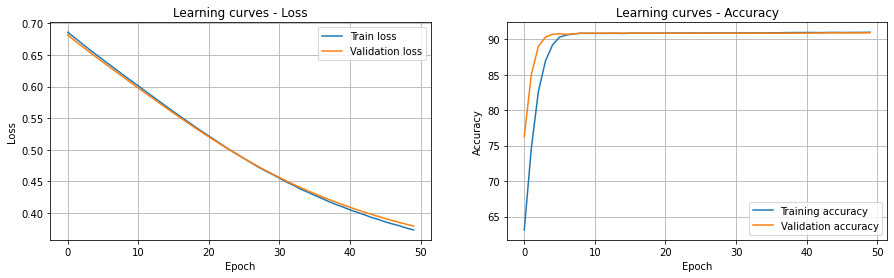

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = GELU, opt = Adam, lr = 1e-05, reg = Dropout, max_features = 2703, n_max = 1, vect_type = tfidf, approach = mid



Best val_loss: 0.64053 - train_loss: 0.68195 - val_acc: 90.85% - train_acc: 50.40% - balanced_accuracy: 0.50% - execution_time: 198s


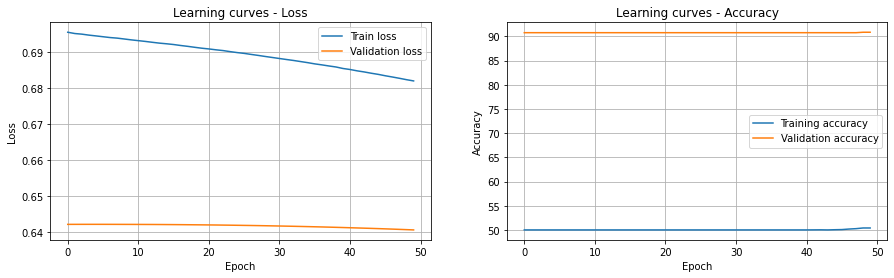

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 2048, act = Sigmoid, opt = Adam, lr = 1e-05, reg = False, max_features = 4935, n_max = 2, vect_type = tfidf, approach = under


Best val_loss: 0.52769 - train_loss: 0.80796 - val_acc: 90.76% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 45s


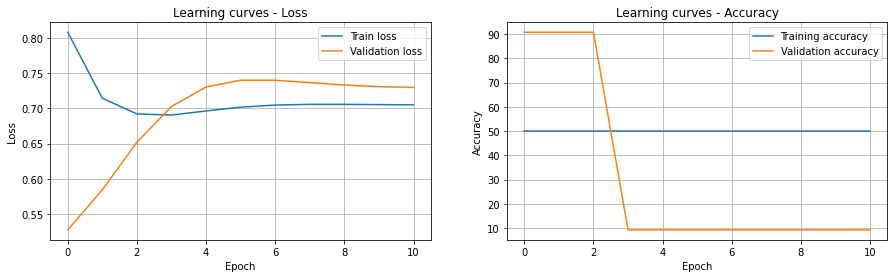

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = ELU, opt = SGD, lr = 1e-06, reg = Batch norm, max_features = 1000, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.69255 - train_loss: 0.75318 - val_acc: 52.72% - train_acc: 48.92% - balanced_accuracy: 0.49% - execution_time: 9s


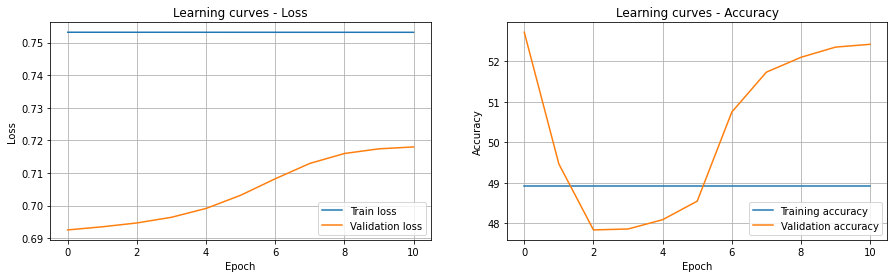

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 64, act = GELU, opt = RMSprop, lr = 0.01, reg = Dropout, max_features = 2703, n_max = 3, vect_type = cv, approach = under


Best val_loss: 1.01314 - train_loss: 0.73494 - val_acc: 9.26% - train_acc: 50.87% - balanced_accuracy: 0.50% - execution_time: 30s


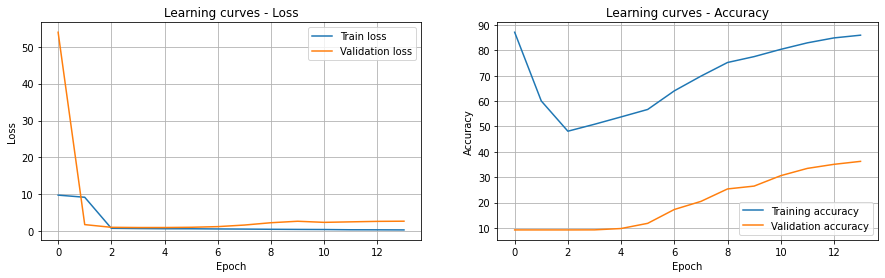

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 256, act = Sigmoid, opt = Adam, lr = 0.001, reg = Dropout, max_features = 1900, n_max = 3, vect_type = cv, approach = mid


Best val_loss: 0.72957 - train_loss: 0.74641 - val_acc: 9.24% - train_acc: 24.24% - balanced_accuracy: 0.50% - execution_time: 77s


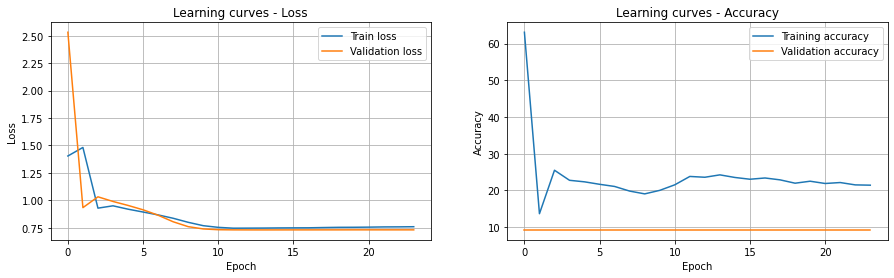

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 512, act = LeakyReLU, opt = RMSprop, lr = 1e-06, reg = False, max_features = 2703, n_max = 1, vect_type = cv, approach = under


Best val_loss: 0.70101 - train_loss: 0.69291 - val_acc: 9.24% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 30s


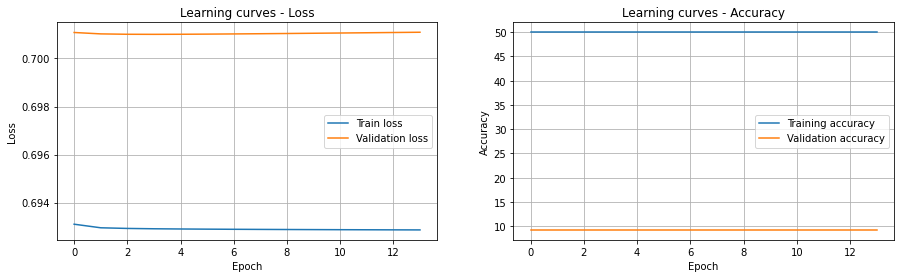

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = Softplus, opt = RMSprop, lr = 0.01, reg = Batch norm, max_features = 4935, n_max = 3, vect_type = cv, approach = under



Best val_loss: 1.14821 - train_loss: 0.01635 - val_acc: 38.66% - train_acc: 99.83% - balanced_accuracy: 0.44% - execution_time: 184s


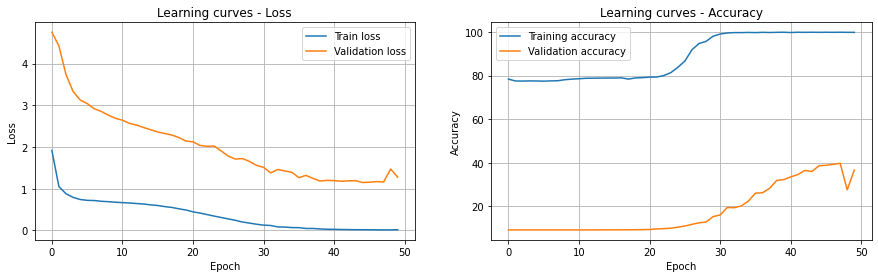

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 1024, act = Sigmoid, opt = SGD, lr = 0.001, reg = Dropout, max_features = 1000, n_max = 2, vect_type = tfidf, approach = mid


Best val_loss: 1.90244 - train_loss: 0.45591 - val_acc: 9.24% - train_acc: 83.45% - balanced_accuracy: 0.50% - execution_time: 22s


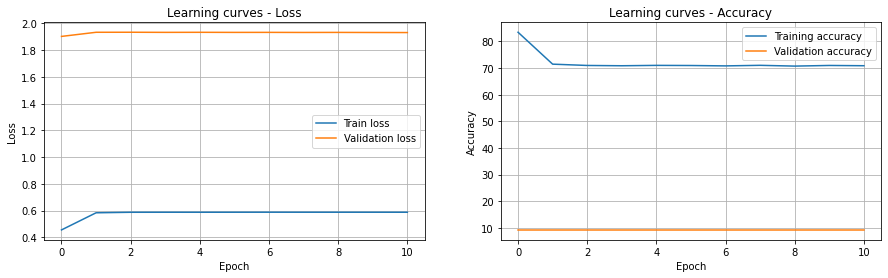

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 256, act = LeakyReLU, opt = SGD, lr = 0.001, reg = False, max_features = 2703, n_max = 2, vect_type = cv, approach = mid


Best val_loss: 0.69574 - train_loss: 0.69345 - val_acc: 10.91% - train_acc: 47.92% - balanced_accuracy: 0.50% - execution_time: 49s


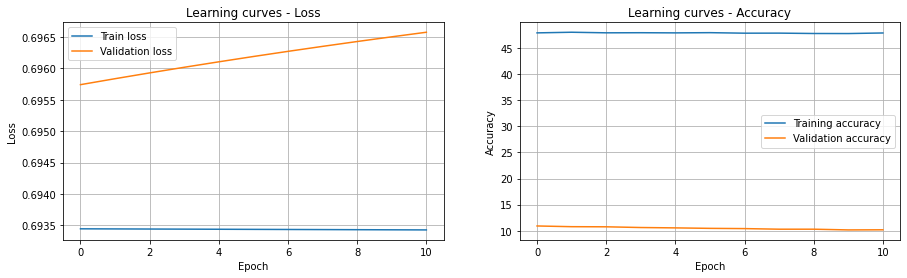

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 1024, act = LeakyReLU, opt = SGD, lr = 0.01, reg = Batch norm, max_features = 1000, n_max = 3, vect_type = cv, approach = mid


Best val_loss: 2.37416 - train_loss: 0.24322 - val_acc: 9.24% - train_acc: 93.21% - balanced_accuracy: 0.50% - execution_time: 24s


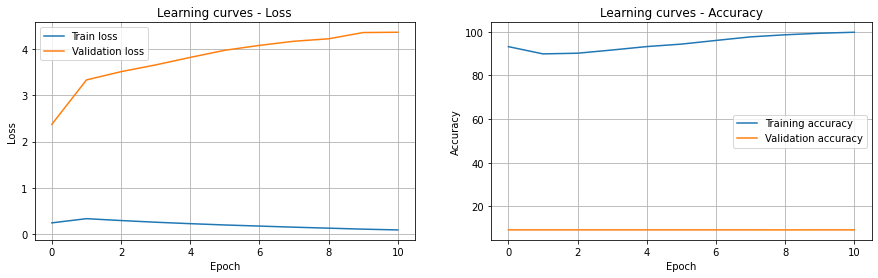

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 256, act = Sigmoid, opt = RMSprop, lr = 0.001, reg = Batch norm, max_features = 4935, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 1.94786 - train_loss: 0.14297 - val_acc: 9.42% - train_acc: 97.53% - balanced_accuracy: 0.50% - execution_time: 248s


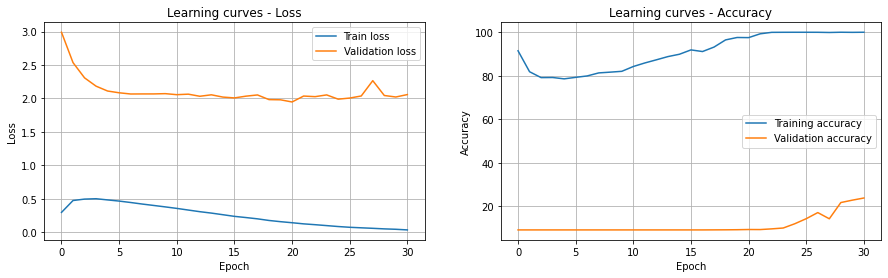

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 2048, act = GELU, opt = SGD, lr = 1e-05, reg = Batch norm, max_features = 2703, n_max = 2, vect_type = cv, approach = under


Best val_loss: 0.68060 - train_loss: 0.70467 - val_acc: 77.55% - train_acc: 53.10% - balanced_accuracy: 0.52% - execution_time: 36s


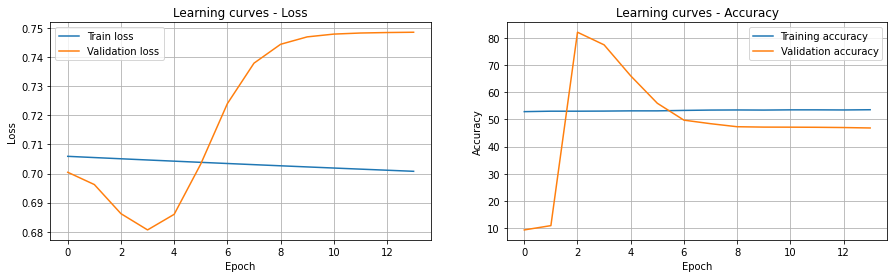

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 512, act = Sigmoid, opt = RMSprop, lr = 0.001, reg = Dropout, max_features = 2703, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 3.75134 - train_loss: 0.47797 - val_acc: 9.24% - train_acc: 81.46% - balanced_accuracy: 0.50% - execution_time: 86s


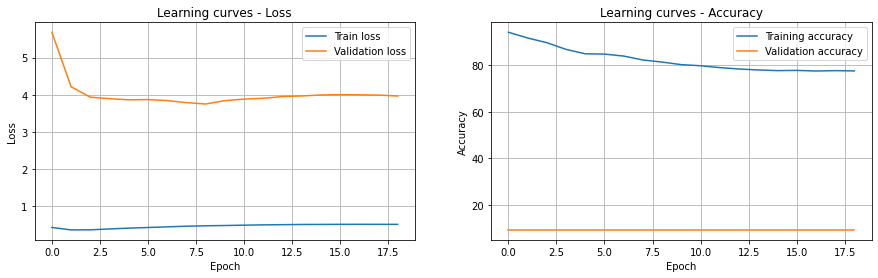

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 1024, act = LeakyReLU, opt = SGD, lr = 1e-05, reg = False, max_features = 2703, n_max = 2, vect_type = tfidf, approach = none



Best val_loss: 0.66705 - train_loss: 0.66711 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 258s


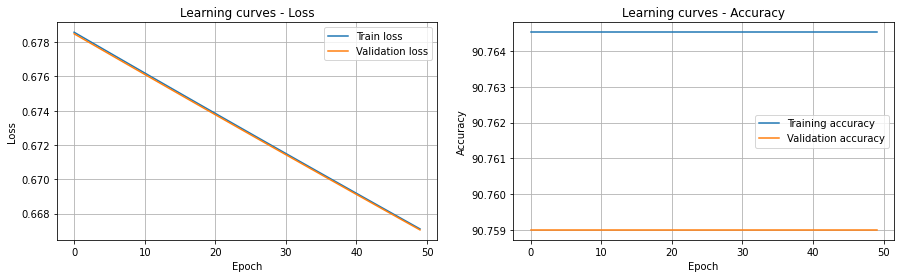

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 256, act = Softplus, opt = SGD, lr = 0.01, reg = Batch norm, max_features = 1000, n_max = 3, vect_type = tfidf, approach = mid


Best val_loss: 3.37909 - train_loss: 0.19830 - val_acc: 9.24% - train_acc: 94.70% - balanced_accuracy: 0.50% - execution_time: 19s


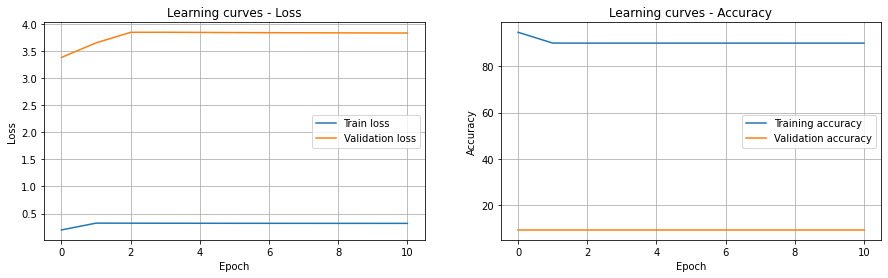

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 256, act = Sigmoid, opt = SGD, lr = 0.0001, reg = False, max_features = 1000, n_max = 3, vect_type = tfidf, approach = under


Best val_loss: 0.58204 - train_loss: 0.71181 - val_acc: 90.76% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 10s


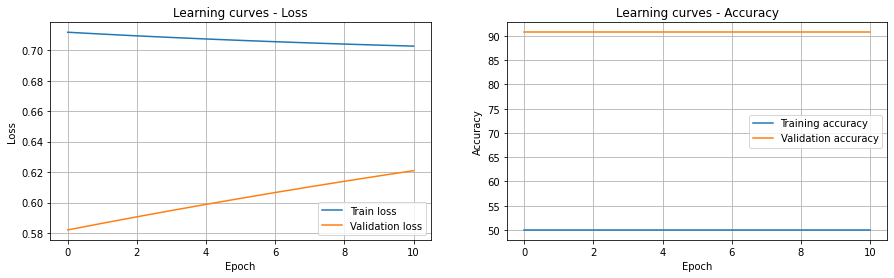

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 2048, act = GELU, opt = SGD, lr = 0.001, reg = False, max_features = 1900, n_max = 3, vect_type = tfidf, approach = none



Best val_loss: 0.35417 - train_loss: 0.35371 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 227s


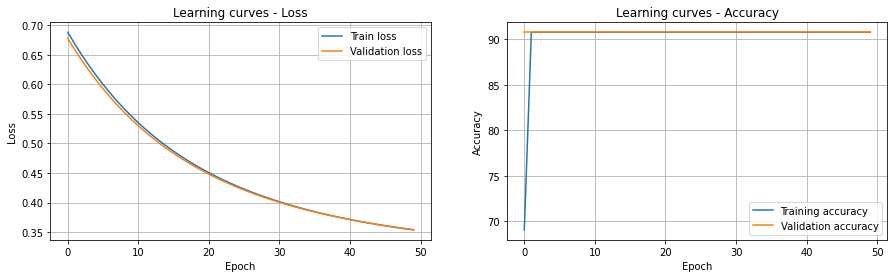

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 64, act = GELU, opt = SGD, lr = 0.001, reg = Batch norm, max_features = 1900, n_max = 1, vect_type = cv, approach = none



Best val_loss: 0.28047 - train_loss: 0.20790 - val_acc: 90.87% - train_acc: 91.97% - balanced_accuracy: 0.51% - execution_time: 201s


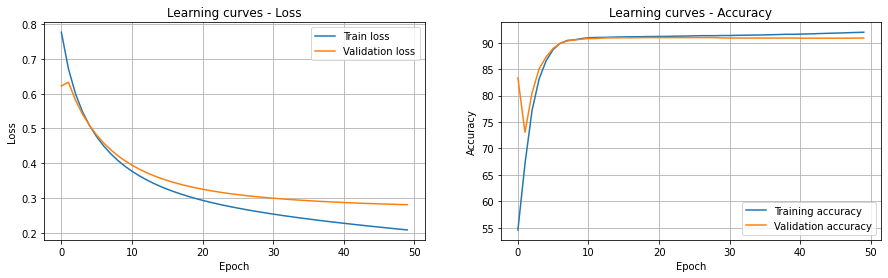

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = LeakyReLU, opt = SGD, lr = 1e-06, reg = False, max_features = 4935, n_max = 3, vect_type = tfidf, approach = none



Best val_loss: 0.68711 - train_loss: 0.68719 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 433s


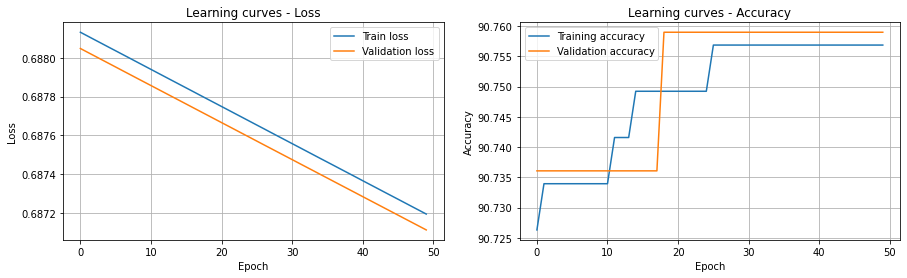

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 256, act = Softplus, opt = SGD, lr = 0.01, reg = Dropout, max_features = 1000, n_max = 1, vect_type = tfidf, approach = under



Best val_loss: 1.58379 - train_loss: 0.76023 - val_acc: 9.24% - train_acc: 56.87% - balanced_accuracy: 0.50% - execution_time: 44s


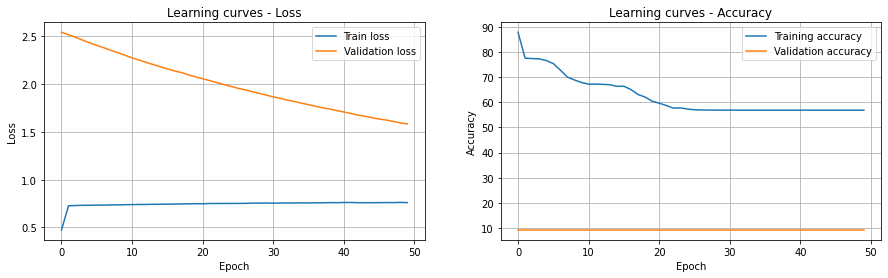

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 64, act = ELU, opt = RMSprop, lr = 0.01, reg = Dropout, max_features = 1900, n_max = 2, vect_type = cv, approach = under


Best val_loss: 1.50576 - train_loss: 0.51286 - val_acc: 47.97% - train_acc: 74.63% - balanced_accuracy: 0.68% - execution_time: 23s


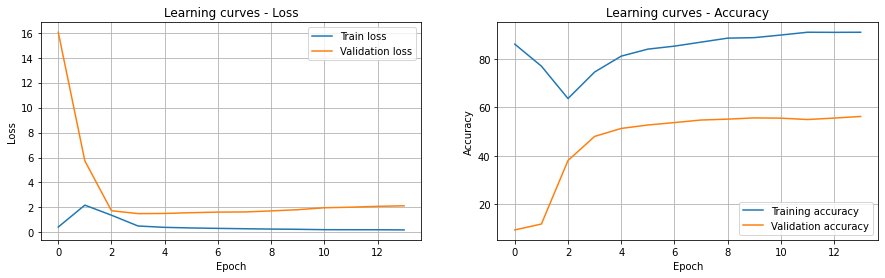

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 64, act = Sigmoid, opt = Adam, lr = 0.0001, reg = Dropout, max_features = 1900, n_max = 3, vect_type = cv, approach = mid


Best val_loss: 0.37188 - train_loss: 0.91075 - val_acc: 90.76% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 38s


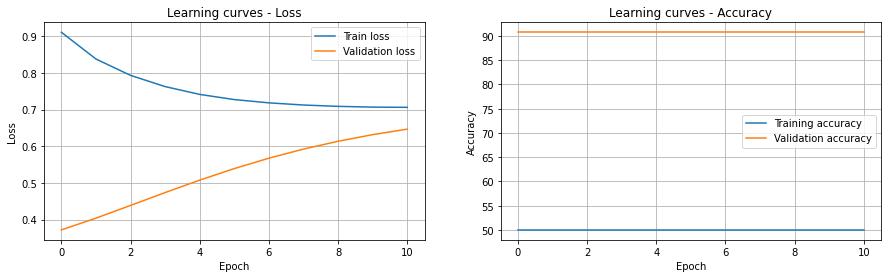

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 128, act = Sigmoid, opt = SGD, lr = 1e-05, reg = Batch norm, max_features = 1900, n_max = 3, vect_type = tfidf, approach = mid


Best val_loss: 0.85416 - train_loss: 0.71558 - val_acc: 9.24% - train_acc: 50.02% - balanced_accuracy: 0.50% - execution_time: 33s


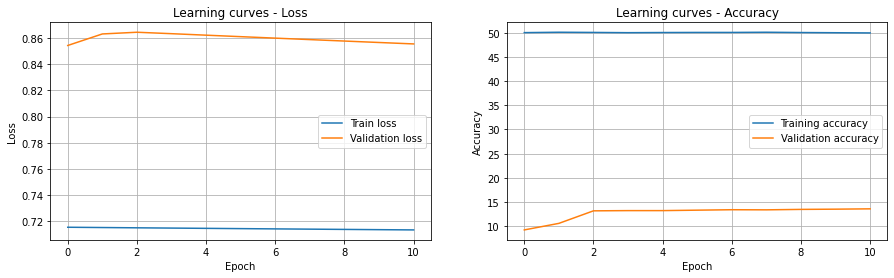

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 128, act = Softplus, opt = Adam, lr = 0.001, reg = Batch norm, max_features = 2703, n_max = 2, vect_type = cv, approach = none


Best val_loss: 0.25424 - train_loss: 0.20178 - val_acc: 90.97% - train_acc: 92.32% - balanced_accuracy: 0.59% - execution_time: 67s


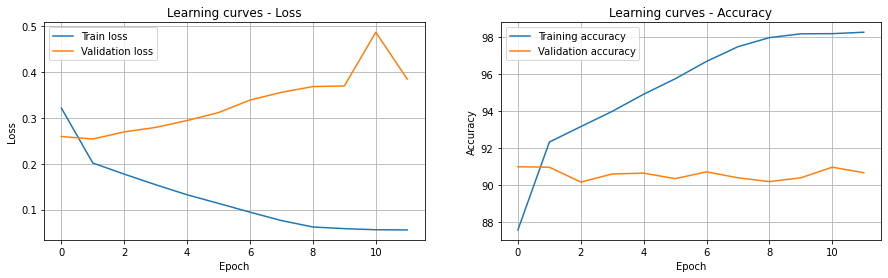

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 512, act = ELU, opt = SGD, lr = 0.01, reg = False, max_features = 1000, n_max = 3, vect_type = tfidf, approach = under


Best val_loss: 0.70655 - train_loss: 0.69738 - val_acc: 9.24% - train_acc: 39.57% - balanced_accuracy: 0.50% - execution_time: 10s


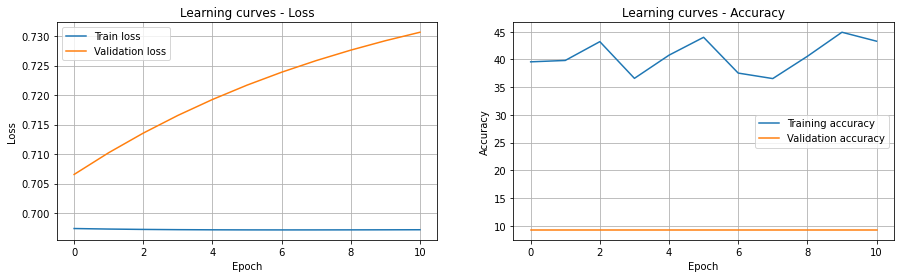

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 256, act = ELU, opt = Adam, lr = 0.001, reg = False, max_features = 1900, n_max = 3, vect_type = cv, approach = none


Best val_loss: 0.26110 - train_loss: 0.30112 - val_acc: 90.94% - train_acc: 91.04% - balanced_accuracy: 0.54% - execution_time: 47s


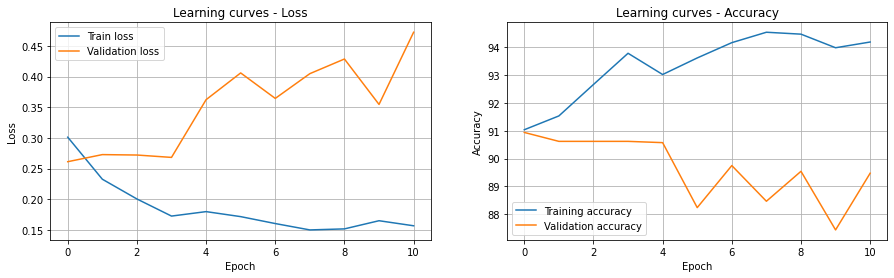

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 512, act = LeakyReLU, opt = RMSprop, lr = 1e-06, reg = False, max_features = 1900, n_max = 2, vect_type = tfidf, approach = none



Best val_loss: 0.51033 - train_loss: 0.51297 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 179s


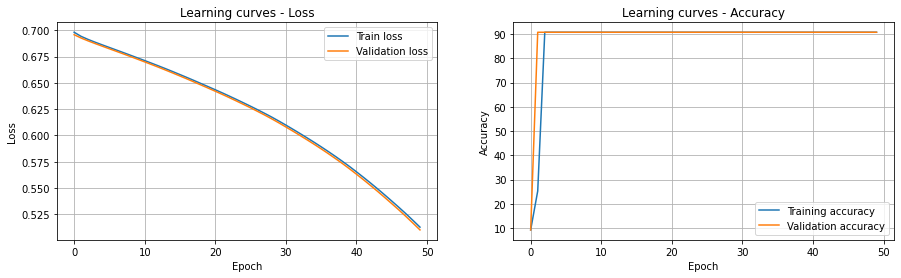

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 256, act = Softplus, opt = Adam, lr = 1e-06, reg = Batch norm, max_features = 1000, n_max = 3, vect_type = cv, approach = none



Best val_loss: 0.45309 - train_loss: 0.43732 - val_acc: 90.76% - train_acc: 91.38% - balanced_accuracy: 0.53% - execution_time: 125s


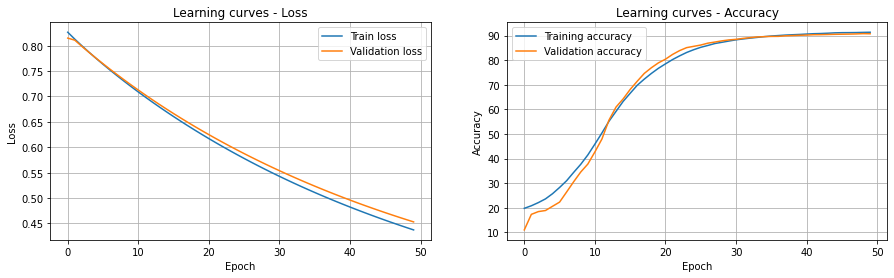

--------------------------------------------------------------------------------------------------------------------
RESULTS SORTED BY ACCURACY
Val_acc = 91.19 - Balanced_val_acc = 0.54 -> HL = 3, Nh = 1024, act = ELU      , opt = RMSprop, lr =  1e-05, reg = False, max_features = 2703, n_max = 3, vect_type = tfidf, approach = none
Val_acc = 91.08 - Balanced_val_acc = 0.53 -> HL = 1, Nh =  128, act = Softplus , opt = Adam   , lr = 0.0001, reg = Dropout, max_features = 4935, n_max = 2, vect_type = cv, approach = none
Val_acc = 90.97 - Balanced_val_acc = 0.59 -> HL = 2, Nh =  128, act = Softplus , opt = Adam   , lr =  0.001, reg = Batch norm, max_features = 2703, n_max = 2, vect_type = cv, approach = none
Val_acc = 90.94 - Balanced_val_acc = 0.54 -> HL = 6, Nh =  256, act = ELU      , opt = Adam   , lr =  0.001, reg = False, max_features = 1900, n_max = 3, vect_type = cv, approach = none
Val_acc = 90.92 - Balanced_val_acc = 0.51 -> HL = 1, Nh =  128, act = ELU      , opt = Adam   , lr =  

In [ ]:
## Change hyper-space

# Define possible values for each hyper-parameter
HL_v = [1,2,3,4,5,6]
Nh_v = [64, 128, 256, 512, 1024, 2048]
act_v = ['Sigmoid', 'LeakyReLU', 'ELU', 'GELU', 'Softplus']
act_dict = {'Sigmoid':nn.Sigmoid(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU(), 'GELU':nn.GELU(), 'Softplus':nn.Softplus()}
opt_v = ['Adam', 'RMSprop', 'SGD']
lr_v = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
reg_v = ['False', 'Dropout', 'Batch norm']
# wd_v = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# train_batch_size_v = [100, 250, 500, 1000]

max_features_v = [1000, 1900, 2703, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
vect_type_v = ['cv', 'tfidf']
approach_v = ['none', 'under', 'mid']

# max_features = 250
# n_min = 1 # , 2, 3]
# n_max = 1
# vect_type = 'cv'#, 'tfidf']
# approach = 'none'

results = []

# RANDOM SEARCH
random.seed(1)
pbar = tq.tqdm(total = 50, desc = 'Random search progress')
random_coarse_grid = list(itertools.product(HL_v, Nh_v, act_v, opt_v, lr_v, reg_v, max_features_v, n_max_v, vect_type_v, approach_v))
for (HL, Nh, act, opt, lr, reg, max_features, n_max, vect_type, approach) in random.sample(random_coarse_grid, 50):
    # sampling combinations from itertools.product, we are sure no combination is repeated
    print(f'FCNN with HL = {HL}, Nh = {Nh}, act = {act}, opt = {opt}, lr = {lr},'
          f' reg = {reg}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}')
    
    start_time = time.time()
    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    activation = act_dict[act]
    net = FCNet(max_features, Nh, 2, HL, activation, reg)
    net.to(device)

    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Define the optimizer
    # if reg == 'L2':
    #     opt_dict = {'Adam': optim.Adam(net.parameters(), lr =lr, weight_decay = wd),
    #                 'RMSprop': optim.RMSprop(net.parameters(), lr = lr, weight_decay = wd),
    #                 'SGD': optim.SGD(net.parameters(), lr = lr, weight_decay = wd)}
    #     optimizer = opt_dict[opt]
    # else:
    opt_dict = {'Adam': optim.Adam(net.parameters(), lr = lr), 
                'RMSprop': optim.RMSprop(net.parameters(), lr = lr),
                'SGD': optim.SGD(net.parameters(), lr = lr)}
    optimizer = opt_dict[opt]

    # Dataloader definition
    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

    train_dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)
    val_dataset = MyDataset(X_val_v, y_val, transform=composed_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=False, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=250, shuffle=False, num_workers=0)

    # TRAINING LOOP
    num_epochs = 50
    patience = 10
    train_loss_log, val_loss_log, best_t_loss, best_v_loss, train_accuracy_log, val_accuracy_log, best_t_acc, best_v_acc, bacc, net = training_loop(net, 
                            train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch=0, patience=patience)
    
    results.append((np.round(best_v_acc, 2), np.round(bacc, 2), f'HL = {HL}, Nh = {Nh:4}, act = {act:9}, opt = {opt:7}, lr = {lr:6},'
                                             f' reg = {reg}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}'))
    run_time = time.time() - start_time
    print(f'Best val_loss: {best_v_loss:.5f} - train_loss: {best_t_loss:.5f} - val_acc: {best_v_acc:.2f}% - train_acc: {best_t_acc:.2f}% - balanced_accuracy: {bacc:.2f}% - execution_time: {run_time:.0f}s') 
    
    plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log)
    print('--------------------------------------------------------------------------------------------------------------------')
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

More flexible architecture

FCNN with HL = 2, Nh = 128-128, act = Sigmoid, opt = Adam, lr = 0.001, reg = False, max_features = 4935, n_max = 1, vect_type = tfidf, approach = mid


Best val_loss: 0.64621 - train_loss: 0.96707 - val_acc: 90.76% - train_acc: 40.16% - balanced_accuracy: 0.50% - execution_time: 90s


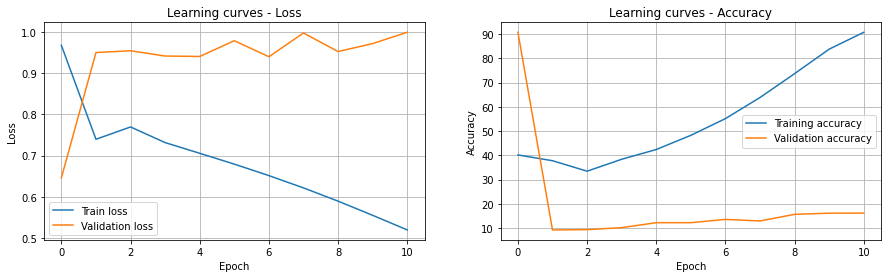

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 256-256-256-256-128-128, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = Dropout, max_features = 1000, n_max = 3, vect_type = cv, approach = under



Best val_loss: 1.00525 - train_loss: 0.04697 - val_acc: 33.96% - train_acc: 99.75% - balanced_accuracy: 0.55% - execution_time: 47s


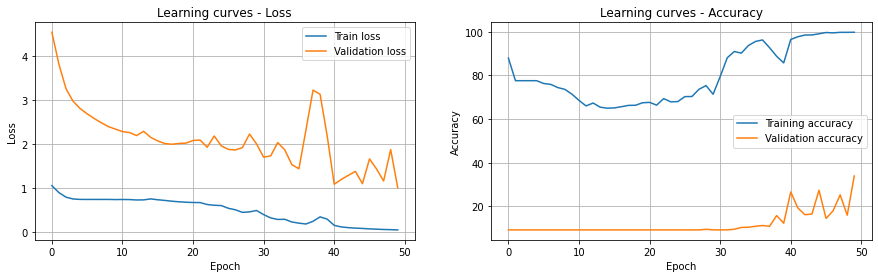

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 512, act = Sigmoid, opt = Adam, lr = 0.01, reg = Dropout, max_features = 4935, n_max = 1, vect_type = tfidf, approach = none


Best val_loss: 0.29043 - train_loss: 0.33612 - val_acc: 90.67% - train_acc: 90.18% - balanced_accuracy: 0.55% - execution_time: 103s


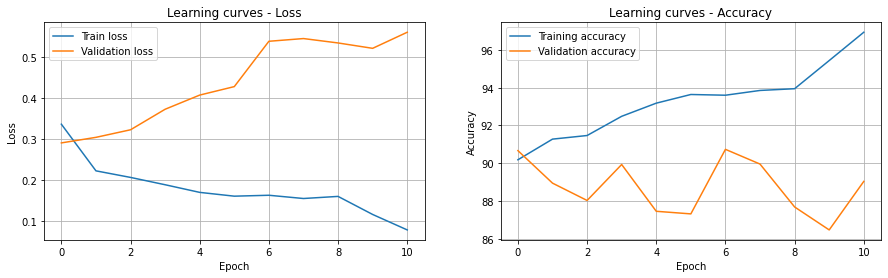

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 256-256-512, act = Sigmoid, opt = Adam, lr = 0.0001, reg = Dropout, max_features = 1900, n_max = 1, vect_type = cv, approach = none


Best val_loss: 0.25324 - train_loss: 0.23781 - val_acc: 91.22% - train_acc: 91.29% - balanced_accuracy: 0.55% - execution_time: 51s


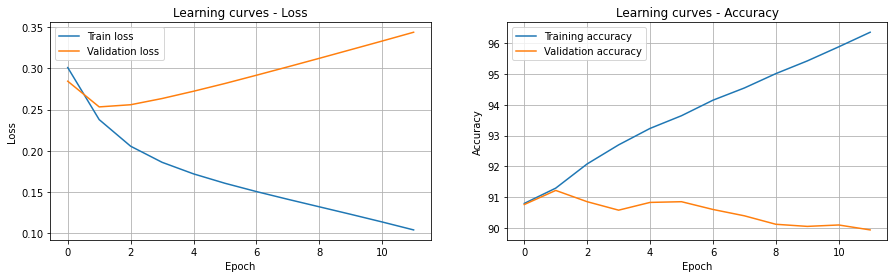

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 64-64, act = Sigmoid, opt = Adam, lr = 0.001, reg = False, max_features = 1900, n_max = 2, vect_type = cv, approach = under


Best val_loss: 0.55810 - train_loss: 0.77169 - val_acc: 90.76% - train_acc: 45.53% - balanced_accuracy: 0.50% - execution_time: 19s


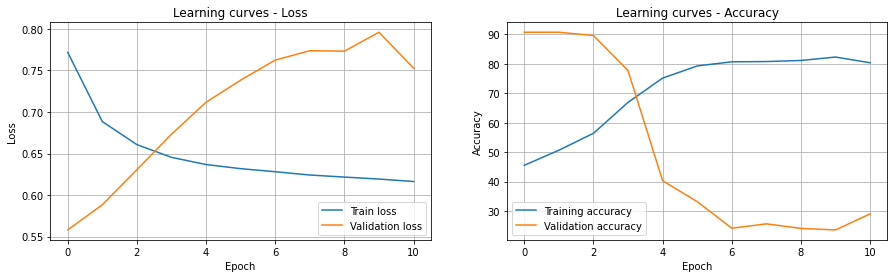

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 1024-1024-128-128-64, act = Sigmoid, opt = Adam, lr = 1e-06, reg = Batch norm, max_features = 1000, n_max = 2, vect_type = cv, approach = none



Best val_loss: 0.53903 - train_loss: 0.52878 - val_acc: 85.32% - train_acc: 87.65% - balanced_accuracy: 0.66% - execution_time: 130s


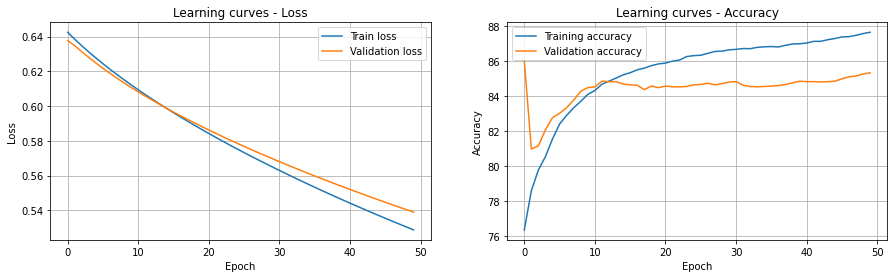

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 128-128-512-512-256, act = Sigmoid, opt = Adam, lr = 1e-06, reg = False, max_features = 4935, n_max = 1, vect_type = cv, approach = mid



Best val_loss: 0.80669 - train_loss: 0.68370 - val_acc: 9.26% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 436s


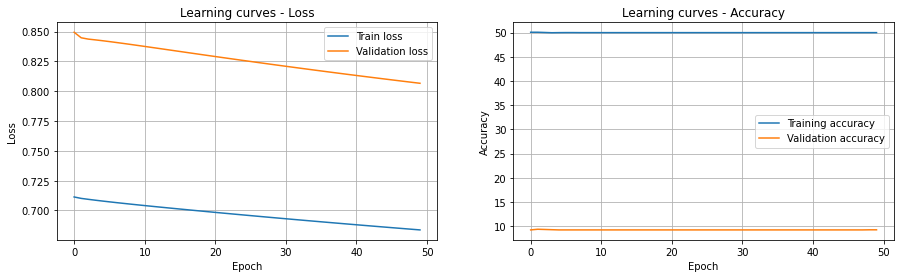

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 256-256-2048-2048-128, act = Sigmoid, opt = Adam, lr = 1e-06, reg = Dropout, max_features = 1900, n_max = 3, vect_type = cv, approach = under


Best val_loss: 0.55468 - train_loss: 0.72277 - val_acc: 90.76% - train_acc: 49.54% - balanced_accuracy: 0.50% - execution_time: 18s


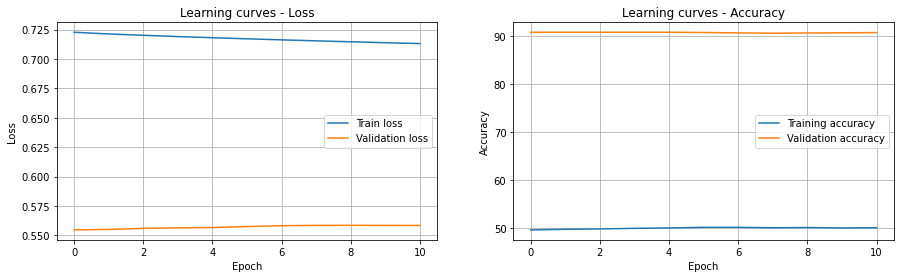

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 512-512-512-512, act = Sigmoid, opt = Adam, lr = 1e-05, reg = Dropout, max_features = 4935, n_max = 1, vect_type = tfidf, approach = none


Best val_loss: 0.27325 - train_loss: 0.17073 - val_acc: 90.23% - train_acc: 94.86% - balanced_accuracy: 0.62% - execution_time: 198s


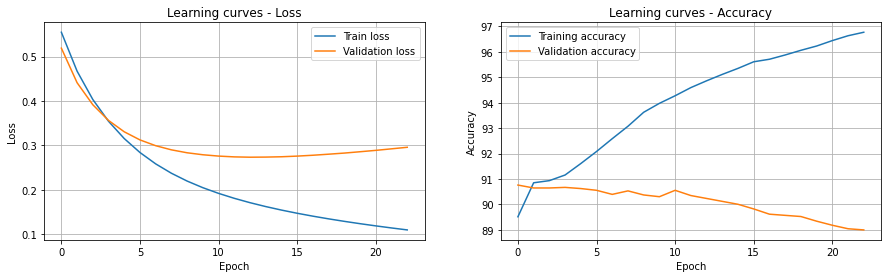

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 2048-2048, act = Sigmoid, opt = Adam, lr = 0.001, reg = Batch norm, max_features = 4935, n_max = 3, vect_type = tfidf, approach = none


Best val_loss: 0.28120 - train_loss: 0.19732 - val_acc: 89.91% - train_acc: 91.97% - balanced_accuracy: 0.60% - execution_time: 117s


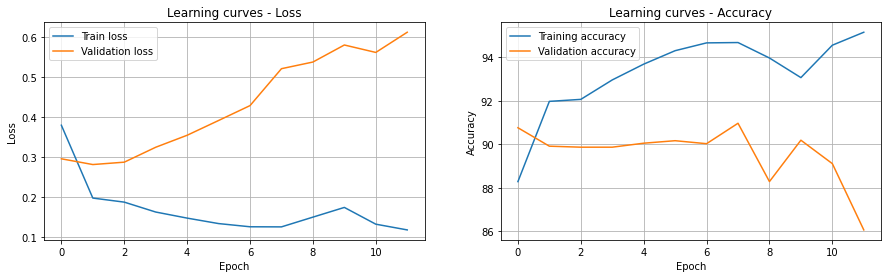

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 2048, act = Sigmoid, opt = Adam, lr = 0.01, reg = Batch norm, max_features = 2703, n_max = 3, vect_type = cv, approach = none


Best val_loss: 0.30347 - train_loss: 0.89868 - val_acc: 90.90% - train_acc: 86.95% - balanced_accuracy: 0.55% - execution_time: 66s


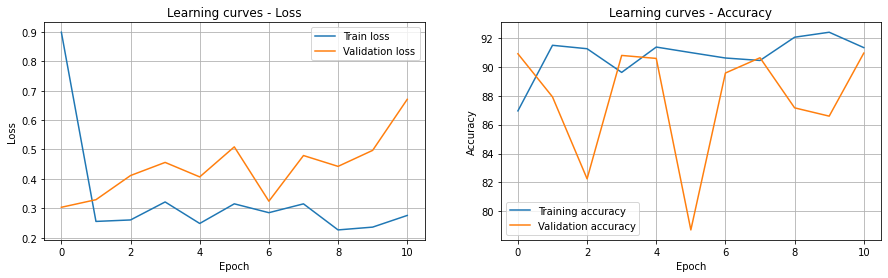

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 512-512-1024-1024-512, act = Sigmoid, opt = Adam, lr = 1e-06, reg = Dropout, max_features = 4935, n_max = 2, vect_type = tfidf, approach = none



Best val_loss: 0.32477 - train_loss: 0.26106 - val_acc: 88.99% - train_acc: 93.86% - balanced_accuracy: 0.63% - execution_time: 488s


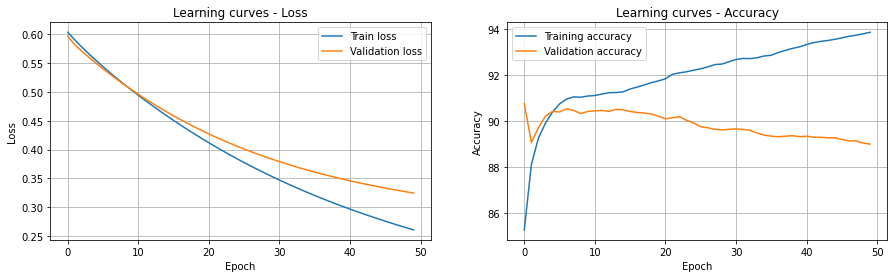

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = Sigmoid, opt = Adam, lr = 0.01, reg = False, max_features = 4935, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.39033 - train_loss: 2.05044 - val_acc: 90.76% - train_acc: 40.44% - balanced_accuracy: 0.50% - execution_time: 36s


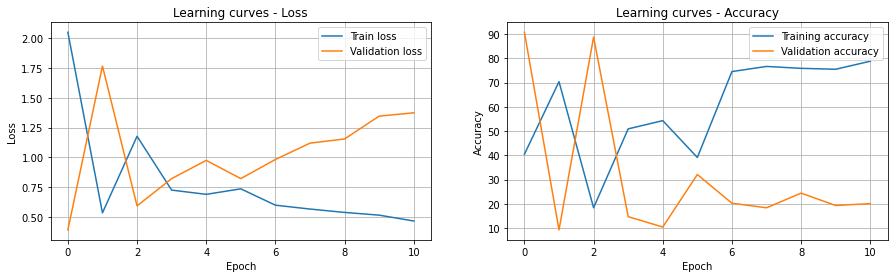

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 1024-1024-128-128, act = Sigmoid, opt = Adam, lr = 1e-05, reg = Batch norm, max_features = 1000, n_max = 2, vect_type = cv, approach = none



Best val_loss: 0.26009 - train_loss: 0.13414 - val_acc: 91.56% - train_acc: 96.82% - balanced_accuracy: 0.59% - execution_time: 123s


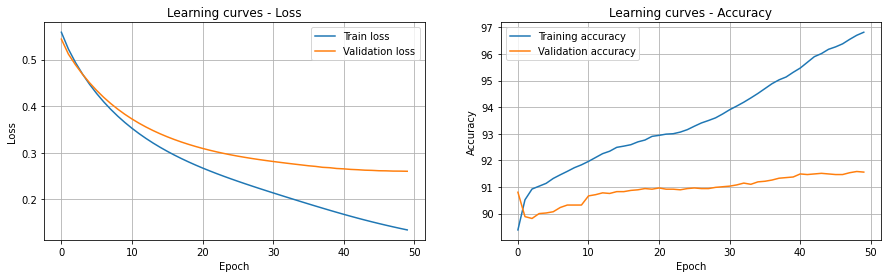

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 64-64-512-512-1024, act = Sigmoid, opt = Adam, lr = 1e-06, reg = False, max_features = 1900, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.87735 - train_loss: 0.71747 - val_acc: 9.24% - train_acc: 50.04% - balanced_accuracy: 0.50% - execution_time: 16s


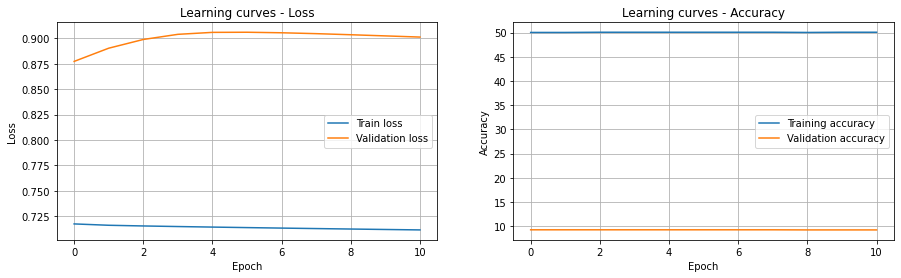

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 1024-1024-512-512-256-256, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = Batch norm, max_features = 1900, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 4.06104 - train_loss: 0.23638 - val_acc: 9.24% - train_acc: 92.32% - balanced_accuracy: 0.50% - execution_time: 144s


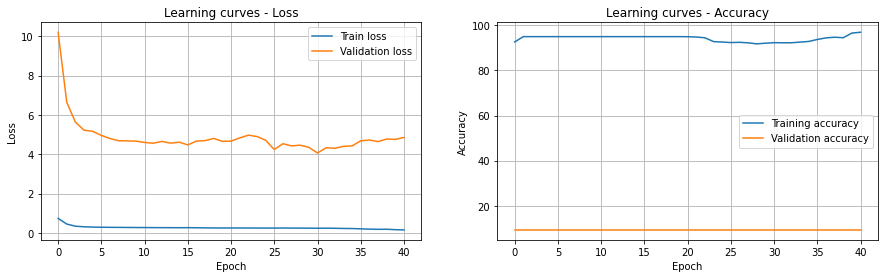

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = Sigmoid, opt = Adam, lr = 0.01, reg = False, max_features = 1000, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.35451 - train_loss: 1.54570 - val_acc: 90.76% - train_acc: 49.75% - balanced_accuracy: 0.50% - execution_time: 9s


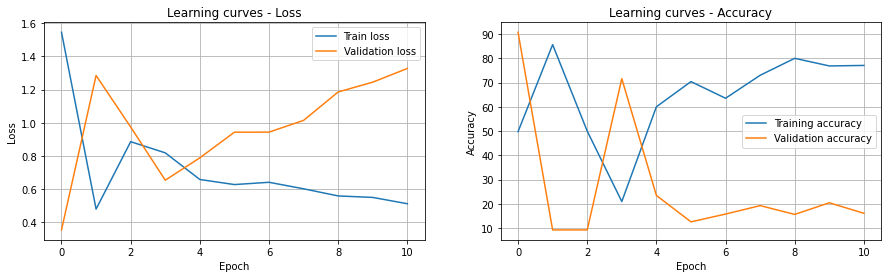

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 128-128-256-256-64, act = Sigmoid, opt = Adam, lr = 1e-06, reg = False, max_features = 2703, n_max = 3, vect_type = cv, approach = none



Best val_loss: 0.51981 - train_loss: 0.51040 - val_acc: 88.35% - train_acc: 89.61% - balanced_accuracy: 0.58% - execution_time: 287s


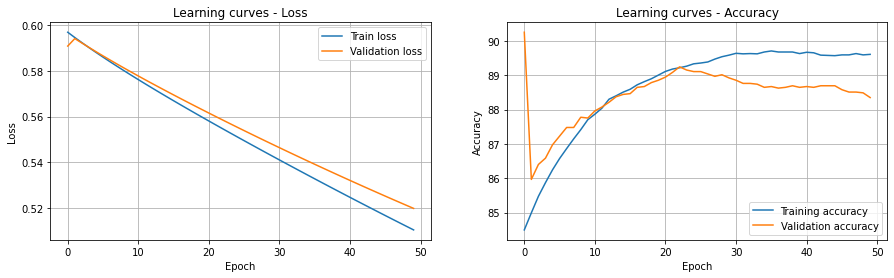

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 512-512-64, act = Sigmoid, opt = Adam, lr = 0.0001, reg = Dropout, max_features = 2703, n_max = 1, vect_type = tfidf, approach = mid


Best val_loss: 0.77545 - train_loss: 0.58434 - val_acc: 14.06% - train_acc: 98.12% - balanced_accuracy: 0.48% - execution_time: 190s


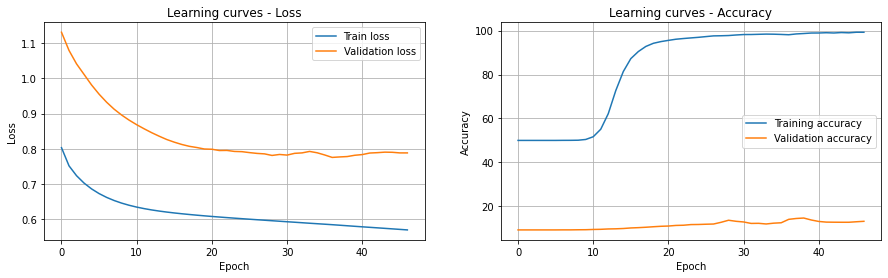

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 128-128-64, act = Sigmoid, opt = Adam, lr = 0.0001, reg = False, max_features = 2703, n_max = 1, vect_type = cv, approach = none


Best val_loss: 0.26600 - train_loss: 0.17167 - val_acc: 90.67% - train_acc: 94.22% - balanced_accuracy: 0.58% - execution_time: 120s


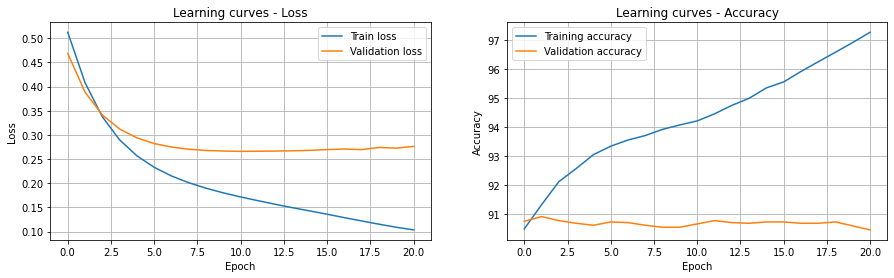

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 512-512-512-512-1024-1024, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = Dropout, max_features = 4935, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 4.61834 - train_loss: 1.44262 - val_acc: 9.24% - train_acc: 77.57% - balanced_accuracy: 0.50% - execution_time: 119s


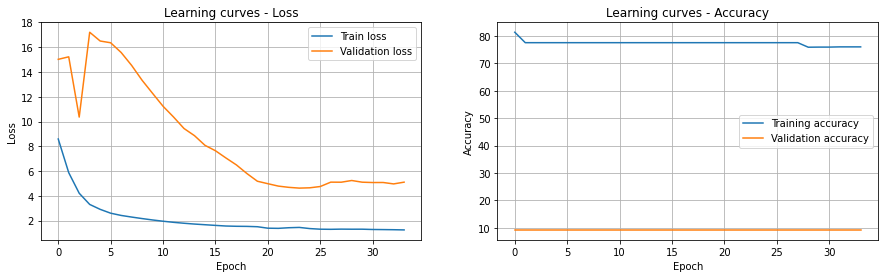

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 2048, act = Sigmoid, opt = Adam, lr = 0.01, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = tfidf, approach = mid


Best val_loss: 2.95480 - train_loss: 0.06722 - val_acc: 40.33% - train_acc: 98.40% - balanced_accuracy: 0.56% - execution_time: 185s


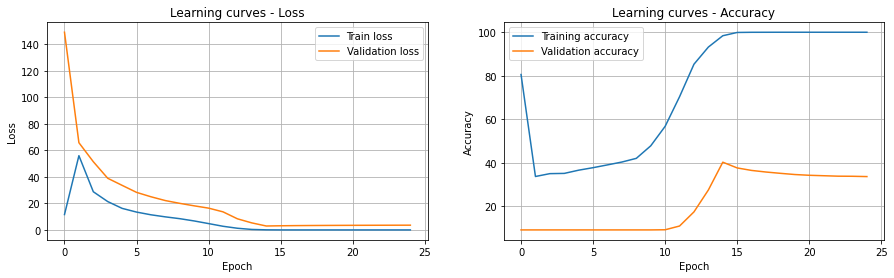

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 64-64-64-64, act = Sigmoid, opt = Adam, lr = 1e-05, reg = False, max_features = 1000, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 0.60065 - train_loss: 0.70849 - val_acc: 90.76% - train_acc: 48.46% - balanced_accuracy: 0.50% - execution_time: 22s


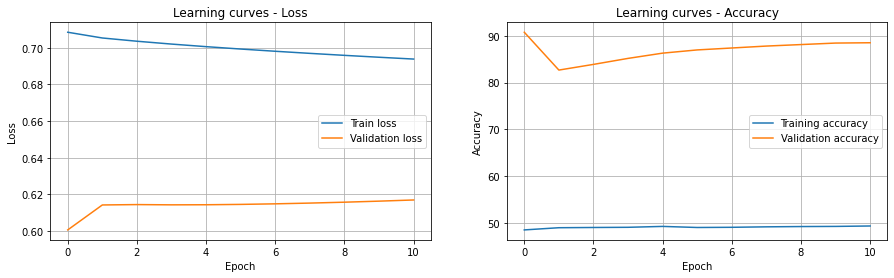

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = Sigmoid, opt = Adam, lr = 0.01, reg = False, max_features = 4935, n_max = 2, vect_type = cv, approach = mid


Best val_loss: 2.10087 - train_loss: 0.05060 - val_acc: 15.96% - train_acc: 98.62% - balanced_accuracy: 0.51% - execution_time: 202s


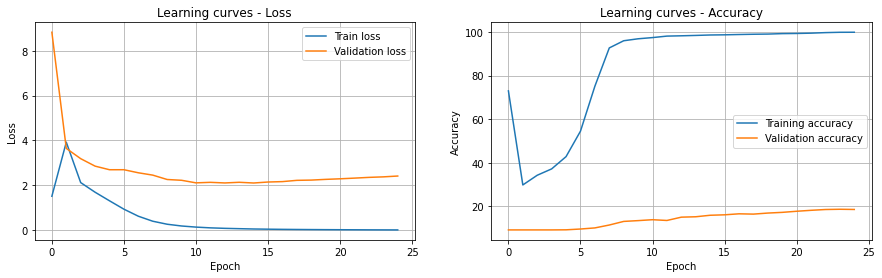

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = Sigmoid, opt = Adam, lr = 0.01, reg = False, max_features = 2703, n_max = 2, vect_type = tfidf, approach = none


Best val_loss: 0.25826 - train_loss: 0.21738 - val_acc: 91.03% - train_acc: 91.45% - balanced_accuracy: 0.53% - execution_time: 58s


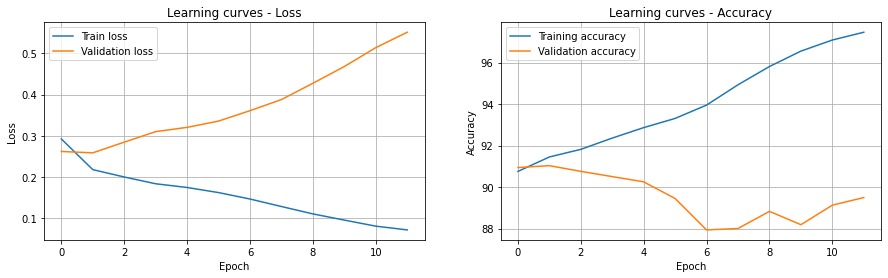

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = Sigmoid, opt = Adam, lr = 0.01, reg = False, max_features = 2703, n_max = 3, vect_type = tfidf, approach = under


Best val_loss: 0.40529 - train_loss: 2.10096 - val_acc: 90.76% - train_acc: 49.96% - balanced_accuracy: 0.50% - execution_time: 23s


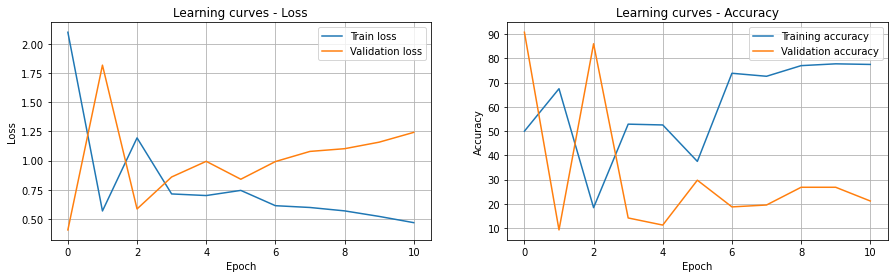

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 64-64-1024-1024-1024-1024, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = False, max_features = 1900, n_max = 2, vect_type = tfidf, approach = under



Best val_loss: 3.58085 - train_loss: 0.90380 - val_acc: 12.80% - train_acc: 77.48% - balanced_accuracy: 0.50% - execution_time: 76s


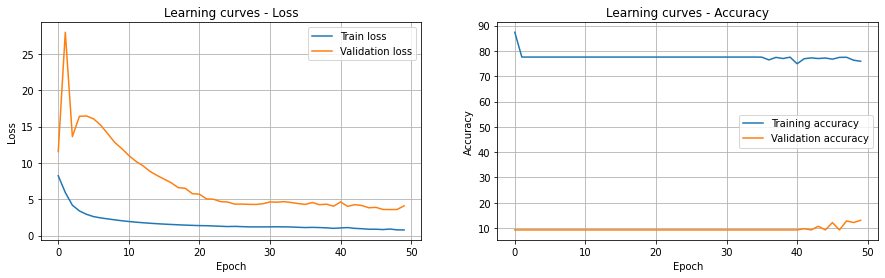

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = Sigmoid, opt = Adam, lr = 0.01, reg = False, max_features = 1900, n_max = 1, vect_type = cv, approach = none


Best val_loss: 0.26301 - train_loss: 0.22556 - val_acc: 90.69% - train_acc: 91.49% - balanced_accuracy: 0.55% - execution_time: 50s


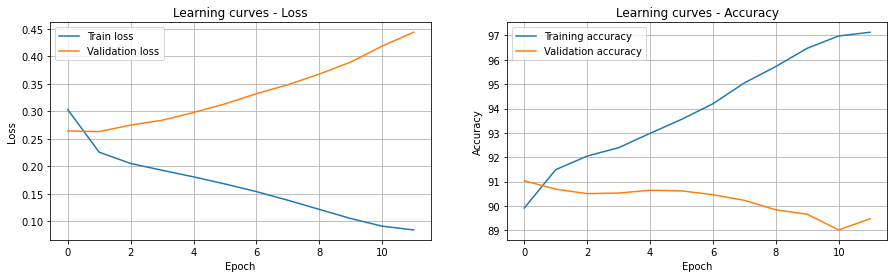

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 512-512-1024-1024, act = Sigmoid, opt = Adam, lr = 1e-05, reg = Dropout, max_features = 4935, n_max = 2, vect_type = cv, approach = none


Best val_loss: 0.26431 - train_loss: 0.16585 - val_acc: 90.58% - train_acc: 94.84% - balanced_accuracy: 0.63% - execution_time: 199s


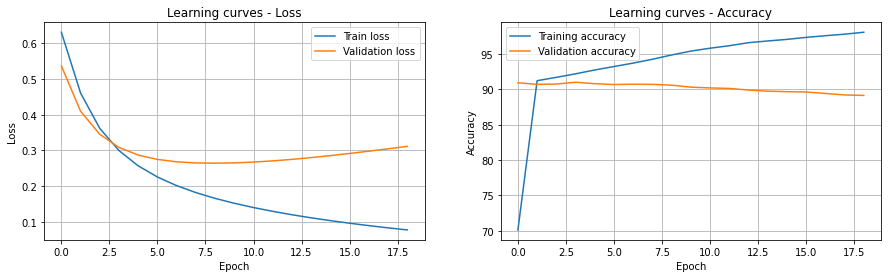

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 64-64-128, act = Sigmoid, opt = Adam, lr = 0.0001, reg = False, max_features = 1000, n_max = 2, vect_type = tfidf, approach = mid


Best val_loss: 0.66729 - train_loss: 0.72838 - val_acc: 90.76% - train_acc: 31.61% - balanced_accuracy: 0.50% - execution_time: 20s


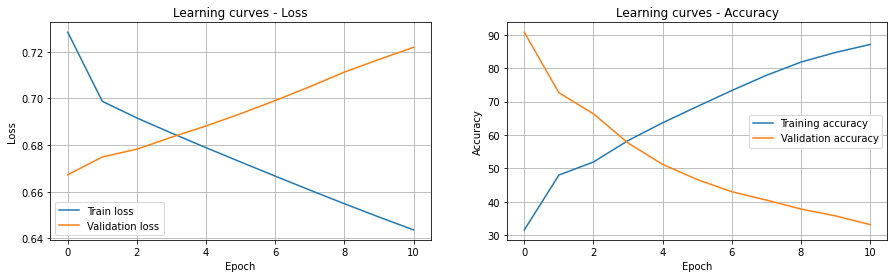

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 64-64-64-64-64, act = Sigmoid, opt = Adam, lr = 1e-06, reg = False, max_features = 1000, n_max = 1, vect_type = cv, approach = none



Best val_loss: 0.84142 - train_loss: 0.84429 - val_acc: 9.63% - train_acc: 9.73% - balanced_accuracy: 0.50% - execution_time: 127s


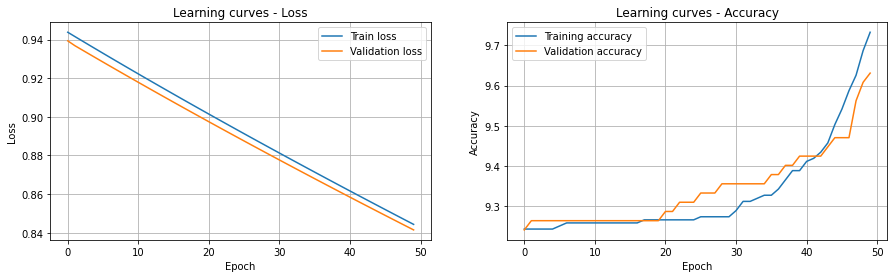

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = Sigmoid, opt = Adam, lr = 0.01, reg = False, max_features = 4935, n_max = 1, vect_type = tfidf, approach = mid


Best val_loss: 1.89778 - train_loss: 0.06324 - val_acc: 17.22% - train_acc: 99.52% - balanced_accuracy: 0.49% - execution_time: 142s


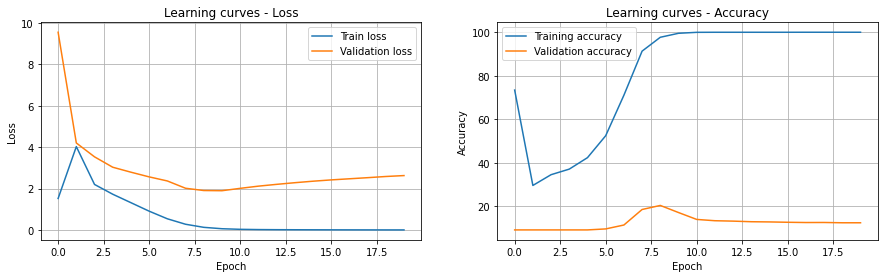

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 64-64-64-64-64-64, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = False, max_features = 1000, n_max = 1, vect_type = cv, approach = none


Best val_loss: 0.28616 - train_loss: 0.21964 - val_acc: 90.09% - train_acc: 91.15% - balanced_accuracy: 0.56% - execution_time: 33s


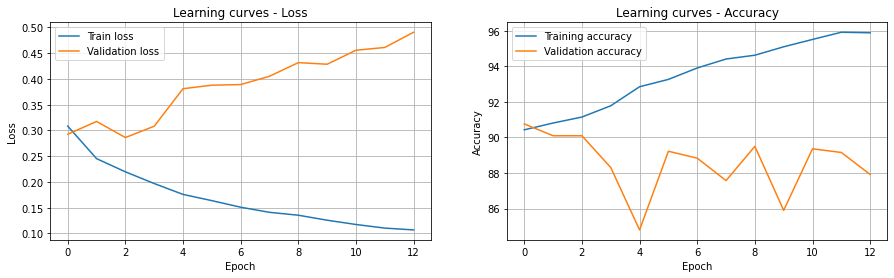

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 64-64-512, act = Sigmoid, opt = Adam, lr = 0.0001, reg = False, max_features = 1900, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.64818 - train_loss: 0.74401 - val_acc: 90.76% - train_acc: 29.55% - balanced_accuracy: 0.50% - execution_time: 17s


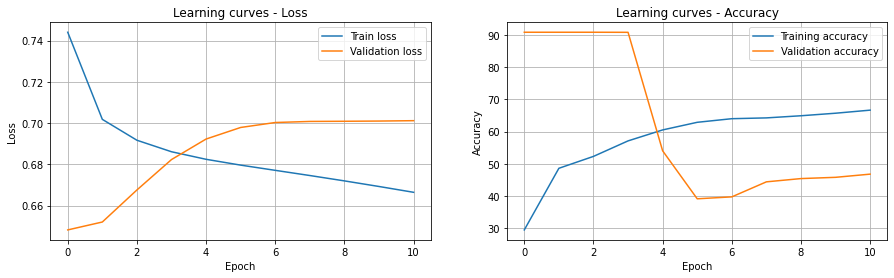

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 64-64-2048-2048-256, act = Sigmoid, opt = Adam, lr = 1e-06, reg = False, max_features = 1900, n_max = 3, vect_type = cv, approach = mid


Best val_loss: 0.56552 - train_loss: 0.71050 - val_acc: 90.76% - train_acc: 49.72% - balanced_accuracy: 0.50% - execution_time: 43s


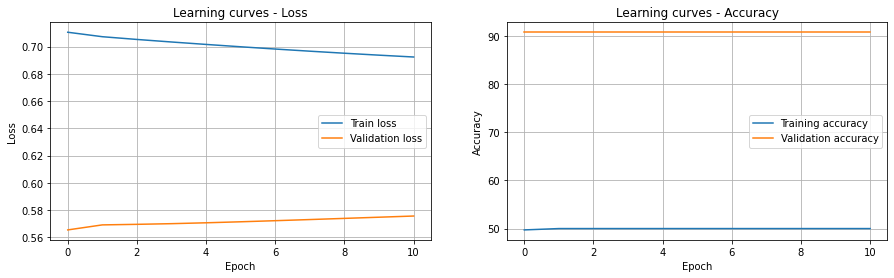

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 1024-1024-128-128-128, act = Sigmoid, opt = Adam, lr = 1e-06, reg = Batch norm, max_features = 1000, n_max = 2, vect_type = cv, approach = under



Best val_loss: 1.04877 - train_loss: 0.73523 - val_acc: 9.24% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 53s


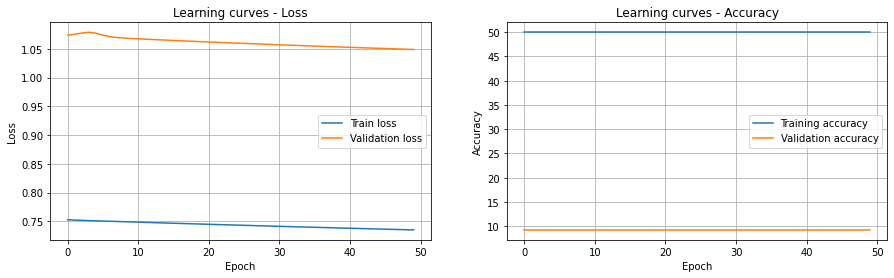

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 128-128-256-256-1024-1024, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = False, max_features = 2703, n_max = 3, vect_type = tfidf, approach = under



Best val_loss: 3.62875 - train_loss: 1.06943 - val_acc: 9.75% - train_acc: 77.57% - balanced_accuracy: 0.50% - execution_time: 98s


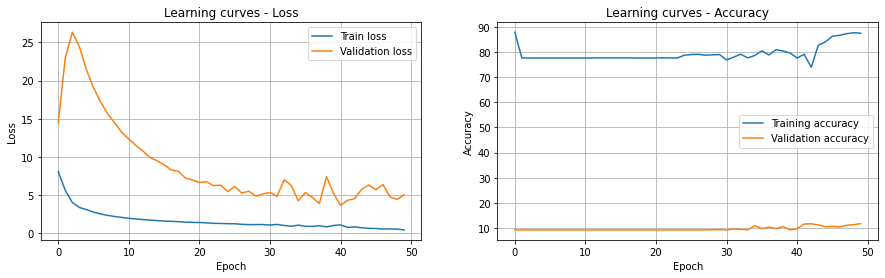

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 128-128-128, act = Sigmoid, opt = Adam, lr = 0.0001, reg = False, max_features = 2703, n_max = 2, vect_type = tfidf, approach = none


Best val_loss: 0.25668 - train_loss: 0.19319 - val_acc: 90.85% - train_acc: 92.65% - balanced_accuracy: 0.58% - execution_time: 78s


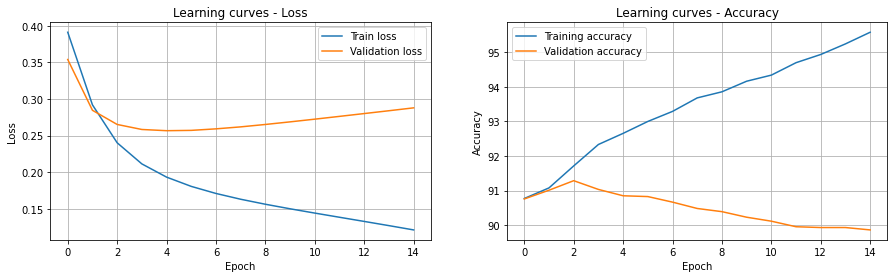

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 128-128-512-512, act = Sigmoid, opt = Adam, lr = 1e-05, reg = False, max_features = 4935, n_max = 1, vect_type = tfidf, approach = mid


Best val_loss: 0.45149 - train_loss: 0.78190 - val_acc: 90.76% - train_acc: 50.00% - balanced_accuracy: 0.50% - execution_time: 76s


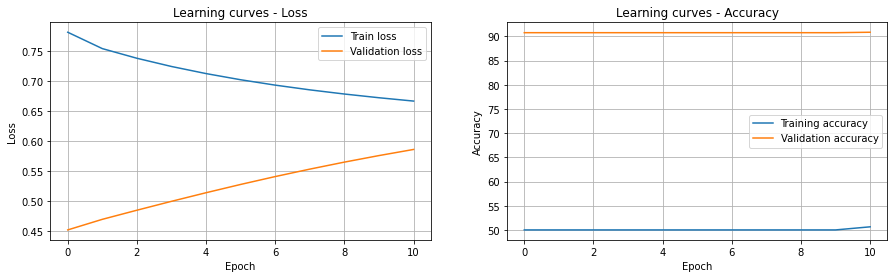

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 128-128-64, act = Sigmoid, opt = Adam, lr = 0.0001, reg = False, max_features = 2703, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.57359 - train_loss: 0.72438 - val_acc: 90.76% - train_acc: 49.67% - balanced_accuracy: 0.50% - execution_time: 22s


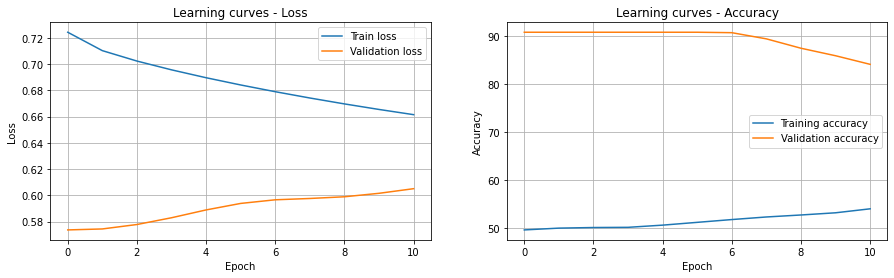

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 64-64-256, act = Sigmoid, opt = Adam, lr = 0.0001, reg = False, max_features = 1000, n_max = 3, vect_type = tfidf, approach = under


Best val_loss: 0.71456 - train_loss: 0.67603 - val_acc: 35.15% - train_acc: 63.04% - balanced_accuracy: 0.58% - execution_time: 17s


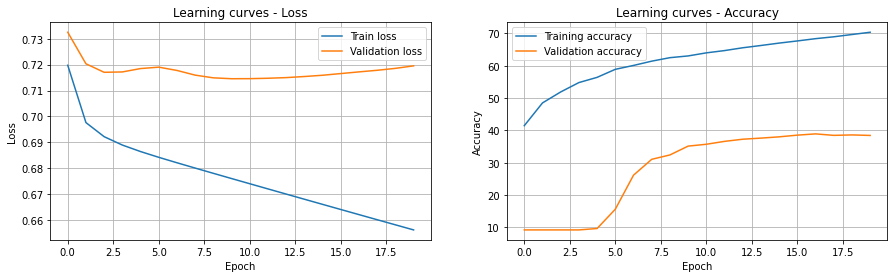

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 5, Nh = 256-256-64-64-2048, act = Sigmoid, opt = Adam, lr = 1e-06, reg = Dropout, max_features = 1000, n_max = 1, vect_type = tfidf, approach = mid



Best val_loss: 0.72036 - train_loss: 0.68725 - val_acc: 25.57% - train_acc: 55.42% - balanced_accuracy: 0.55% - execution_time: 97s


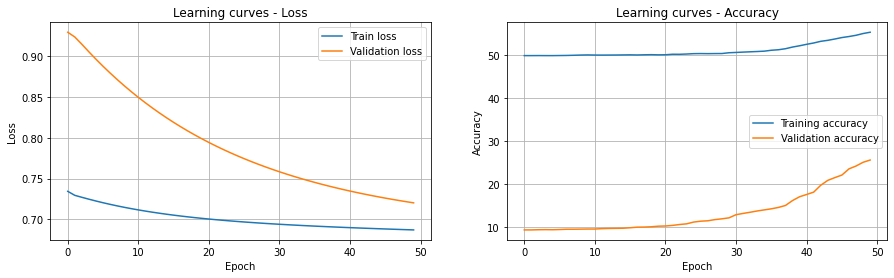

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 1024-1024-256, act = Sigmoid, opt = Adam, lr = 0.0001, reg = Batch norm, max_features = 1000, n_max = 3, vect_type = tfidf, approach = mid


Best val_loss: 0.59917 - train_loss: 0.75372 - val_acc: 90.76% - train_acc: 44.23% - balanced_accuracy: 0.50% - execution_time: 21s


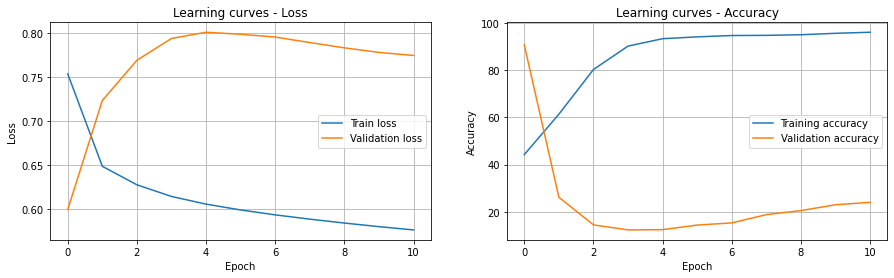

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = Sigmoid, opt = Adam, lr = 0.01, reg = False, max_features = 2703, n_max = 2, vect_type = cv, approach = mid


Best val_loss: 1.91909 - train_loss: 0.02253 - val_acc: 21.92% - train_acc: 99.34% - balanced_accuracy: 0.54% - execution_time: 133s


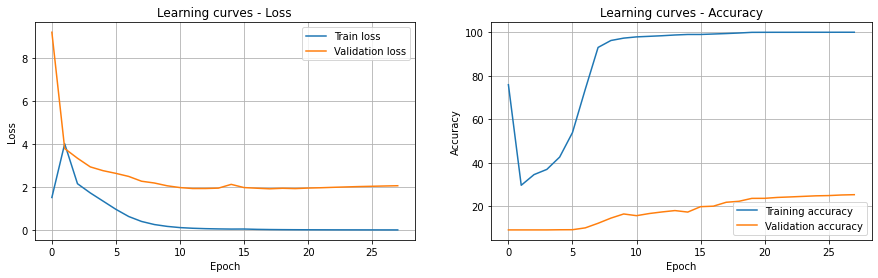

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 2048-2048-1024-1024, act = Sigmoid, opt = Adam, lr = 1e-05, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = cv, approach = none


Best val_loss: 0.26910 - train_loss: 0.17113 - val_acc: 90.37% - train_acc: 95.31% - balanced_accuracy: 0.64% - execution_time: 190s


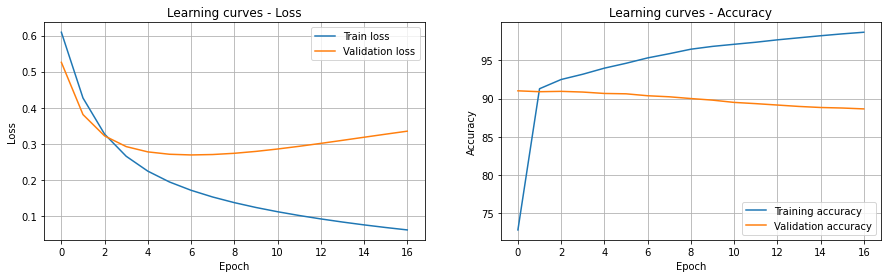

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 128-128-512-512-2048-2048, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = False, max_features = 4935, n_max = 1, vect_type = tfidf, approach = mid



Best val_loss: 4.86416 - train_loss: 0.24964 - val_acc: 9.24% - train_acc: 95.00% - balanced_accuracy: 0.50% - execution_time: 372s


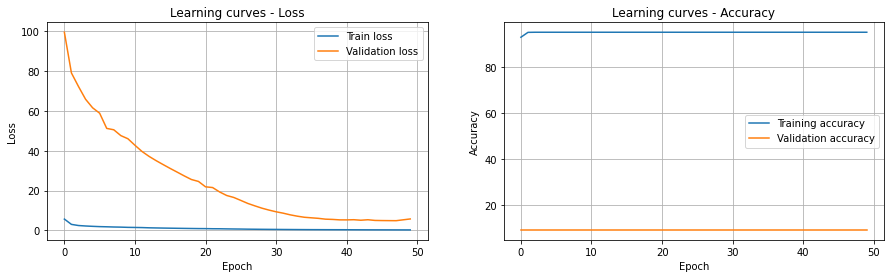

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 2048, act = Sigmoid, opt = Adam, lr = 0.01, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = cv, approach = none


Best val_loss: 0.26757 - train_loss: 0.80942 - val_acc: 90.97% - train_acc: 87.11% - balanced_accuracy: 0.53% - execution_time: 115s


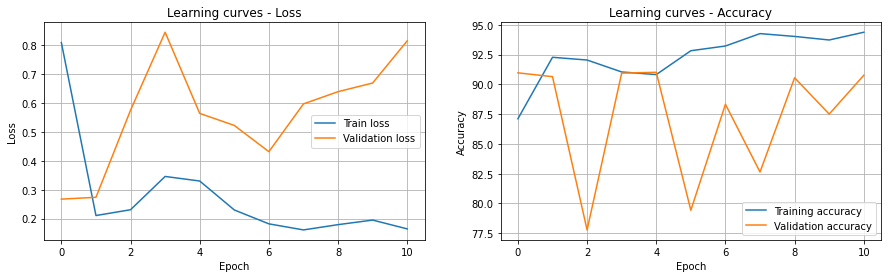

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 1024-1024, act = Sigmoid, opt = Adam, lr = 0.001, reg = Batch norm, max_features = 1900, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 1.91729 - train_loss: 0.03115 - val_acc: 25.32% - train_acc: 99.92% - balanced_accuracy: 0.53% - execution_time: 156s


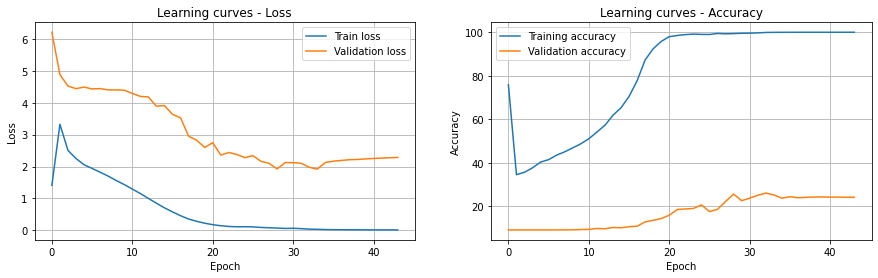

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 2048-2048-1024-1024-1024-1024, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = tfidf, approach = under



Best val_loss: 3.51403 - train_loss: 0.76800 - val_acc: 9.24% - train_acc: 76.61% - balanced_accuracy: 0.50% - execution_time: 202s


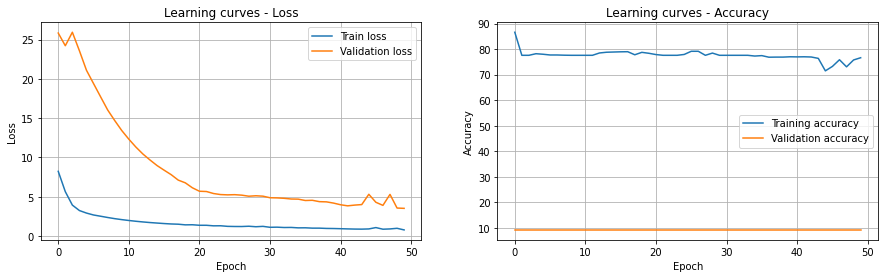

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 1024-1024-2048, act = Sigmoid, opt = Adam, lr = 0.0001, reg = Batch norm, max_features = 1900, n_max = 3, vect_type = cv, approach = under


Best val_loss: 0.42744 - train_loss: 0.96076 - val_acc: 90.76% - train_acc: 49.54% - balanced_accuracy: 0.50% - execution_time: 20s


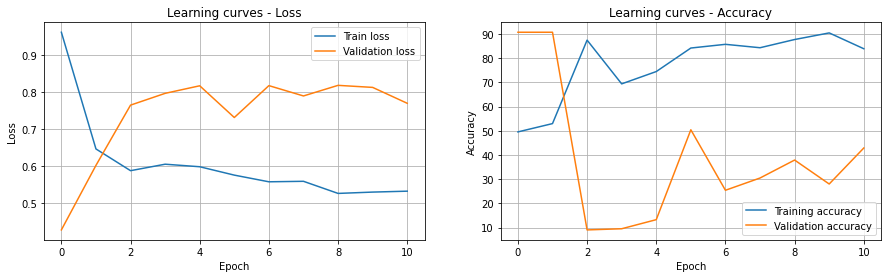

--------------------------------------------------------------------------------------------------------------------
RESULTS SORTED BY ACCURACY
Val_acc = 91.56 - Balanced_val_acc = 0.59 -> HL = 4, Nh = 1024-1024-128-128, act = Sigmoid  , opt = Adam   , lr =  1e-05, reg = Batch norm, max_features = 1000, n_max = 2, vect_type = cv, approach = none
Val_acc = 91.22 - Balanced_val_acc = 0.55 -> HL = 3, Nh = 256-256-512, act = Sigmoid  , opt = Adam   , lr = 0.0001, reg = Dropout, max_features = 1900, n_max = 1, vect_type = cv, approach = none
Val_acc = 91.03 - Balanced_val_acc = 0.53 -> HL = 1, Nh = 128, act = Sigmoid  , opt = Adam   , lr =   0.01, reg = False, max_features = 2703, n_max = 2, vect_type = tfidf, approach = none
Val_acc = 90.97 - Balanced_val_acc = 0.53 -> HL = 1, Nh = 2048, act = Sigmoid  , opt = Adam   , lr =   0.01, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = cv, approach = none
Val_acc = 90.90 - Balanced_val_acc = 0.55 -> HL = 1, Nh = 2048, act = Sigmoid 

In [ ]:
## FFNNmod with restricted hyper-space

# Define possible values for each hyper-parameter
HL_v = [1,2,3,4,5,6]
Nh_v = [64, 128, 256, 512, 1024, 2048]
act_v = ['Sigmoid', 'LeakyReLU', 'ELU', 'GELU', 'Softplus']
act_dict = {'Sigmoid':nn.Sigmoid(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU(), 'GELU':nn.GELU(), 'Softplus':nn.Softplus()}
opt_v = ['Adam', 'RMSprop', 'SGD']
lr_v = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
reg_v = ['False', 'Dropout', 'Batch norm']
# wd_v = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# train_batch_size_v = [100, 250, 500, 1000]

max_features_v = [1000, 1900, 2703, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
vect_type_v = ['cv', 'tfidf']
approach_v = ['none', 'under', 'mid']

# max_features = 250
# n_min = 1 # , 2, 3]
# n_max = 1
# vect_type = 'cv'#, 'tfidf']
# approach = 'none'

results = []

# RANDOM SEARCH
random.seed(1)
pbar = tq.tqdm(total = 50, desc = 'Random search progress')

# random_coarse_grid = list(itertools.product(HL_v, Nh_v, Nh_v, Nh_v, Nh_v, Nh_v, Nh_v, act_v, opt_v, lr_v, reg_v, max_features_v, n_max_v, vect_type_v, approach_v))

random_coarse_grid_1 = list(itertools.product(HL_v, Nh_v, Nh_v, Nh_v))
random_coarse_grid_2 = list(itertools.product(act_v, opt_v, lr_v, reg_v, max_features_v, n_max_v, vect_type_v, approach_v))
random_coarse_grid = [x + y for x, y in zip(random_coarse_grid_1, random_coarse_grid_2)] 


for (HL, Nh1, Nh3, Nh5, act, opt, lr, reg, max_features, n_max, vect_type, approach) in random.sample(random_coarse_grid, 50):
    # sampling combinations from itertools.product, we are sure no combination is repeated
    Nh2 = Nh1
    Nh4 = Nh3
    Nh6 = Nh5

    print(f'FCNN with HL = {HL}, Nh = {Nh1}{-Nh2 if HL >= 2 else ""}{-Nh3 if HL >= 3 else ""}{-Nh4 if HL >= 4 else ""}{-Nh5 if HL >= 5 else ""}{-Nh6 if HL >= 6 else ""}, act = {act}, opt = {opt}, lr = {lr},'
          f' reg = {reg}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}')
    
    start_time = time.time()
    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    activation = act_dict[act]
    net = FCNetmod(max_features, Nh1, Nh2, Nh3, Nh4, Nh5, Nh6, 2, HL, activation, reg)
    net.to(device)

    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Define the optimizer
    # if reg == 'L2':
    #     opt_dict = {'Adam': optim.Adam(net.parameters(), lr =lr, weight_decay = wd),
    #                 'RMSprop': optim.RMSprop(net.parameters(), lr = lr, weight_decay = wd),
    #                 'SGD': optim.SGD(net.parameters(), lr = lr, weight_decay = wd)}
    #     optimizer = opt_dict[opt]
    # else:
    opt_dict = {'Adam': optim.Adam(net.parameters(), lr = lr), 
                'RMSprop': optim.RMSprop(net.parameters(), lr = lr),
                'SGD': optim.SGD(net.parameters(), lr = lr)}
    optimizer = opt_dict[opt]

    # Dataloader definition
    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

    train_dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)
    val_dataset = MyDataset(X_val_v, y_val, transform=composed_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=False, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=250, shuffle=False, num_workers=0)

    # TRAINING LOOP
    num_epochs = 50
    patience = 10
    train_loss_log, val_loss_log, best_t_loss, best_v_loss, train_accuracy_log, val_accuracy_log, best_t_acc, best_v_acc, bacc, net = training_loop(net, 
                            train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch=0, patience=patience)
    
    results.append((np.round(best_v_acc, 2), np.round(bacc, 2), f'HL = {HL}, Nh = {Nh1}{-Nh2 if HL >= 2 else ""}{-Nh3 if HL >= 3 else ""}{-Nh4 if HL >= 4 else ""}{-Nh5 if HL >= 5 else ""}{-Nh6 if HL >= 6 else ""}, act = {act:9}, opt = {opt:7}, lr = {lr:6},'
                                             f' reg = {reg}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}'))
    run_time = time.time() - start_time
    print(f'Best val_loss: {best_v_loss:.5f} - train_loss: {best_t_loss:.5f} - val_acc: {best_v_acc:.2f}% - train_acc: {best_t_acc:.2f}% - balanced_accuracy: {bacc:.2f}% - execution_time: {run_time:.0f}s') 
    
    plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log)
    print('--------------------------------------------------------------------------------------------------------------------')
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

FCNN with HL = 1, Nh = 512, act = Sigmoid, opt = Adam, lr = 0.0001, reg = Dropout, max_features = 2703, n_max = 2, vect_type = tfidf, approach = under


Best val_loss: 0.54576 - train_loss: 0.76156 - val_acc: 90.76% - train_acc: 47.31% - balanced_accuracy: 0.50% - execution_time: 34s


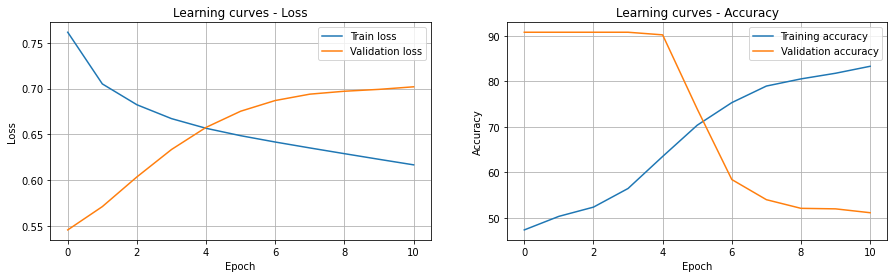

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 64-64-2048, act = LeakyReLU, opt = SGD, lr = 0.01, reg = Batch norm, max_features = 1900, n_max = 2, vect_type = tfidf, approach = none


Best val_loss: 0.27452 - train_loss: 0.21775 - val_acc: 90.32% - train_acc: 91.31% - balanced_accuracy: 0.54% - execution_time: 55s


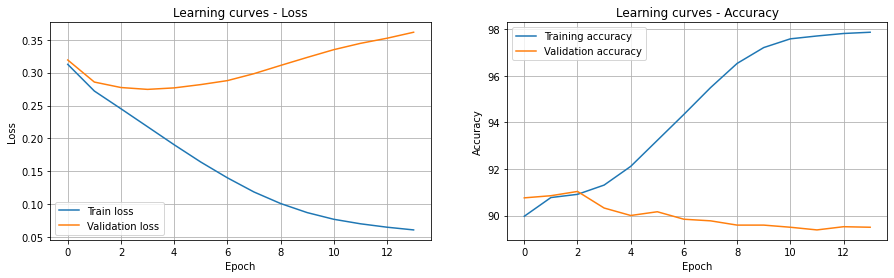

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 2048-2048-256, act = GELU, opt = SGD, lr = 1e-06, reg = Dropout, max_features = 1900, n_max = 3, vect_type = cv, approach = mid


Best val_loss: 0.74239 - train_loss: 0.71672 - val_acc: 35.24% - train_acc: 50.85% - balanced_accuracy: 0.47% - execution_time: 57s


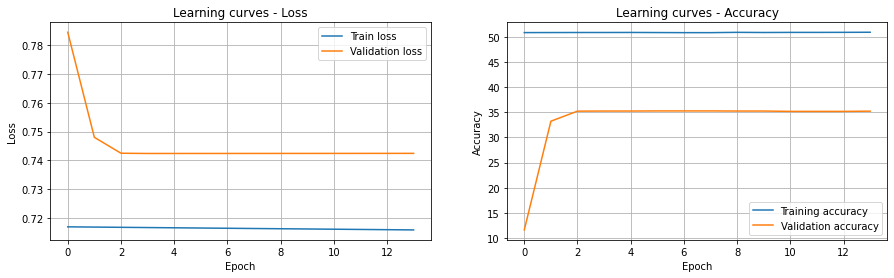

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = GELU, opt = Adam, lr = 0.001, reg = False, max_features = 2703, n_max = 2, vect_type = cv, approach = none


Best val_loss: 0.25116 - train_loss: 0.17864 - val_acc: 91.29% - train_acc: 93.20% - balanced_accuracy: 0.60% - execution_time: 75s


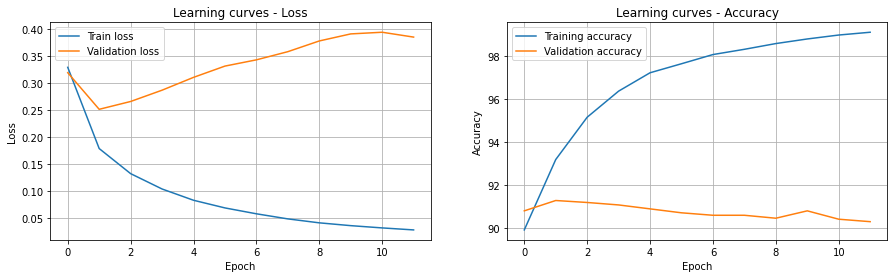

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 2048, act = Softplus, opt = Adam, lr = 1e-06, reg = Batch norm, max_features = 2703, n_max = 1, vect_type = cv, approach = none



Best val_loss: 0.27412 - train_loss: 0.24406 - val_acc: 90.99% - train_acc: 91.20% - balanced_accuracy: 0.52% - execution_time: 315s


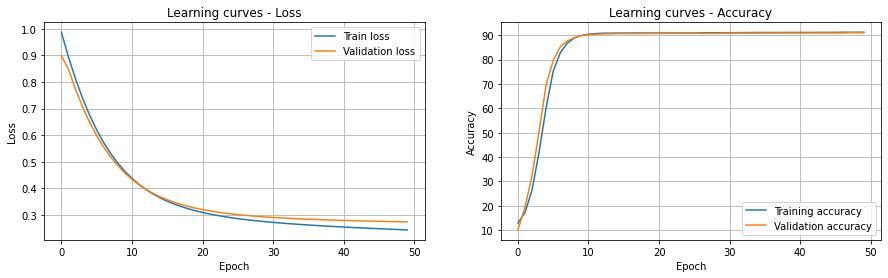

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 256, act = ELU, opt = Adam, lr = 0.0001, reg = False, max_features = 2703, n_max = 3, vect_type = cv, approach = mid


Best val_loss: 0.67526 - train_loss: 0.71964 - val_acc: 71.91% - train_acc: 51.67% - balanced_accuracy: 0.45% - execution_time: 57s


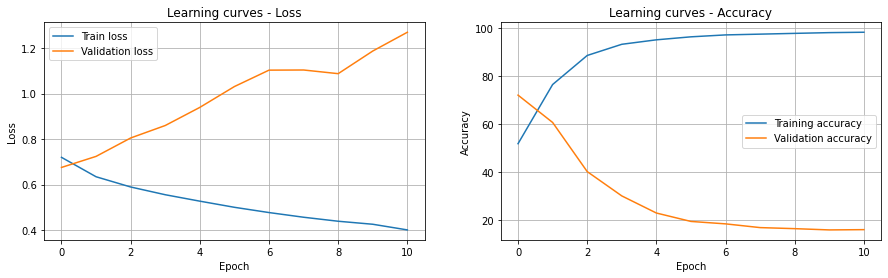

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 2048-2048, act = Softplus, opt = RMSprop, lr = 1e-06, reg = Dropout, max_features = 1000, n_max = 3, vect_type = cv, approach = under


Best val_loss: 0.61240 - train_loss: 0.69757 - val_acc: 89.04% - train_acc: 53.93% - balanced_accuracy: 0.50% - execution_time: 16s


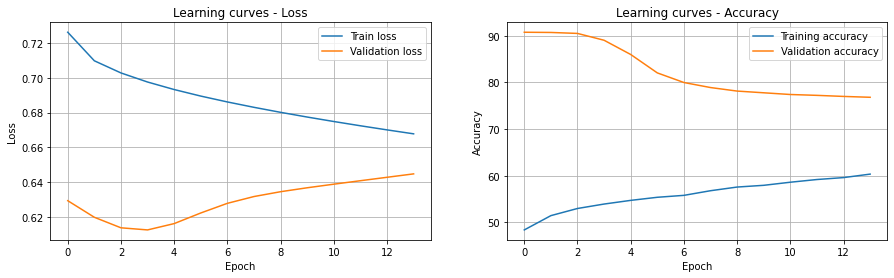

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 2048-2048-128, act = LeakyReLU, opt = SGD, lr = 1e-06, reg = Dropout, max_features = 1900, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 0.63316 - train_loss: 0.73459 - val_acc: 83.86% - train_acc: 49.74% - balanced_accuracy: 0.50% - execution_time: 39s


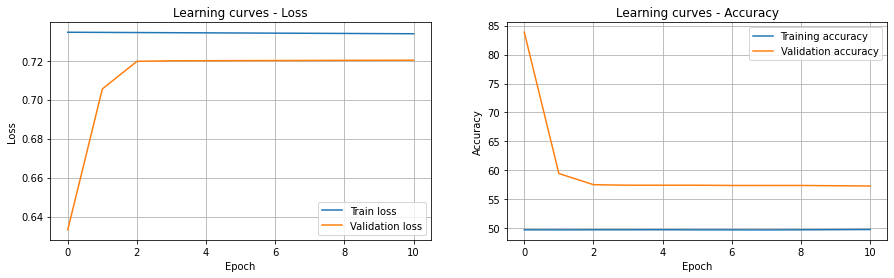

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 1024-1024, act = LeakyReLU, opt = RMSprop, lr = 1e-05, reg = Dropout, max_features = 2703, n_max = 1, vect_type = tfidf, approach = mid


Best val_loss: 0.44826 - train_loss: 0.75890 - val_acc: 90.76% - train_acc: 49.61% - balanced_accuracy: 0.50% - execution_time: 48s


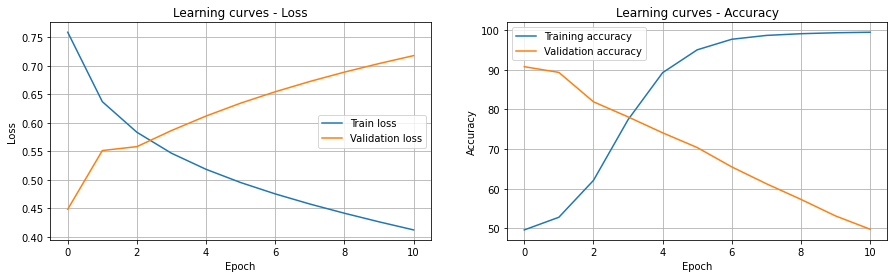

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 1024-1024, act = Softplus, opt = RMSprop, lr = 1e-05, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = cv, approach = mid


Best val_loss: 0.42846 - train_loss: 0.91406 - val_acc: 90.71% - train_acc: 49.93% - balanced_accuracy: 0.50% - execution_time: 96s


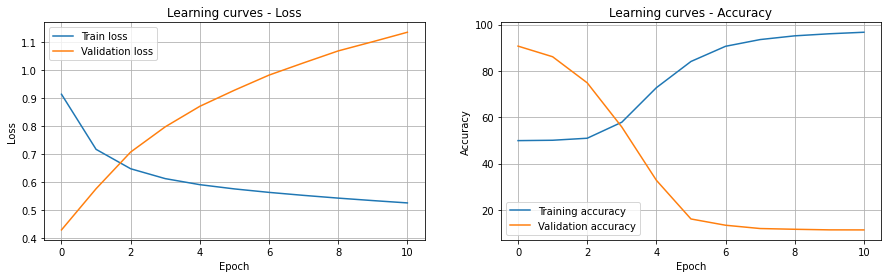

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 256-256-1024, act = GELU, opt = SGD, lr = 0.0001, reg = Dropout, max_features = 1000, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.69549 - train_loss: 0.72911 - val_acc: 48.80% - train_acc: 50.41% - balanced_accuracy: 0.50% - execution_time: 12s


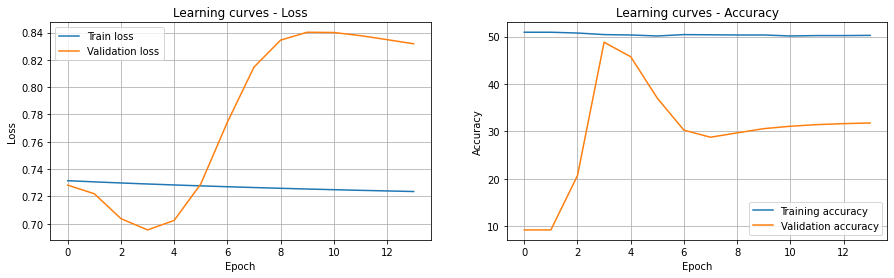

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 256-256, act = Softplus, opt = RMSprop, lr = 0.0001, reg = False, max_features = 2703, n_max = 2, vect_type = cv, approach = none


Best val_loss: 0.25086 - train_loss: 0.18609 - val_acc: 91.22% - train_acc: 93.13% - balanced_accuracy: 0.59% - execution_time: 74s


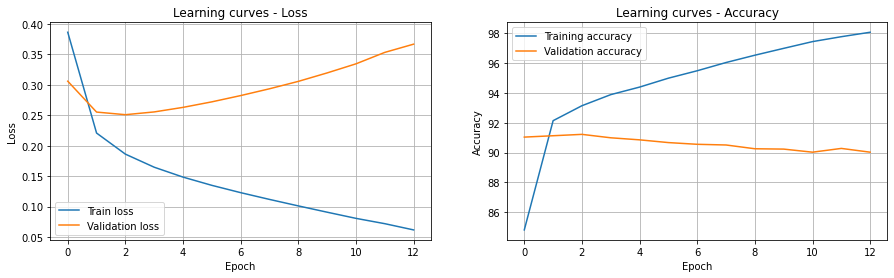

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 2048-2048-2048, act = Sigmoid, opt = SGD, lr = 1e-06, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = cv, approach = mid



Best val_loss: 0.86860 - train_loss: 0.71504 - val_acc: 9.84% - train_acc: 49.55% - balanced_accuracy: 0.50% - execution_time: 449s


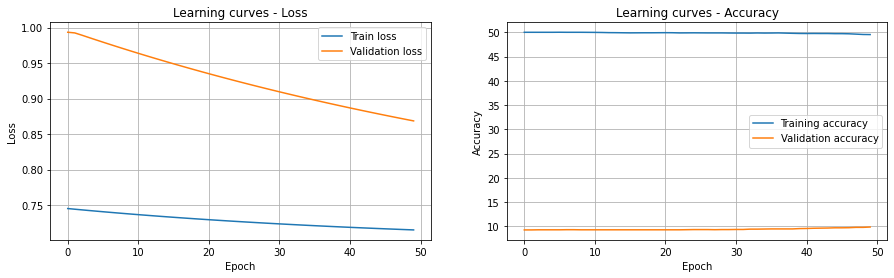

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 1024, act = Softplus, opt = Adam, lr = 1e-05, reg = Batch norm, max_features = 4935, n_max = 3, vect_type = cv, approach = under



Best val_loss: 0.78273 - train_loss: 0.52764 - val_acc: 41.50% - train_acc: 95.24% - balanced_accuracy: 0.56% - execution_time: 204s


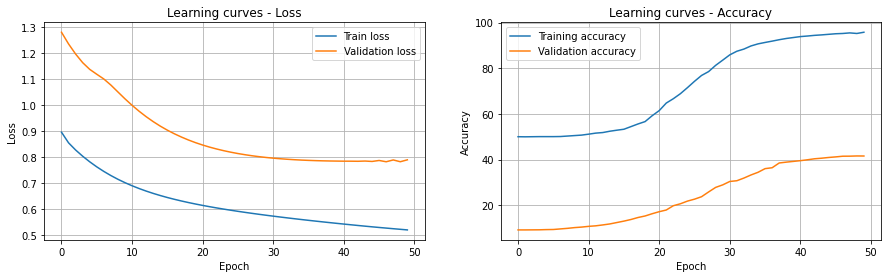

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 256, act = Softplus, opt = Adam, lr = 0.001, reg = Batch norm, max_features = 1900, n_max = 2, vect_type = cv, approach = none


Best val_loss: 0.25456 - train_loss: 0.20948 - val_acc: 91.13% - train_acc: 92.16% - balanced_accuracy: 0.58% - execution_time: 50s


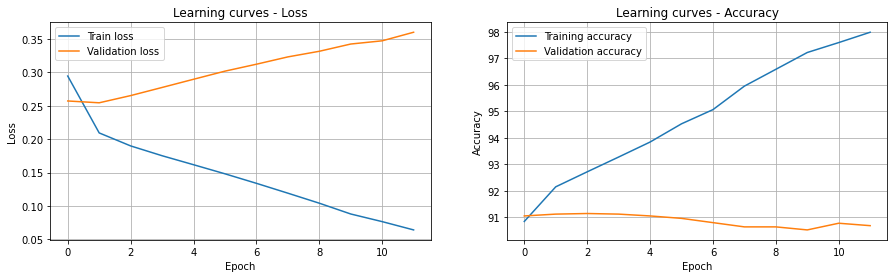

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 2048-2048, act = GELU, opt = RMSprop, lr = 1e-06, reg = False, max_features = 4935, n_max = 1, vect_type = cv, approach = none



Best val_loss: 0.25478 - train_loss: 0.16924 - val_acc: 91.13% - train_acc: 93.94% - balanced_accuracy: 0.55% - execution_time: 537s


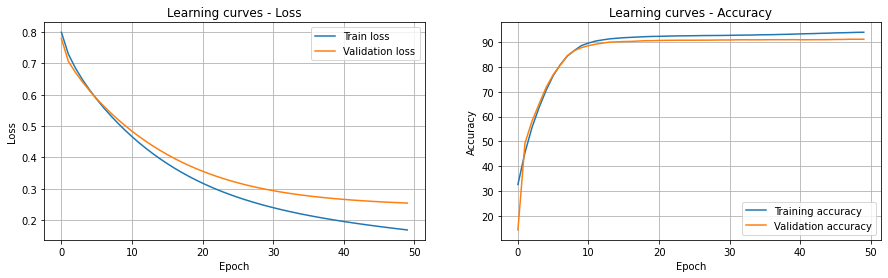

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = LeakyReLU, opt = Adam, lr = 0.01, reg = Dropout, max_features = 2703, n_max = 2, vect_type = cv, approach = mid


Best val_loss: 1.25129 - train_loss: 0.89228 - val_acc: 15.34% - train_acc: 57.96% - balanced_accuracy: 0.53% - execution_time: 57s


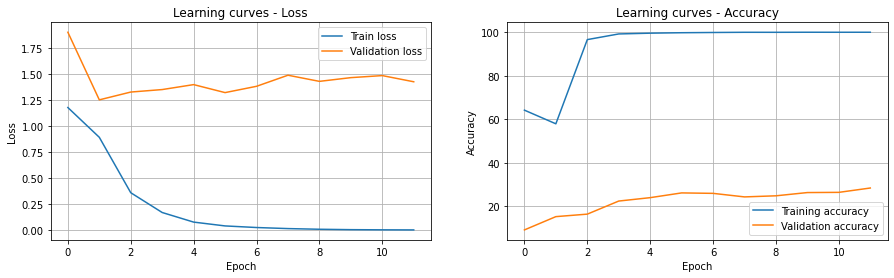

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 256-256, act = LeakyReLU, opt = RMSprop, lr = 0.0001, reg = Dropout, max_features = 1000, n_max = 3, vect_type = cv, approach = none


Best val_loss: 0.25481 - train_loss: 0.18234 - val_acc: 91.13% - train_acc: 92.81% - balanced_accuracy: 0.56% - execution_time: 34s


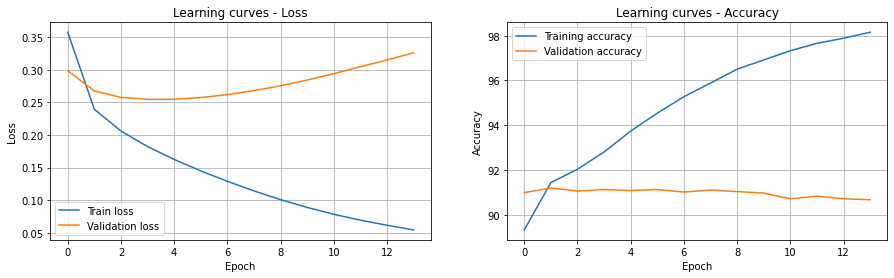

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 512-512, act = ELU, opt = RMSprop, lr = 1e-05, reg = False, max_features = 2703, n_max = 2, vect_type = cv, approach = mid


Best val_loss: 0.64991 - train_loss: 0.70041 - val_acc: 82.55% - train_acc: 55.14% - balanced_accuracy: 0.48% - execution_time: 53s


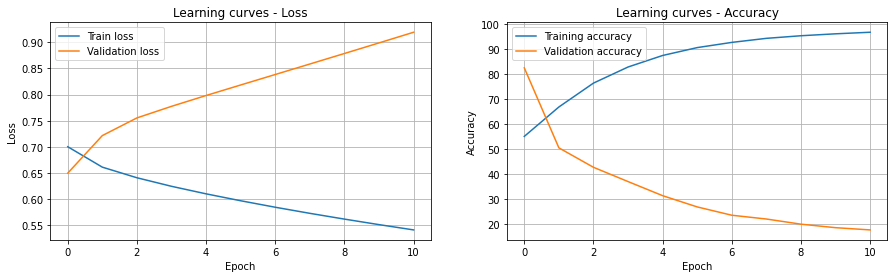

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 128-128-1024, act = GELU, opt = SGD, lr = 0.001, reg = Dropout, max_features = 2703, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.53042 - train_loss: 0.73480 - val_acc: 90.76% - train_acc: 48.14% - balanced_accuracy: 0.50% - execution_time: 27s


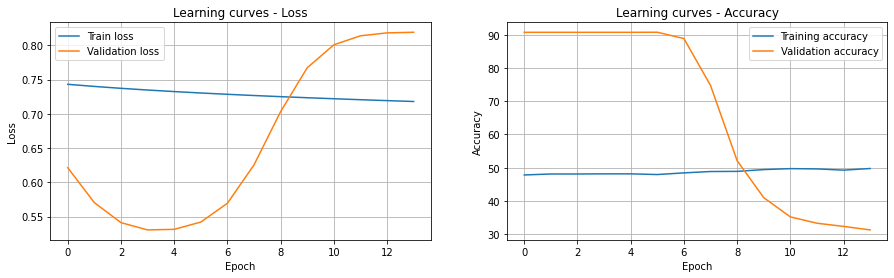

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 2048-2048-256, act = ELU, opt = SGD, lr = 1e-06, reg = Dropout, max_features = 1900, n_max = 2, vect_type = cv, approach = mid



Best val_loss: 0.74455 - train_loss: 0.73575 - val_acc: 44.12% - train_acc: 49.16% - balanced_accuracy: 0.52% - execution_time: 185s


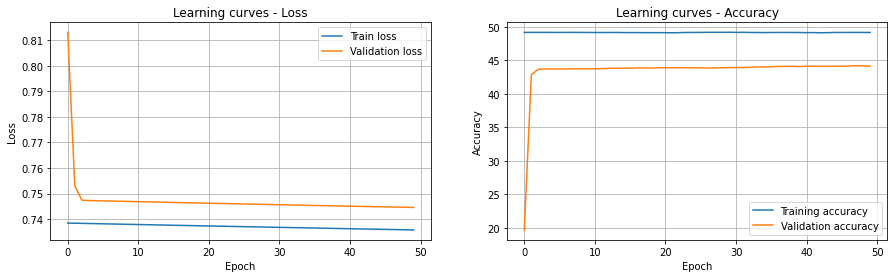

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 2048-2048-256, act = ELU, opt = SGD, lr = 1e-06, reg = Dropout, max_features = 2703, n_max = 2, vect_type = tfidf, approach = under


Best val_loss: 0.70249 - train_loss: 0.74039 - val_acc: 10.25% - train_acc: 50.41% - balanced_accuracy: 0.50% - execution_time: 24s


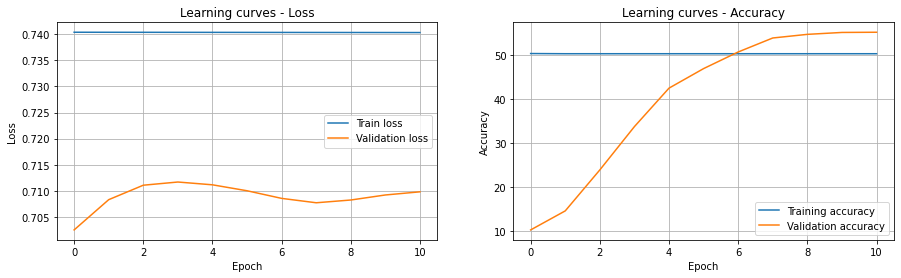

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = GELU, opt = Adam, lr = 0.01, reg = False, max_features = 1000, n_max = 2, vect_type = cv, approach = mid


Best val_loss: 0.87067 - train_loss: 0.73979 - val_acc: 29.53% - train_acc: 48.35% - balanced_accuracy: 0.54% - execution_time: 24s


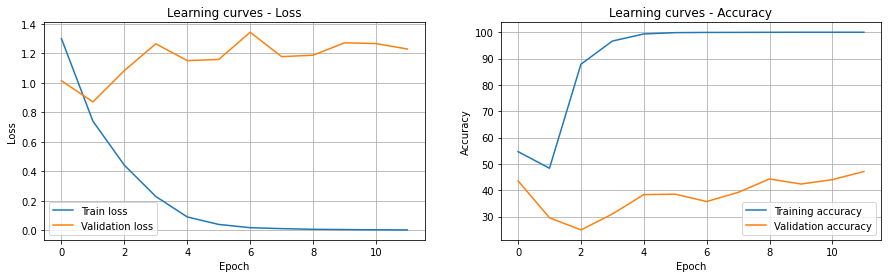

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 512-512-2048, act = Sigmoid, opt = SGD, lr = 1e-05, reg = False, max_features = 2703, n_max = 2, vect_type = cv, approach = none



Best val_loss: 0.31314 - train_loss: 0.31105 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 300s


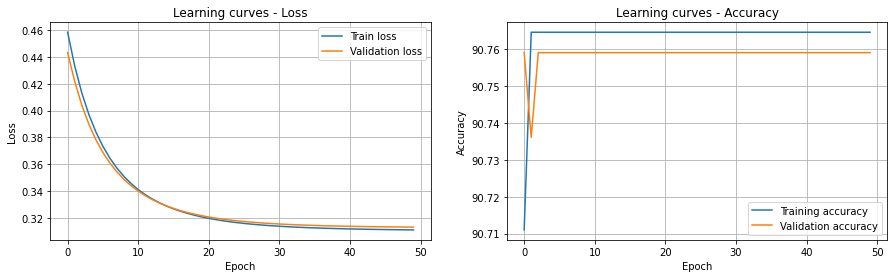

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 1024-1024, act = Softplus, opt = RMSprop, lr = 1e-05, reg = Dropout, max_features = 1900, n_max = 2, vect_type = cv, approach = none


Best val_loss: 0.25111 - train_loss: 0.18842 - val_acc: 90.85% - train_acc: 92.84% - balanced_accuracy: 0.55% - execution_time: 87s


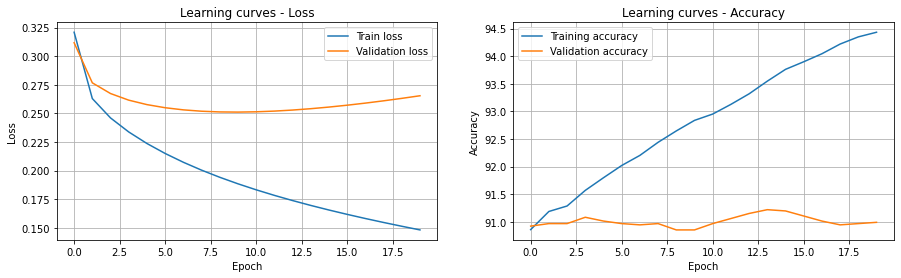

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 64-64, act = Sigmoid, opt = RMSprop, lr = 0.01, reg = False, max_features = 1000, n_max = 2, vect_type = tfidf, approach = under


Best val_loss: 1.20261 - train_loss: 0.13803 - val_acc: 28.32% - train_acc: 99.50% - balanced_accuracy: 0.56% - execution_time: 25s


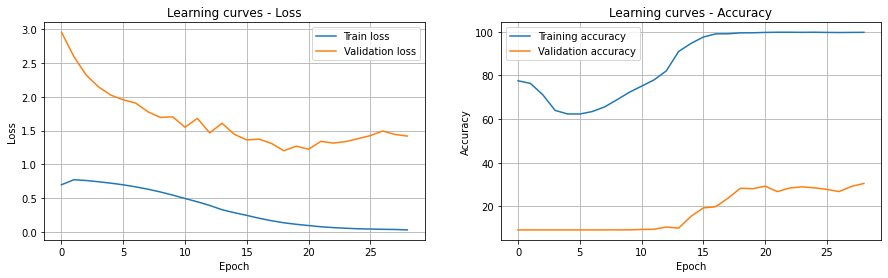

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 1024-1024-256, act = Sigmoid, opt = SGD, lr = 1e-05, reg = Batch norm, max_features = 1000, n_max = 1, vect_type = tfidf, approach = none



Best val_loss: 0.42149 - train_loss: 0.42199 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 114s


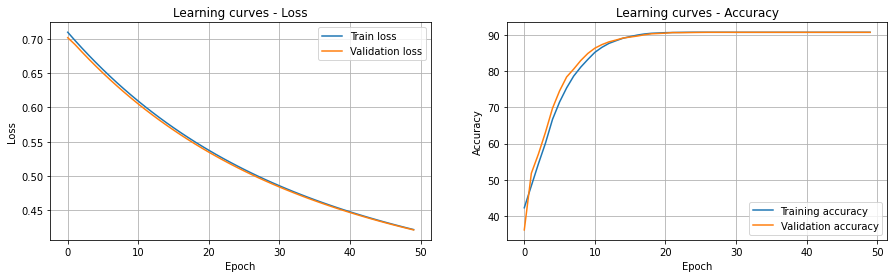

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 2048, act = ELU, opt = Adam, lr = 1e-06, reg = Dropout, max_features = 1000, n_max = 1, vect_type = cv, approach = under



Best val_loss: 0.67797 - train_loss: 0.70358 - val_acc: 58.15% - train_acc: 55.96% - balanced_accuracy: 0.52% - execution_time: 50s


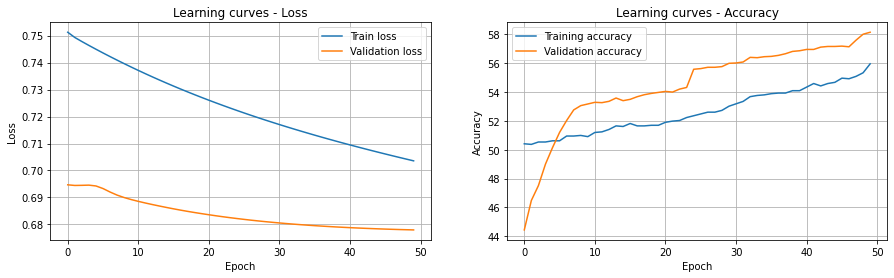

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 128-128-256, act = LeakyReLU, opt = SGD, lr = 0.001, reg = False, max_features = 2703, n_max = 2, vect_type = tfidf, approach = none



Best val_loss: 0.26075 - train_loss: 0.16797 - val_acc: 91.26% - train_acc: 92.46% - balanced_accuracy: 0.54% - execution_time: 279s


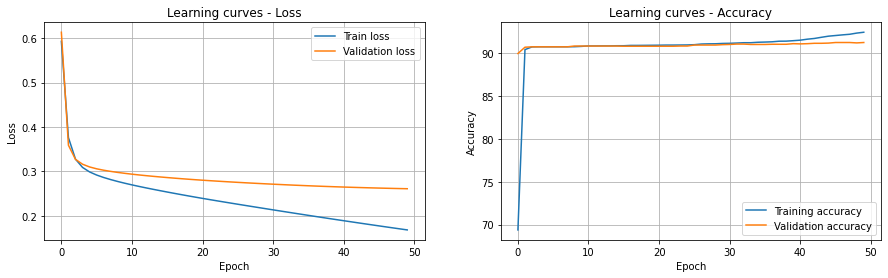

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 256, act = GELU, opt = Adam, lr = 0.001, reg = Batch norm, max_features = 4935, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.70560 - train_loss: 0.87409 - val_acc: 9.31% - train_acc: 38.33% - balanced_accuracy: 0.50% - execution_time: 40s


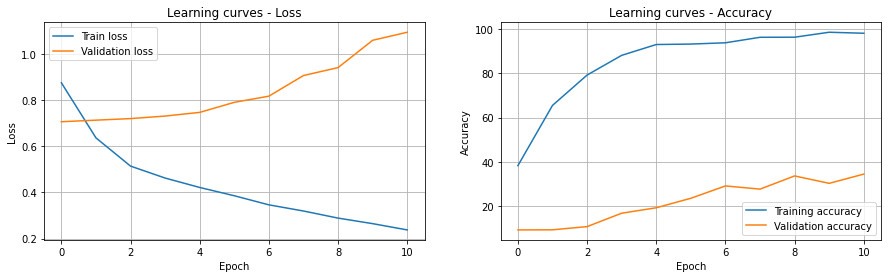

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 128-128, act = Sigmoid, opt = RMSprop, lr = 0.001, reg = False, max_features = 1000, n_max = 1, vect_type = tfidf, approach = under


Best val_loss: 0.90305 - train_loss: 0.50647 - val_acc: 18.83% - train_acc: 90.23% - balanced_accuracy: 0.52% - execution_time: 30s


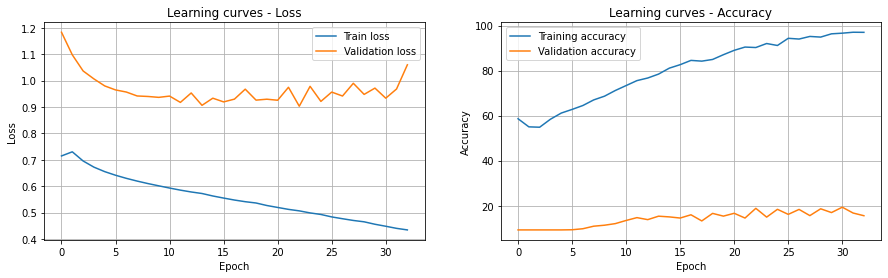

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = Sigmoid, opt = Adam, lr = 0.01, reg = Dropout, max_features = 2703, n_max = 3, vect_type = tfidf, approach = mid


Best val_loss: 1.97793 - train_loss: 1.04036 - val_acc: 9.29% - train_acc: 39.93% - balanced_accuracy: 0.50% - execution_time: 61s


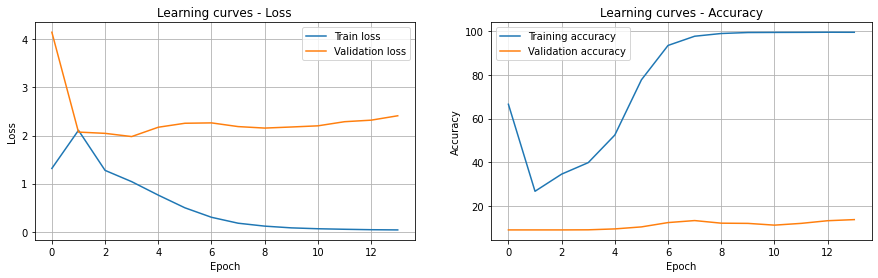

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = LeakyReLU, opt = Adam, lr = 0.01, reg = Dropout, max_features = 1900, n_max = 1, vect_type = cv, approach = under


Best val_loss: 0.61157 - train_loss: 1.25400 - val_acc: 87.43% - train_acc: 43.79% - balanced_accuracy: 0.51% - execution_time: 18s


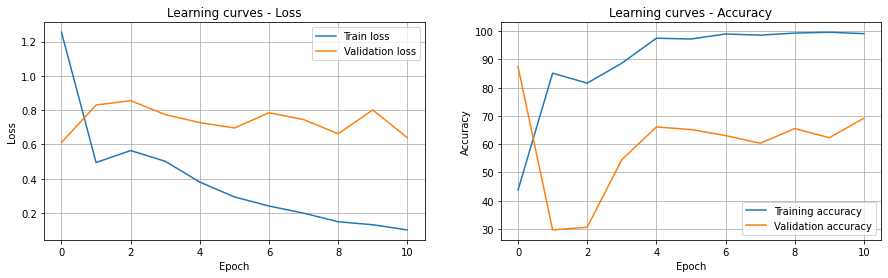

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = Softplus, opt = Adam, lr = 0.01, reg = Dropout, max_features = 1900, n_max = 3, vect_type = cv, approach = mid



Best val_loss: 0.68780 - train_loss: 0.00122 - val_acc: 76.77% - train_acc: 100.00% - balanced_accuracy: 0.50% - execution_time: 178s


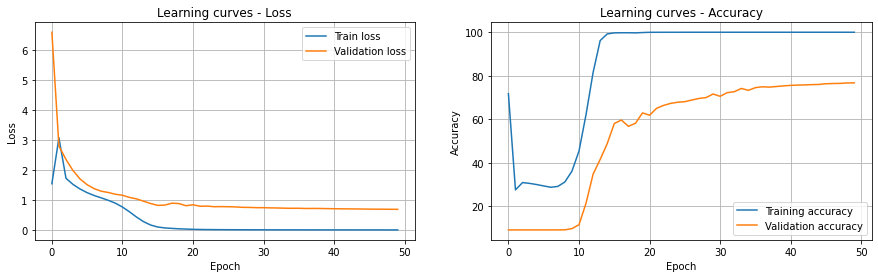

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 256-256-1024, act = Sigmoid, opt = SGD, lr = 0.0001, reg = False, max_features = 4935, n_max = 3, vect_type = cv, approach = mid


Best val_loss: 0.72776 - train_loss: 0.69186 - val_acc: 9.31% - train_acc: 54.46% - balanced_accuracy: 0.50% - execution_time: 86s


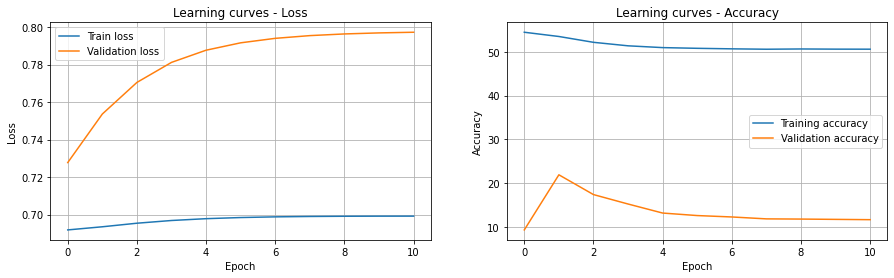

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 64-64-128, act = ELU, opt = SGD, lr = 0.01, reg = False, max_features = 4935, n_max = 1, vect_type = tfidf, approach = none


Best val_loss: 0.25481 - train_loss: 0.15999 - val_acc: 90.55% - train_acc: 94.37% - balanced_accuracy: 0.61% - execution_time: 144s


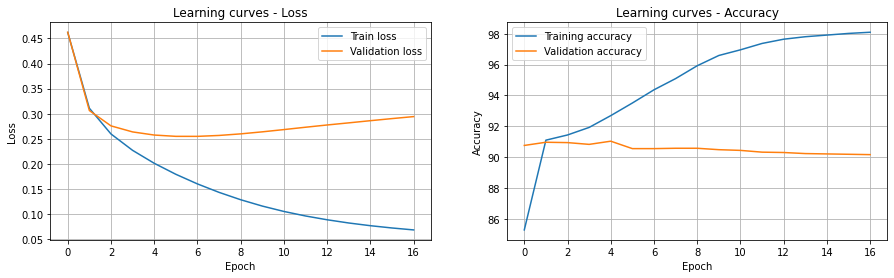

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = ELU, opt = Adam, lr = 0.01, reg = False, max_features = 2703, n_max = 1, vect_type = cv, approach = under


Best val_loss: 0.69597 - train_loss: 1.03601 - val_acc: 54.53% - train_acc: 40.15% - balanced_accuracy: 0.52% - execution_time: 24s


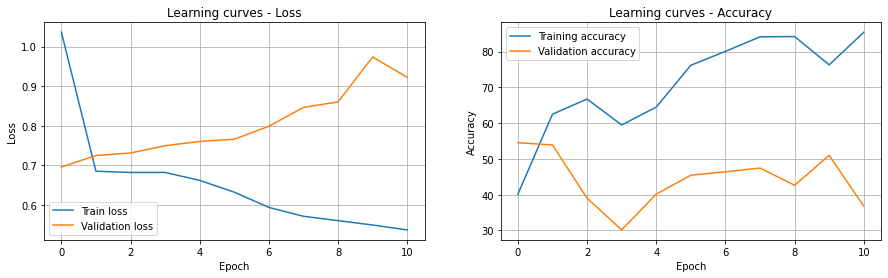

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 256-256, act = LeakyReLU, opt = RMSprop, lr = 0.0001, reg = False, max_features = 2703, n_max = 3, vect_type = cv, approach = under


Best val_loss: 0.72084 - train_loss: 0.67543 - val_acc: 10.36% - train_acc: 61.84% - balanced_accuracy: 0.50% - execution_time: 25s


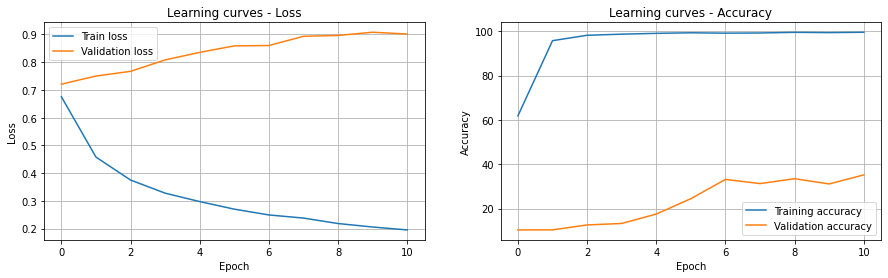

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 512-512-512, act = LeakyReLU, opt = SGD, lr = 1e-05, reg = False, max_features = 1000, n_max = 1, vect_type = tfidf, approach = none



Best val_loss: 0.40620 - train_loss: 0.40742 - val_acc: 90.35% - train_acc: 90.42% - balanced_accuracy: 0.50% - execution_time: 111s


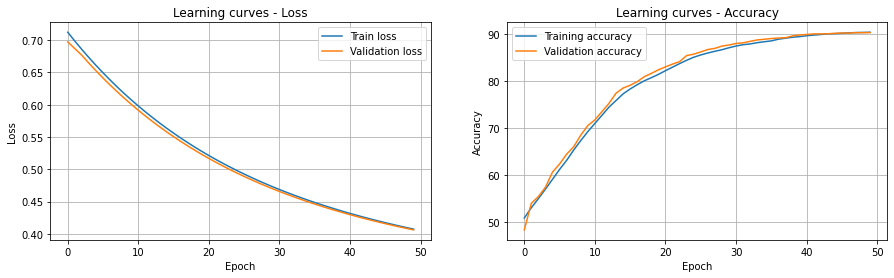

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 1024, act = ELU, opt = Adam, lr = 1e-06, reg = False, max_features = 1900, n_max = 1, vect_type = tfidf, approach = mid


Best val_loss: 0.70271 - train_loss: 0.73637 - val_acc: 41.23% - train_acc: 51.47% - balanced_accuracy: 0.50% - execution_time: 33s


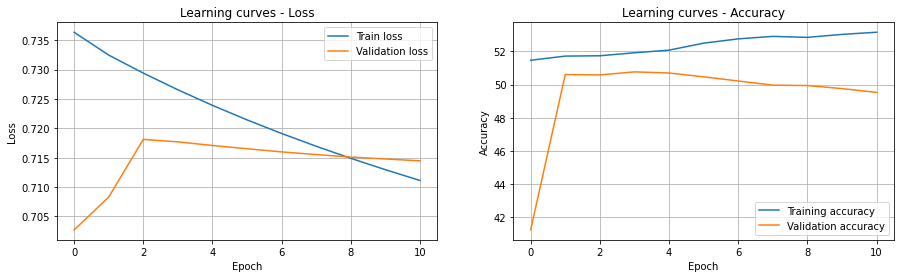

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 512-512, act = GELU, opt = RMSprop, lr = 1e-05, reg = False, max_features = 1000, n_max = 1, vect_type = cv, approach = none


Best val_loss: 0.25469 - train_loss: 0.15806 - val_acc: 90.97% - train_acc: 94.29% - balanced_accuracy: 0.57% - execution_time: 92s


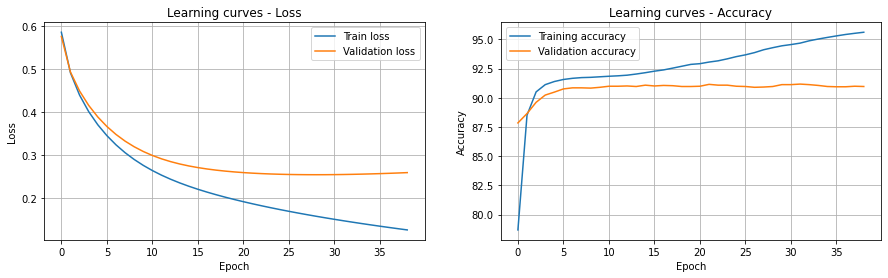

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 1024-1024-512, act = GELU, opt = SGD, lr = 1e-05, reg = Batch norm, max_features = 1900, n_max = 1, vect_type = tfidf, approach = none


Best val_loss: 0.57314 - train_loss: 0.78015 - val_acc: 90.76% - train_acc: 40.77% - balanced_accuracy: 0.50% - execution_time: 40s


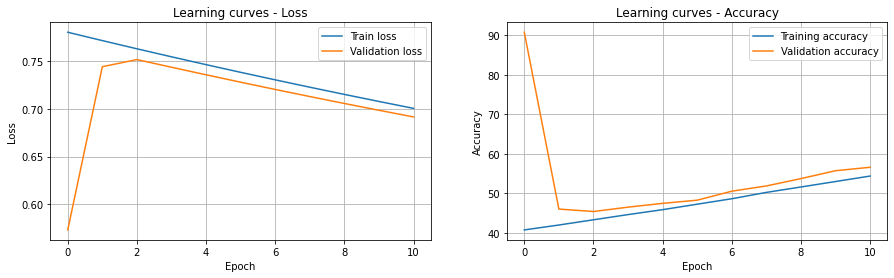

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 64, act = GELU, opt = Adam, lr = 0.01, reg = Dropout, max_features = 2703, n_max = 2, vect_type = tfidf, approach = under


Best val_loss: 0.67619 - train_loss: 1.19438 - val_acc: 73.81% - train_acc: 36.75% - balanced_accuracy: 0.49% - execution_time: 22s


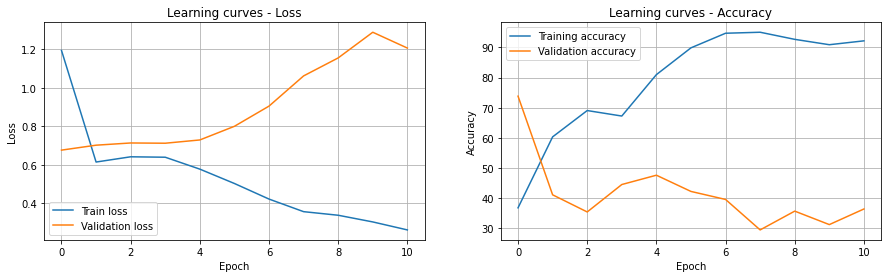

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 64-64-64, act = LeakyReLU, opt = SGD, lr = 0.01, reg = False, max_features = 1000, n_max = 1, vect_type = cv, approach = under


Best val_loss: 0.70671 - train_loss: 0.69576 - val_acc: 22.29% - train_acc: 53.06% - balanced_accuracy: 0.51% - execution_time: 12s


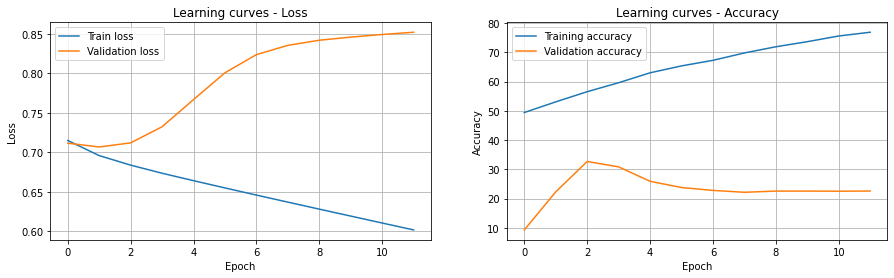

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 2048, act = GELU, opt = Adam, lr = 1e-06, reg = False, max_features = 2703, n_max = 2, vect_type = cv, approach = mid


Best val_loss: 0.70450 - train_loss: 0.72543 - val_acc: 42.15% - train_acc: 49.72% - balanced_accuracy: 0.51% - execution_time: 54s


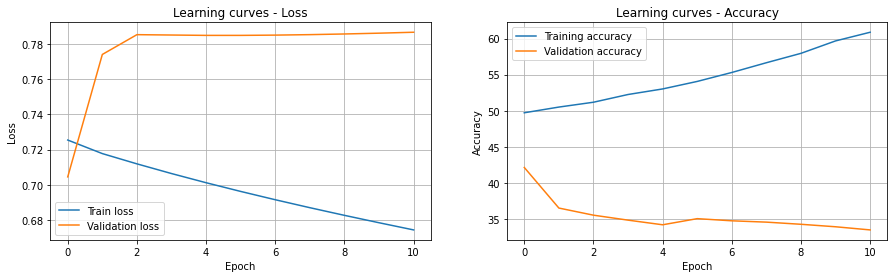

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 512-512, act = GELU, opt = RMSprop, lr = 1e-05, reg = False, max_features = 4935, n_max = 2, vect_type = tfidf, approach = mid


Best val_loss: 0.62061 - train_loss: 0.62918 - val_acc: 73.47% - train_acc: 62.19% - balanced_accuracy: 0.53% - execution_time: 96s


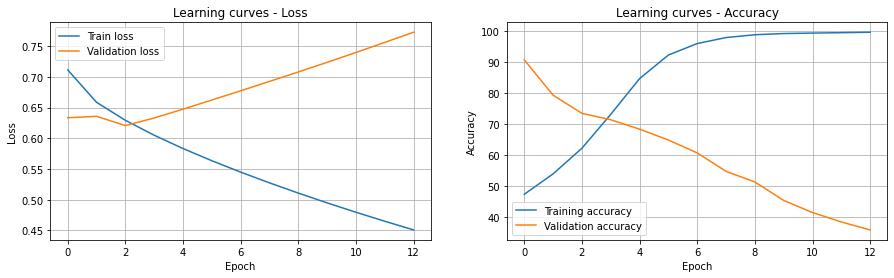

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 2048-2048, act = Sigmoid, opt = RMSprop, lr = 1e-06, reg = Dropout, max_features = 1000, n_max = 3, vect_type = cv, approach = mid


Best val_loss: 0.62431 - train_loss: 0.70566 - val_acc: 90.23% - train_acc: 47.99% - balanced_accuracy: 0.50% - execution_time: 25s


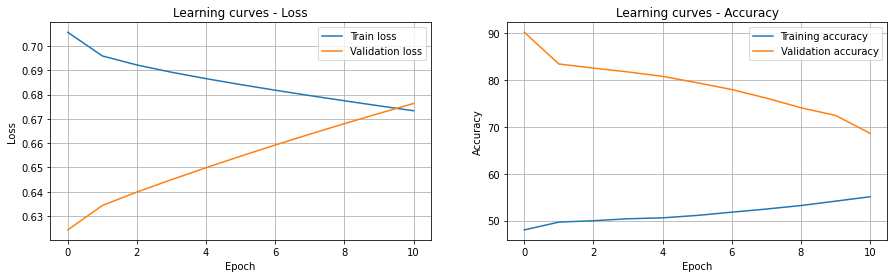

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 64-64-512, act = Softplus, opt = SGD, lr = 0.01, reg = Dropout, max_features = 1900, n_max = 3, vect_type = cv, approach = mid


Best val_loss: 4.06591 - train_loss: 0.17396 - val_acc: 9.24% - train_acc: 95.53% - balanced_accuracy: 0.50% - execution_time: 39s


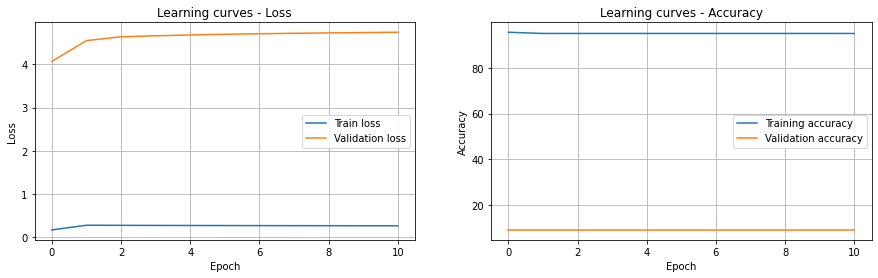

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 2048, act = Softplus, opt = Adam, lr = 1e-06, reg = Dropout, max_features = 1900, n_max = 1, vect_type = cv, approach = none



Best val_loss: 0.27670 - train_loss: 0.25094 - val_acc: 91.01% - train_acc: 91.18% - balanced_accuracy: 0.52% - execution_time: 217s


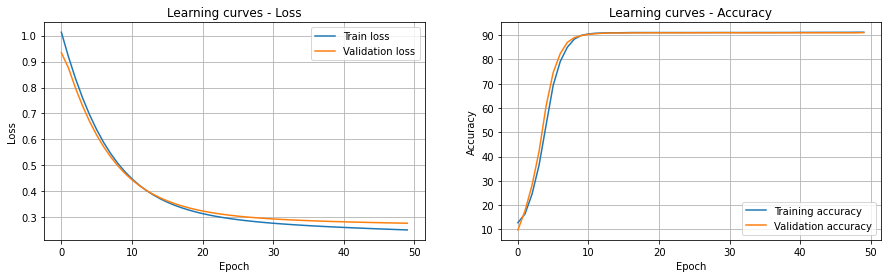

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 128-128, act = Sigmoid, opt = RMSprop, lr = 0.001, reg = Dropout, max_features = 2703, n_max = 2, vect_type = tfidf, approach = mid


Best val_loss: 1.00785 - train_loss: 0.01573 - val_acc: 53.13% - train_acc: 99.99% - balanced_accuracy: 0.65% - execution_time: 198s


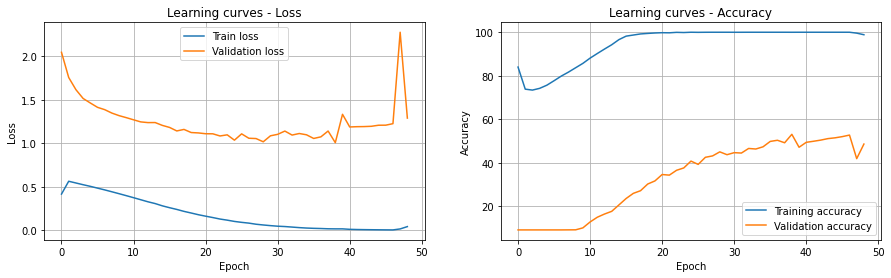

--------------------------------------------------------------------------------------------------------------------
RESULTS SORTED BY ACCURACY
Val_acc = 91.29 - Balanced_val_acc = 0.60 -> HL = 1, Nh = 128, act = GELU     , opt = Adam   , lr =  0.001, reg = False, max_features = 2703, n_max = 2, vect_type = cv, approach = none
Val_acc = 91.26 - Balanced_val_acc = 0.54 -> HL = 3, Nh = 128-128-256, act = LeakyReLU, opt = SGD    , lr =  0.001, reg = False, max_features = 2703, n_max = 2, vect_type = tfidf, approach = none
Val_acc = 91.22 - Balanced_val_acc = 0.59 -> HL = 2, Nh = 256-256, act = Softplus , opt = RMSprop, lr = 0.0001, reg = False, max_features = 2703, n_max = 2, vect_type = cv, approach = none
Val_acc = 91.13 - Balanced_val_acc = 0.58 -> HL = 1, Nh = 256, act = Softplus , opt = Adam   , lr =  0.001, reg = Batch norm, max_features = 1900, n_max = 2, vect_type = cv, approach = none
Val_acc = 91.13 - Balanced_val_acc = 0.55 -> HL = 2, Nh = 2048-2048, act = GELU     , opt = RMSp

In [ ]:
## Correct change hyper-space

# Define possible values for each hyper-parameter
HL_v = [1,2,3,4,5,6]
Nh_v = [64, 128, 256, 512, 1024, 2048]
act_v = ['Sigmoid', 'LeakyReLU', 'ELU', 'GELU', 'Softplus']
act_dict = {'Sigmoid':nn.Sigmoid(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU(), 'GELU':nn.GELU(), 'Softplus':nn.Softplus()}
opt_v = ['Adam', 'RMSprop', 'SGD']
lr_v = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
reg_v = ['False', 'Dropout', 'Batch norm']
# wd_v = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# train_batch_size_v = [100, 250, 500, 1000]

max_features_v = [1000, 1900, 2703, 4935]
n_min = 1 # , 2, 3]
n_max_v = [1, 2, 3]
vect_type_v = ['cv', 'tfidf']
approach_v = ['none', 'under', 'mid']

# max_features = 250
# n_min = 1 # , 2, 3]
# n_max = 1
# vect_type = 'cv'#, 'tfidf']
# approach = 'none'

results = []

# RANDOM SEARCH
random.seed(1)
pbar = tq.tqdm(total = 50, desc = 'Random search progress')

# random_coarse_grid = list(itertools.product(HL_v, Nh_v, Nh_v, Nh_v, Nh_v, Nh_v, Nh_v, act_v, opt_v, lr_v, reg_v, max_features_v, n_max_v, vect_type_v, approach_v))

random_coarse_grid_1 = list(itertools.product(HL_v, Nh_v, Nh_v, Nh_v, act_v))
random_coarse_grid_2 = list(itertools.product(opt_v, lr_v, reg_v, max_features_v, n_max_v, vect_type_v, approach_v))
random_coarse_grid = [x + y for x, y in zip(random_coarse_grid_1, random_coarse_grid_2)] 


for (HL, Nh1, Nh3, Nh5, act, opt, lr, reg, max_features, n_max, vect_type, approach) in random.sample(random_coarse_grid, 50):
    # sampling combinations from itertools.product, we are sure no combination is repeated
    Nh2 = Nh1
    Nh4 = Nh3
    Nh6 = Nh5

    print(f'FCNN with HL = {HL}, Nh = {Nh1}{-Nh2 if HL >= 2 else ""}{-Nh3 if HL >= 3 else ""}{-Nh4 if HL >= 4 else ""}{-Nh5 if HL >= 5 else ""}{-Nh6 if HL >= 6 else ""}, act = {act}, opt = {opt}, lr = {lr},'
          f' reg = {reg}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}')
    
    start_time = time.time()
    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    activation = act_dict[act]
    net = FCNetmod(max_features, Nh1, Nh2, Nh3, Nh4, Nh5, Nh6, 2, HL, activation, reg)
    net.to(device)

    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Define the optimizer
    # if reg == 'L2':
    #     opt_dict = {'Adam': optim.Adam(net.parameters(), lr =lr, weight_decay = wd),
    #                 'RMSprop': optim.RMSprop(net.parameters(), lr = lr, weight_decay = wd),
    #                 'SGD': optim.SGD(net.parameters(), lr = lr, weight_decay = wd)}
    #     optimizer = opt_dict[opt]
    # else:
    opt_dict = {'Adam': optim.Adam(net.parameters(), lr = lr), 
                'RMSprop': optim.RMSprop(net.parameters(), lr = lr),
                'SGD': optim.SGD(net.parameters(), lr = lr)}
    optimizer = opt_dict[opt]

    # Dataloader definition
    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

    train_dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)
    val_dataset = MyDataset(X_val_v, y_val, transform=composed_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=False, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=250, shuffle=False, num_workers=0)

    # TRAINING LOOP
    num_epochs = 50
    patience = 10
    train_loss_log, val_loss_log, best_t_loss, best_v_loss, train_accuracy_log, val_accuracy_log, best_t_acc, best_v_acc, bacc, net = training_loop(net, 
                            train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch=0, patience=patience)
    
    results.append((np.round(best_v_acc, 2), np.round(bacc, 2), f'HL = {HL}, Nh = {Nh1}{-Nh2 if HL >= 2 else ""}{-Nh3 if HL >= 3 else ""}{-Nh4 if HL >= 4 else ""}{-Nh5 if HL >= 5 else ""}{-Nh6 if HL >= 6 else ""}, act = {act:9}, opt = {opt:7}, lr = {lr:6},'
                                             f' reg = {reg}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}'))
    run_time = time.time() - start_time
    print(f'Best val_loss: {best_v_loss:.5f} - train_loss: {best_t_loss:.5f} - val_acc: {best_v_acc:.2f}% - train_acc: {best_t_acc:.2f}% - balanced_accuracy: {bacc:.2f}% - execution_time: {run_time:.0f}s') 
    
    plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log)
    print('--------------------------------------------------------------------------------------------------------------------')
    pbar.update(1)

print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

#### Best networks

FCNN with HL = 3, Nh = 1024, act = ELU, opt = SGD, lr = 0.0001, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = tfidf, approach = none



Best val_loss: 0.27282 - train_loss: 0.24027 - val_acc: 90.94% - train_acc: 91.43% - balanced_accuracy: 0.53% - execution_time: 987s


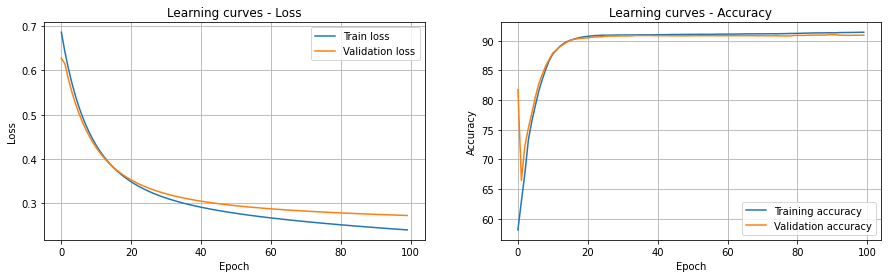

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = ELU, opt = Adam, lr = 1e-05, reg = Dropout, max_features = 1000, n_max = 2, vect_type = cv, approach = none



Best val_loss: 0.31325 - train_loss: 0.29743 - val_acc: 90.92% - train_acc: 91.01% - balanced_accuracy: 0.51% - execution_time: 239s


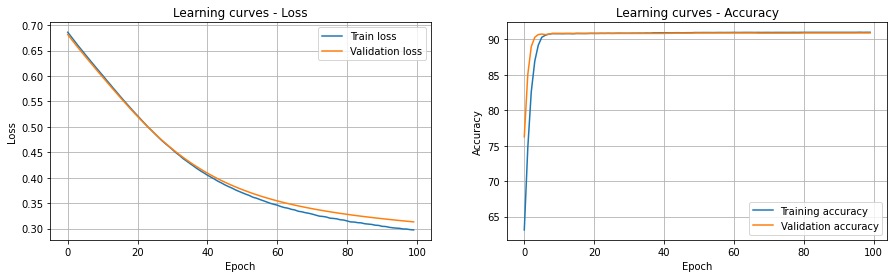

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 4, Nh = 64, act = GELU, opt = SGD, lr = 0.001, reg = Batch norm, max_features = 1900, n_max = 1, vect_type = cv, approach = none


Best val_loss: 0.27296 - train_loss: 0.15328 - val_acc: 91.13% - train_acc: 94.20% - balanced_accuracy: 0.55% - execution_time: 396s


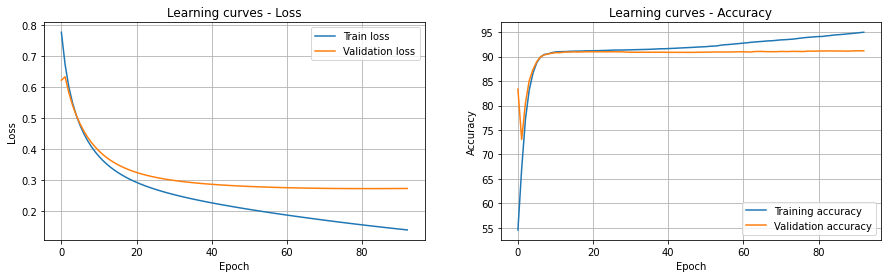

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 6, Nh = 256, act = Softplus, opt = Adam, lr = 1e-06, reg = Batch norm, max_features = 1000, n_max = 3, vect_type = cv, approach = none



Best val_loss: 0.31807 - train_loss: 0.28888 - val_acc: 90.94% - train_acc: 91.84% - balanced_accuracy: 0.53% - execution_time: 261s


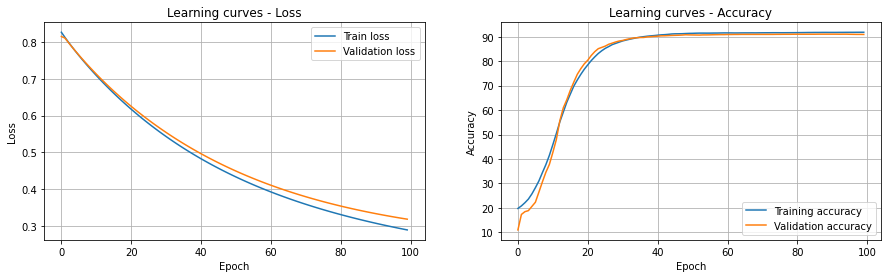

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 128, act = ELU, opt = Adam, lr = 0.001, reg = False, max_features = 1900, n_max = 1, vect_type = cv, approach = mid


Best val_loss: 0.58116 - train_loss: 0.42080 - val_acc: 71.66% - train_acc: 80.12% - balanced_accuracy: 0.73% - execution_time: 60s


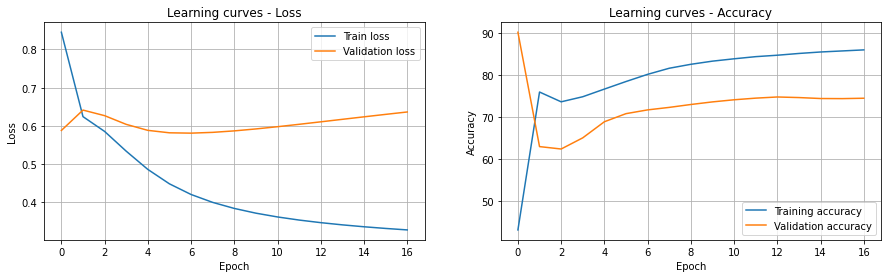

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 256, act = GELU, opt = RMSprop, lr = 0.0001, reg = False, max_features = 4935, n_max = 1, vect_type = tfidf, approach = mid


Best val_loss: 0.50141 - train_loss: 0.30770 - val_acc: 76.24% - train_acc: 88.34% - balanced_accuracy: 0.73% - execution_time: 190s


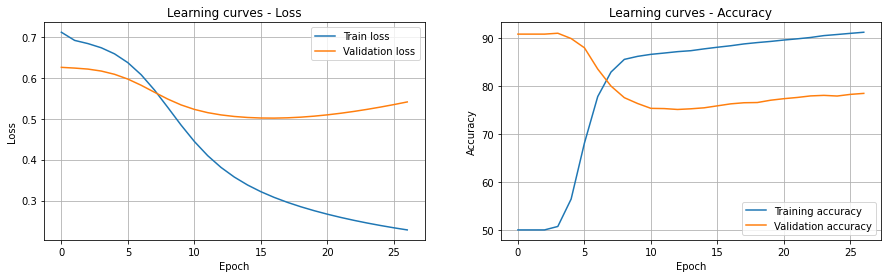

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 2048, act = Softplus, opt = Adam, lr = 1e-06, reg = Batch norm, max_features = 2703, n_max = 1, vect_type = cv, approach = none



Best val_loss: 0.26035 - train_loss: 0.20660 - val_acc: 90.87% - train_acc: 91.97% - balanced_accuracy: 0.52% - execution_time: 572s


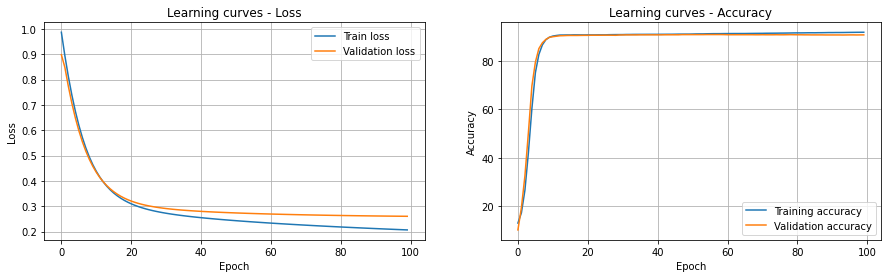

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 2, Nh = 2048-2048, act = GELU, opt = RMSprop, lr = 1e-06, reg = False, max_features = 4935, n_max = 1, vect_type = cv, approach = none


Best val_loss: 0.24570 - train_loss: 0.11766 - val_acc: 91.63% - train_acc: 96.12% - balanced_accuracy: 0.59% - execution_time: 896s


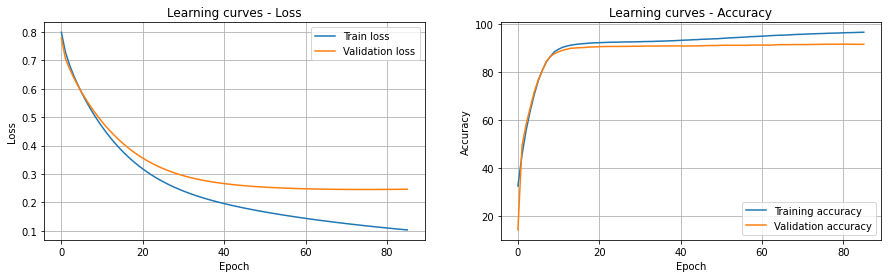

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 1024-1024-256, act = Sigmoid, opt = SGD, lr = 1e-05, reg = Batch norm, max_features = 1000, n_max = 1, vect_type = tfidf, approach = none



Best val_loss: 0.35198 - train_loss: 0.35106 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 219s


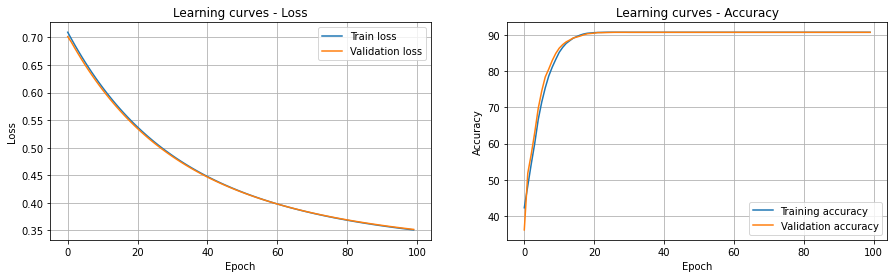

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 128-128-256, act = LeakyReLU, opt = SGD, lr = 0.001, reg = False, max_features = 2703, n_max = 2, vect_type = tfidf, approach = none


Best val_loss: 0.25845 - train_loss: 0.13680 - val_acc: 91.24% - train_acc: 94.13% - balanced_accuracy: 0.56% - execution_time: 397s


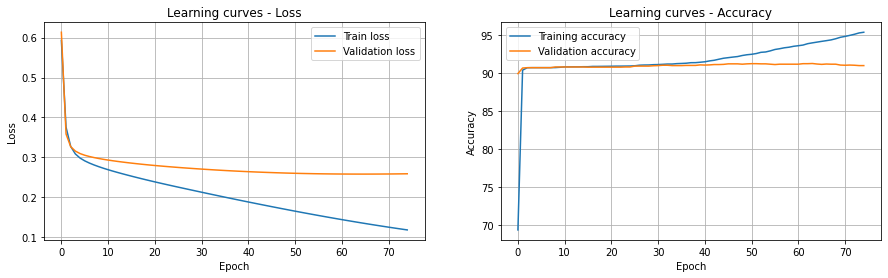

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 3, Nh = 512-512-512, act = LeakyReLU, opt = SGD, lr = 1e-05, reg = False, max_features = 1000, n_max = 1, vect_type = tfidf, approach = none



Best val_loss: 0.34536 - train_loss: 0.34427 - val_acc: 90.76% - train_acc: 90.76% - balanced_accuracy: 0.50% - execution_time: 217s


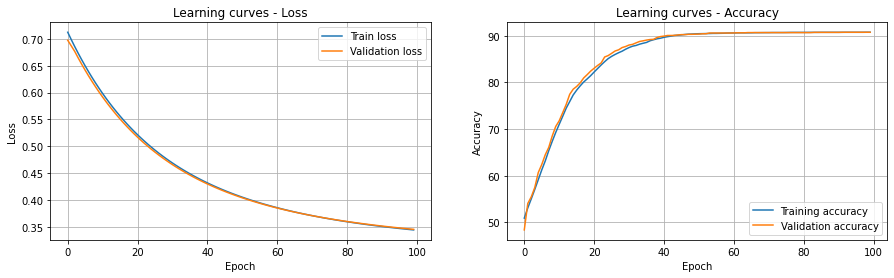

--------------------------------------------------------------------------------------------------------------------
FCNN with HL = 1, Nh = 2048, act = Softplus, opt = Adam, lr = 1e-06, reg = Batch norm, max_features = 2703, n_max = 1, vect_type = cv, approach = none



Best val_loss: 0.26035 - train_loss: 0.20660 - val_acc: 90.87% - train_acc: 91.97% - balanced_accuracy: 0.52% - execution_time: 589s


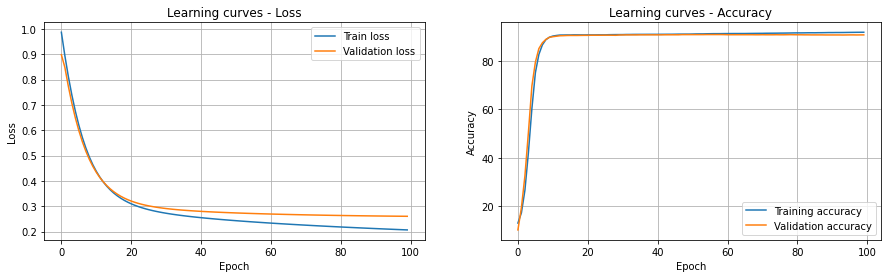

--------------------------------------------------------------------------------------------------------------------
RESULTS SORTED BY ACCURACY
Val_acc = 91.63 - Balanced_val_acc = 0.59 -> HL = 2, Nh = 2048-2048, act = GELU     , opt = RMSprop, lr =  1e-06, reg = False, max_features = 4935, n_max = 1, vect_type = cv, approach = none
Val_acc = 91.24 - Balanced_val_acc = 0.56 -> HL = 3, Nh = 128-128-256, act = LeakyReLU, opt = SGD    , lr =  0.001, reg = False, max_features = 2703, n_max = 2, vect_type = tfidf, approach = none
Val_acc = 91.13 - Balanced_val_acc = 0.55 -> HL = 4, Nh =   64, act = GELU     , opt = SGD    , lr =  0.001, reg = Batch norm, max_features = 1900, n_max = 1, vect_type = cv, approach = none
Val_acc = 90.94 - Balanced_val_acc = 0.53 -> HL = 3, Nh = 1024, act = ELU      , opt = SGD    , lr = 0.0001, reg = Batch norm, max_features = 4935, n_max = 2, vect_type = tfidf, approach = none
Val_acc = 90.94 - Balanced_val_acc = 0.53 -> HL = 6, Nh =  256, act = Softplus , opt

In [ ]:
n_min = 1 
act_dict = {'Sigmoid':nn.Sigmoid(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU(), 'GELU':nn.GELU(), 'Softplus':nn.Softplus()}

best_fcnn = [[3, 1024, 'ELU', 'SGD', 0.0001, 'Batch norm', 4935, 2, 'tfidf', 'none'],
             [1, 128, 'ELU', 'Adam', 1e-05, 'Dropout', 1000, 2, 'cv', 'none'],
             [4, 64, 'GELU', 'SGD', 0.001,'Batch norm', 1900, 1, 'cv', 'none'],
             [6, 256, 'Softplus', 'Adam', 1e-06, 'Batch norm', 1000, 3, 'cv', 'none'],
             [1, 128, 'ELU', 'Adam', 0.001, False, 1900, 1, 'cv', 'mid'],
             [2, 256, 'GELU', 'RMSprop', 0.0001, False, 4935, 1, 'tfidf', 'mid'],
             ]

results = []


# RANDOM SEARCH
random.seed(1)
pbar = tq.tqdm(total = 12, desc = 'Random search progress')
# random_coarse_grid = list(itertools.product(HL_v, Nh_v, act_v, opt_v, lr_v, reg_v, max_features_v, n_max_v, vect_type_v, approach_v))
for (HL, Nh, act, opt, lr, reg, max_features, n_max, vect_type, approach) in best_fcnn:
    # sampling combinations from itertools.product, we are sure no combination is repeated
    print(f'FCNN with HL = {HL}, Nh = {Nh}, act = {act}, opt = {opt}, lr = {lr},'
          f' reg = {reg}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}')
    
    start_time = time.time()
    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    activation = act_dict[act]
    net = FCNet(max_features, Nh, 2, HL, activation, reg)
    net.to(device)

    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Define the optimizer
    # if reg == 'L2':
    #     opt_dict = {'Adam': optim.Adam(net.parameters(), lr =lr, weight_decay = wd),
    #                 'RMSprop': optim.RMSprop(net.parameters(), lr = lr, weight_decay = wd),
    #                 'SGD': optim.SGD(net.parameters(), lr = lr, weight_decay = wd)}
    #     optimizer = opt_dict[opt]
    # else:
    opt_dict = {'Adam': optim.Adam(net.parameters(), lr = lr), 
                'RMSprop': optim.RMSprop(net.parameters(), lr = lr),
                'SGD': optim.SGD(net.parameters(), lr = lr)}
    optimizer = opt_dict[opt]

    # Dataloader definition
    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

    train_dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)
    val_dataset = MyDataset(X_val_v, y_val, transform=composed_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=False, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=250, shuffle=False, num_workers=0)

    # TRAINING LOOP
    num_epochs = 100
    patience = 10
    train_loss_log, val_loss_log, best_t_loss, best_v_loss, train_accuracy_log, val_accuracy_log, best_t_acc, best_v_acc, bacc, net = training_loop(net, 
                            train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch=0, patience=patience)
    
    results.append((np.round(best_v_acc, 2), np.round(bacc, 2), f'HL = {HL}, Nh = {Nh:4}, act = {act:9}, opt = {opt:7}, lr = {lr:6},'
                                             f' reg = {reg}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}'))
    run_time = time.time() - start_time
    print(f'Best val_loss: {best_v_loss:.5f} - train_loss: {best_t_loss:.5f} - val_acc: {best_v_acc:.2f}% - train_acc: {best_t_acc:.2f}% - balanced_accuracy: {bacc:.2f}% - execution_time: {run_time:.0f}s') 
    
    plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log)
    print('--------------------------------------------------------------------------------------------------------------------')
    pbar.update(1)


best_fcnn_mod = [[1, 2048, 0, 0, 'Softplus', 'Adam', 1e-06, 'Batch norm', 2703, 1, 'cv', 'none'],
                 [2, 2048, 0, 0, 'GELU', 'RMSprop', 1e-06, False, 4935, 1, 'cv', 'none'],
                 [3, 1024, 256, 0, 'Sigmoid', 'SGD', 1e-05, 'Batch norm', 1000, 1, 'tfidf', 'none'],
                 [3, 128, 256, 0, 'LeakyReLU', 'SGD', 0.001, False, 2703, 2, 'tfidf', 'none'],
                 [3, 512, 512, 0, 'LeakyReLU', 'SGD', 1e-05, False, 1000, 1, 'tfidf', 'none'],
                 [1, 2048, 0, 0, 'Softplus', 'Adam', 1e-06, 'Batch norm', 2703, 1, 'cv', 'none'],
                 ]


for (HL, Nh1, Nh3, Nh5, act, opt, lr, reg, max_features, n_max, vect_type, approach) in best_fcnn_mod:
    # sampling combinations from itertools.product, we are sure no combination is repeated
    Nh2 = Nh1
    Nh4 = Nh3
    Nh6 = Nh5

    print(f'FCNN with HL = {HL}, Nh = {Nh1}{-Nh2 if HL >= 2 else ""}{-Nh3 if HL >= 3 else ""}{-Nh4 if HL >= 4 else ""}{-Nh5 if HL >= 5 else ""}{-Nh6 if HL >= 6 else ""}, act = {act}, opt = {opt}, lr = {lr},'
          f' reg = {reg}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}')
    
    start_time = time.time()
    # NETWORK INITIALIZATION
    torch.manual_seed(0)
    activation = act_dict[act]
    net = FCNetmod(max_features, Nh1, Nh2, Nh3, Nh4, Nh5, Nh6, 2, HL, activation, reg)
    net.to(device)

    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Define the optimizer
    # if reg == 'L2':
    #     opt_dict = {'Adam': optim.Adam(net.parameters(), lr =lr, weight_decay = wd),
    #                 'RMSprop': optim.RMSprop(net.parameters(), lr = lr, weight_decay = wd),
    #                 'SGD': optim.SGD(net.parameters(), lr = lr, weight_decay = wd)}
    #     optimizer = opt_dict[opt]
    # else:
    opt_dict = {'Adam': optim.Adam(net.parameters(), lr = lr), 
                'RMSprop': optim.RMSprop(net.parameters(), lr = lr),
                'SGD': optim.SGD(net.parameters(), lr = lr)}
    optimizer = opt_dict[opt]

    # Dataloader definition
    X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
    X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

    train_dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)
    val_dataset = MyDataset(X_val_v, y_val, transform=composed_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=False, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=250, shuffle=False, num_workers=0)

    # TRAINING LOOP
    num_epochs = 100
    patience = 10
    train_loss_log, val_loss_log, best_t_loss, best_v_loss, train_accuracy_log, val_accuracy_log, best_t_acc, best_v_acc, bacc, net = training_loop(net, 
                            train_dataloader, val_dataloader, loss_function, optimizer, num_epochs, no_improve_epoch=0, patience=patience)
    
    results.append((np.round(best_v_acc, 2), np.round(bacc, 2), f'HL = {HL}, Nh = {Nh1}{-Nh2 if HL >= 2 else ""}{-Nh3 if HL >= 3 else ""}{-Nh4 if HL >= 4 else ""}{-Nh5 if HL >= 5 else ""}{-Nh6 if HL >= 6 else ""}, act = {act:9}, opt = {opt:7}, lr = {lr:6},'
                                             f' reg = {reg}, max_features = {max_features}, n_max = {n_max}, vect_type = {vect_type}, approach = {approach}'))
    run_time = time.time() - start_time
    print(f'Best val_loss: {best_v_loss:.5f} - train_loss: {best_t_loss:.5f} - val_acc: {best_v_acc:.2f}% - train_acc: {best_t_acc:.2f}% - balanced_accuracy: {bacc:.2f}% - execution_time: {run_time:.0f}s') 
    
    plot_losses(train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log)
    print('--------------------------------------------------------------------------------------------------------------------')
    pbar.update(1)


print('RESULTS SORTED BY ACCURACY')
for r in sorted(results, key=lambda tup: tup[0], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

print('RESULTS SORTED BY BALANCED ACCURACY')
for r in sorted(results, key=lambda tup: tup[1], reverse = True):
    print(f'Val_acc = {r[0]:.2f} - Balanced_val_acc = {r[1]:.2f} -> {r[2]}')

#### Test set evaluation

##### Accuracy

In [ ]:
# Val_acc = 91.63 - Balanced_val_acc = 0.59 -> HL = 2, Nh = 2048-2048, act = GELU     , opt = RMSprop, lr =  1e-06, reg = False, max_features = 4935, n_max = 1, vect_type = cv, approach = none

(HL, Nh1, Nh3, Nh5, act, opt, lr, reg, max_features, n_max, vect_type, 
 approach) = [2, 2048, 0, 0, 'GELU', 'RMSprop', 1e-06, 'False', 4935, 1, 'cv', 'none']
Nh2 = Nh1
Nh4 = Nh3
Nh6 = Nh5

random.seed(1)

start_time = time.time()
# NETWORK INITIALIZATION
torch.manual_seed(0)
activation = act_dict[act]
net = FCNetmod(max_features, Nh1, Nh2, Nh3, Nh4, Nh5, Nh6, 2, HL, activation, reg)
net.to(device)

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = lr)


# Dataloader definition

# X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
# X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, max_features, n_min, n_max, vect_type)
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, approach)

# train_dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)
# val_dataset = MyDataset(X_val_v, y_val, transform=composed_transform)

train_val_dataset = MyDataset(X_train_val_v_r, y_train_val_r, transform=composed_transform)
test_dataset = MyDataset(X_test_v, y_test, transform=composed_transform)

# train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=False, num_workers=0)
# val_dataloader = DataLoader(val_dataset, batch_size=250, shuffle=False, num_workers=0)

train_val_dataloader = DataLoader(train_val_dataset, batch_size=250, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=250, shuffle=False, num_workers=0)


# TRAINING LOOP
start_time = time.time()

train_loss_log = []; val_loss_log = []
train_accuracy_log = []; val_accuracy_log = []

for epoch_num in tq.tqdm(range(75), desc = f'Training'):

    # ----------- TRAIN -----------
    train_loss= []
    all_outputs, all_labels = [], []
    net.train() # Training mode (e.g. enable dropout, and all other stochastic behaviours)
    for sample_batched in train_val_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_function(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss and output for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)

    train_accuracy = accuracy(all_outputs, all_labels)
    train_accuracy_log.append(train_accuracy)

    # Save average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)
    

    # # ----------- VALIDATION -----------
    val_loss, all_outputs_v, all_labels_v = validation(test_dataloader, net)
    # print(val_loss)
    val_loss_log.append(val_loss)

    val_accuracy = accuracy(all_outputs_v, all_labels_v)
    # print(val_accuracy)
    val_accuracy_log.append(val_accuracy)
        

 
run_time = time.time() - start_time


In [ ]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader:
    
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

# test_loss = loss_function(all_outputs, all_labels)
# print(f"AVERAGE TEST LOSS: {test_loss}")
# tot_correct_out = (all_outputs.argmax(dim=-1) == all_labels).sum()
# test_accuracy = 100 * tot_correct_out / len(all_labels)
# print(f"TEST ACCURACY: {test_accuracy:.2f}%")

In [ ]:
# # train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
# # train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
# test_acc = (1.0 * (all_outputs.argmax(dim=-1) == all_labels)).mean()
# test_bacc = balanced_accuracy_score(all_labels.cpu(), all_outputs.argmax(dim=-1).cpu())
# # print(f'Accuracy on training + validation set: {train_acc_rf}')
# # print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
# print(f'Test accuracy: {test_acc:.3}')
# print(f'Test balanced accuracy: {test_bacc:.3}')

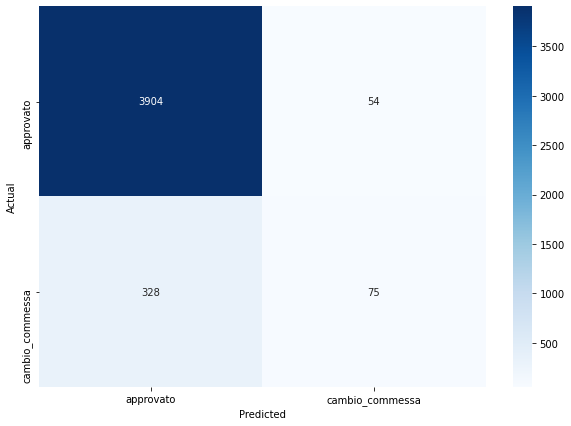

In [ ]:
# Test set
conf_mat = confusion_matrix(all_labels.cpu(), all_outputs.argmax(dim=-1).cpu())
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix, metric_results = metrics_results(np.array(all_labels.cpu()), np.array(all_outputs.argmax(dim=-1).cpu()))
print('CLASSIFICATION METRICS')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.912
Weighted accuracy: 0.586
Precision: 0.581
Sensitivity: 0.186
Specificity: 0.986
MCC: 0.295
F-score: 0.282


##### Balanced Accuracy

In [ ]:
# Val_acc = 76.24 - Balanced_val_acc = 0.73 -> HL = 2, Nh =  256, act = GELU     , opt = RMSprop, lr = 0.0001, reg = False, max_features = 4935, n_max = 1, vect_type = tfidf, approach = mid

(HL, Nh, act, opt, lr, reg, max_features, n_max, vect_type, 
 approach) = [2, 256, 'GELU', 'RMSprop', 0.0001, 'False', 4935, 1, 'tfidf', 'mid']

random.seed(1)

start_time = time.time()
# NETWORK INITIALIZATION
torch.manual_seed(0)
activation = act_dict[act]
net = FCNet(max_features, Nh, 2, HL, activation, reg)
net.to(device)

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = lr)


# Dataloader definition

# X_train_v, X_val_v, X_test_v, vect = vectorizer(X_train, X_val, X_test, max_features, n_min, n_max, vect_type)
# X_train_v_r, y_train_r = resampling(X_train_v, y_train, approach)

X_train_val_v, _, X_test_v, vect = vectorizer(X_train_val, X_val, X_test, max_features, n_min, n_max, vect_type)
X_train_val_v_r, y_train_val_r = resampling(X_train_val_v, y_train_val, approach)

# train_dataset = MyDataset(X_train_v_r, y_train_r, transform=composed_transform)
# val_dataset = MyDataset(X_val_v, y_val, transform=composed_transform)

train_val_dataset = MyDataset(X_train_val_v_r, y_train_val_r, transform=composed_transform)
test_dataset = MyDataset(X_test_v, y_test, transform=composed_transform)

# train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=False, num_workers=0)
# val_dataloader = DataLoader(val_dataset, batch_size=250, shuffle=False, num_workers=0)

train_val_dataloader = DataLoader(train_val_dataset, batch_size=250, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=250, shuffle=False, num_workers=0)


# TRAINING LOOP
start_time = time.time()

train_loss_log = []; val_loss_log = []
train_accuracy_log = []; val_accuracy_log = []

for epoch_num in tq.tqdm(range(15), desc = f'Training'):

    # ----------- TRAIN -----------
    train_loss= []
    all_outputs, all_labels = [], []
    net.train() # Training mode (e.g. enable dropout, and all other stochastic behaviours)
    for sample_batched in train_val_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_function(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss and output for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)

    train_accuracy = accuracy(all_outputs, all_labels)
    train_accuracy_log.append(train_accuracy)

    # Save average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)
    

    # # ----------- VALIDATION -----------
    val_loss, all_outputs_v, all_labels_v = validation(test_dataloader, net)
    # print(val_loss)
    val_loss_log.append(val_loss)

    val_accuracy = accuracy(all_outputs_v, all_labels_v)
    # print(val_accuracy)
    val_accuracy_log.append(val_accuracy)
        

 
run_time = time.time() - start_time


In [ ]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader:
    
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

# test_loss = loss_function(all_outputs, all_labels)
# print(f"AVERAGE TEST LOSS: {test_loss}")
# tot_correct_out = (all_outputs.argmax(dim=-1) == all_labels).sum()
# test_accuracy = 100 * tot_correct_out / len(all_labels)
# print(f"TEST ACCURACY: {test_accuracy:.2f}%")

In [ ]:
# # train_acc_rf = accuracy(y_train_val_pred_rf, y_train_val_r)
# # train_bacc_rf = balanced_accuracy_score(y_train_val_r, y_train_val_pred_rf)
# test_acc = (1.0 * (all_outputs.argmax(dim=-1) == all_labels)).mean()
# test_bacc = balanced_accuracy_score(all_labels.cpu(), all_outputs.argmax(dim=-1).cpu())
# # print(f'Accuracy on training + validation set: {train_acc_rf}')
# # print(f'Balanced accuracy on training + validation set: {train_bacc_rf}')
# print(f'Test accuracy: {test_acc:.3}')
# print(f'Test balanced accuracy: {test_bacc:.3}')

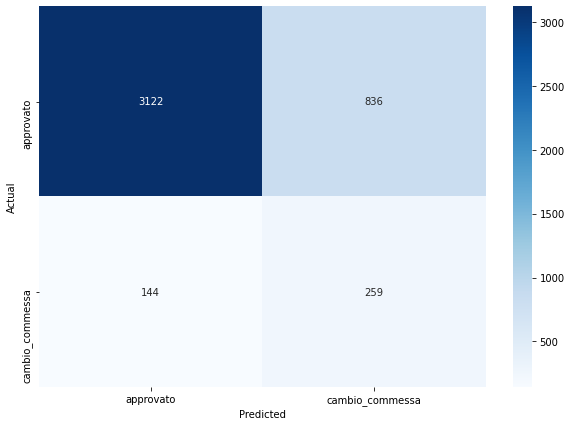

In [ ]:
# Test set
conf_mat = confusion_matrix(all_labels.cpu(), all_outputs.argmax(dim=-1).cpu())
fig, ax = plt.subplots(figsize=(10,7))
y_labels = ['approvato', 'cambio_commessa']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
conf_matrix, metric_results = metrics_results(np.array(all_labels.cpu()), np.array(all_outputs.argmax(dim=-1).cpu()))
print('CLASSIFICATION METRICS')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.775
Weighted accuracy: 0.716
Precision: 0.237
Sensitivity: 0.643
Specificity: 0.789
MCC: 0.288
F-score: 0.346


# Comparisons

#### Best accuracy

In [ ]:
accuracy_comparison = pd.DataFrame(np.array([[0.948, 0.933, 0.910, 0.908, 0.946, 0.912],
                                             [0.783, 0.828, 0.565, 0.502, 0.789, 0.586]]), 
                                    index = ['Accuracy', 'Balanced Accuracy'] , columns=['Random Forest', 'Logistic Regression', 'KNN', 'SVM', 'Gradient Boosting', 'FFNN']).T
print('Models with higher accuracy')
accuracy_comparison

Models with higher accuracy


Accuracy  Balanced Accuracy
Random Forest           0.948              0.783
Logistic Regression     0.933              0.828
KNN                     0.910              0.565
SVM                     0.908              0.502
Gradient Boosting       0.946              0.789
FFNN                    0.912              0.586

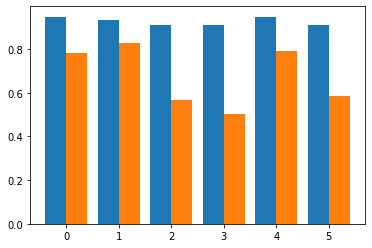

In [ ]:
bar_width = 0.4
bar1 = plt.bar(np.arange(6) - bar_width/2, np.array(accuracy_comparison.loc[:,['Accuracy']]).flatten(), bar_width)
bar2 = plt.bar(np.arange(6) + bar_width/2, np.array(accuracy_comparison.loc[:,['Balanced Accuracy']]).flatten(), bar_width)

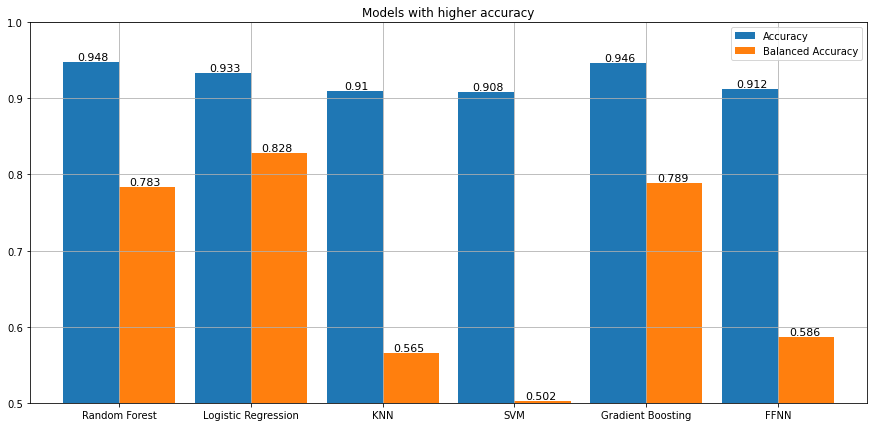

In [ ]:
accuracy_comparison.plot.bar(figsize = (15, 7), rot = 0, grid=True, ylim = (0.5, 1), width = .85)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height,3), ha='center', va='bottom', fontsize=11, rotation = 0)
_ = plt.title('Models with higher accuracy') 

#### Best balanced accuracy

In [ ]:
accuracy_comparison = pd.DataFrame(np.array([[0.933, 0.873, 0.855, 0.843, 0.906, 0.775],
                                             [0.828, 0.813, 0.722, 0.840, 0.861, 0.716]]), 
                                    index = ['Accuracy', 'Balanced Accuracy'] , columns=['Random Forest', 'Logistic Regression', 'KNN', 'SVM', 'Gradient Boosting', 'FFNN']).T
print('Models with higher accuracy')
accuracy_comparison

Models with higher accuracy


Accuracy  Balanced Accuracy
Random Forest           0.933              0.828
Logistic Regression     0.873              0.813
KNN                     0.855              0.722
SVM                     0.843              0.840
Gradient Boosting       0.906              0.861
FFNN                    0.775              0.716

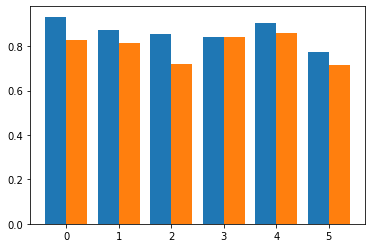

In [ ]:
bar_width = 0.4
bar1 = plt.bar(np.arange(6) - bar_width/2, np.array(accuracy_comparison.loc[:,['Accuracy']]).flatten(), bar_width)
bar2 = plt.bar(np.arange(6) + bar_width/2, np.array(accuracy_comparison.loc[:,['Balanced Accuracy']]).flatten(), bar_width)

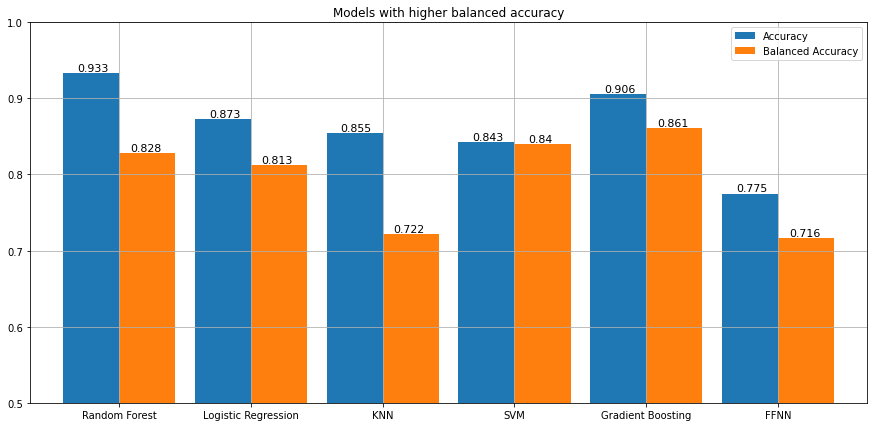

In [ ]:
accuracy_comparison.plot.bar(figsize = (15, 7), rot = 0, grid=True, ylim = (0.5, 1), width = .85)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height,3), ha='center', va='bottom', fontsize=11, rotation = 0)
_ = plt.title('Models with higher balanced accuracy') 